In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import logging

base_dir = os.path.abspath("..")
sys.path.append(base_dir)

from utils.analyze_lensing import make_lensing_dataframe, \
    integrated_event_duration_posterior, t_of_tau, count_events_per_source, \
    count_filter_seq
from utils.mc_backgrounds import synthesize_background
from utils.plotting import plot_event, plot_lightcurve
from utils.kde_label import cluster_label_dataframe
from utils.helpers import subtract_baseline
from dl import authClient as ac, queryClient as qc
from scipy.special import gammainc

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = os.path.join(base_dir, "plots/2sep2024_MC/")
results_dir = os.path.join(base_dir, "results/2sep2024_MC/")
log_dir = os.path.join(base_dir, "logs/2sep2024_MC/")

log_file = os.path.join(log_dir, "MC_results.log")
logging.basicConfig(filename=log_file, level=logging.ERROR)

In [2]:
def get_lc(oid):
    q = f"""
    SELECT m.objectid, m.filter, m.mag_auto, m.magerr_auto, m.mjd, m.exposure, e.exptime
        FROM nsc_dr2.meas AS m
        INNER JOIN nsc_dr2.exposure AS e
        ON e.exposure = m.exposure
        WHERE m.objectid = '{oid}'
    """
    result = qc.query(sql=q, fmt="pandas")
    result = result.groupby(by="filter").filter(lambda x: len(x) > 2)
    result.sort_values(by="mjd", inplace=True)
    return result

def set_rng_state(oid, rng_state_df, rng):
    rng_state = rng_state_df.loc[oid, "rng_state"]
    state_dict = rng.bit_generator.state
    state_dict.update({"state": {"state": int(rng_state), "inc": state_dict["state"]["inc"]}})
    rng.bit_generator.state = state_dict
    return rng

def lens_lc(oid, rates, taus, rng_state_df, rng):
    lc = get_lc(oid)
    rng = set_rng_state(oid, rng_state_df, rng)
    result = synthesize_background(lc, rates, taus, rng)
    return result

def plot_montecarlo_lc(lc, taus, rng_state_df, rng,
                       fig=None, **kwargs):
    oid = lc.iloc[0, 0]
    rng = set_rng_state(oid, rng_state_df, rng)

    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    else:
        ax = fig.get_axes()[0]

    ax.cla()
    plot_lightcurve(lc, ax, **kwargs)
    t_last_sample = lc.iloc[-1, 4]
    t_first_sample = lc.iloc[0, 4]
    event_time = (t_last_sample - t_first_sample) + taus
    n_ev_exp = event_time * rates
    n_ev_drawn = rng.poisson(lam=n_ev_exp)
    result = lc.iloc[:, 2].copy()

    for i in range(len(taus)):
        n_ev = n_ev_drawn[i]
        tau = taus[i]
        start_times = rng.uniform(low=t_first_sample-tau, high=t_last_sample, size=n_ev)
    
        for st in start_times:
            lower_bound = st
            upper_bound = st + tau
            ax.axvspan(lower_bound, upper_bound, alpha=0.2, color="tab:gray")

    return fig

def chi2_cdf(x, k):
    result = 1 - gammainc(k/2, x/2)
    return result

def g_test(observed, expected):
    g = 2 * (observed * np.log(observed/expected)).sum()
    k = len(observed) - 1
    p = chi2_cdf(g, k)
    result = {"g": g, "p": p}
    return result


In [3]:
lc_class_df = pd.read_parquet(f"{results_dir}lc_class.parquet")
aggregate_df = pd.read_parquet(f"{results_dir}aggregates.parquet")
lc_df = pd.read_parquet(f"{results_dir}mc_lightcurves.parquet")
results_df = pd.read_parquet(f"{results_dir}results.parquet")

results_df_irl = pd.read_parquet(f"{results_dir}irl_results.parquet")
lc_class_df_irl = pd.read_parquet(f"{os.path.join(base_dir, 'results/12aug2024/')}lc_class.parquet")
emt_df = pd.read_parquet(f"{os.path.join(base_dir, 'results/12aug2024/')}effective_monitoring_times_achrom2.parquet")
rng_state = pd.read_parquet(f"{log_dir}MC_rng_state.parquet")

In [4]:
filter_seq_hist = count_filter_seq(results_df)
filter_seq_hist_irl = count_filter_seq(results_df_irl)
filter_seq_hist.name = "Monte Carlo"
filter_seq_hist_irl.name = "Real Background"

filter_seq_hist_df = pd.concat([filter_seq_hist, filter_seq_hist_irl], axis=1)

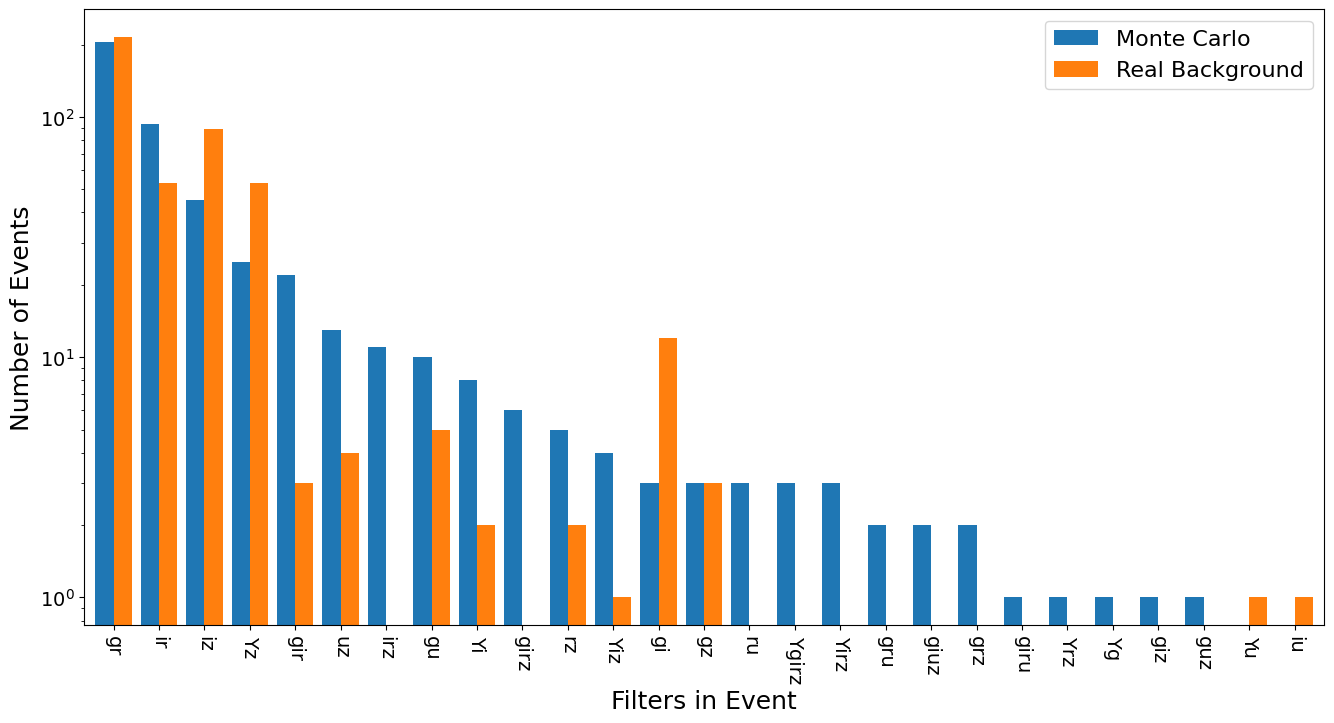

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))
filter_seq_hist_df.plot.bar(ax=ax, width=0.8)
ax.set_yscale("log")
ax.set_xlabel("Filters in Event", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-90)
ax.legend(loc="upper right", fontsize=16)
# fig.savefig(f"{fig_dir}filters_in_event_mc.png")
plt.show(fig)

In [6]:
filter_seq_hist_df.sum(axis=0)

Monte Carlo        473.0
Real Background    443.0
dtype: float64

In [7]:
ev_per_source = count_events_per_source(results_df)
n_per_source_hist = ev_per_source.value_counts()
n_per_source_hist.loc[0] = lc_class_df["lightcurve_class"].value_counts()["unimodal"]
n_per_source_hist.name = "Monte Carlo"

ev_per_source_irl = count_events_per_source(results_df_irl)
n_per_source_hist_irl = ev_per_source_irl.value_counts()
n_per_source_hist_irl.loc[0] = lc_class_df_irl["lightcurve_class"].value_counts()["unimodal"]
n_per_source_hist_irl.name = "Real Background"

ev_per_source_df = pd.concat([n_per_source_hist, n_per_source_hist_irl], axis=1)
ev_per_source_df.dropna(inplace=True)
ev_per_source_df.sort_index(inplace=True)

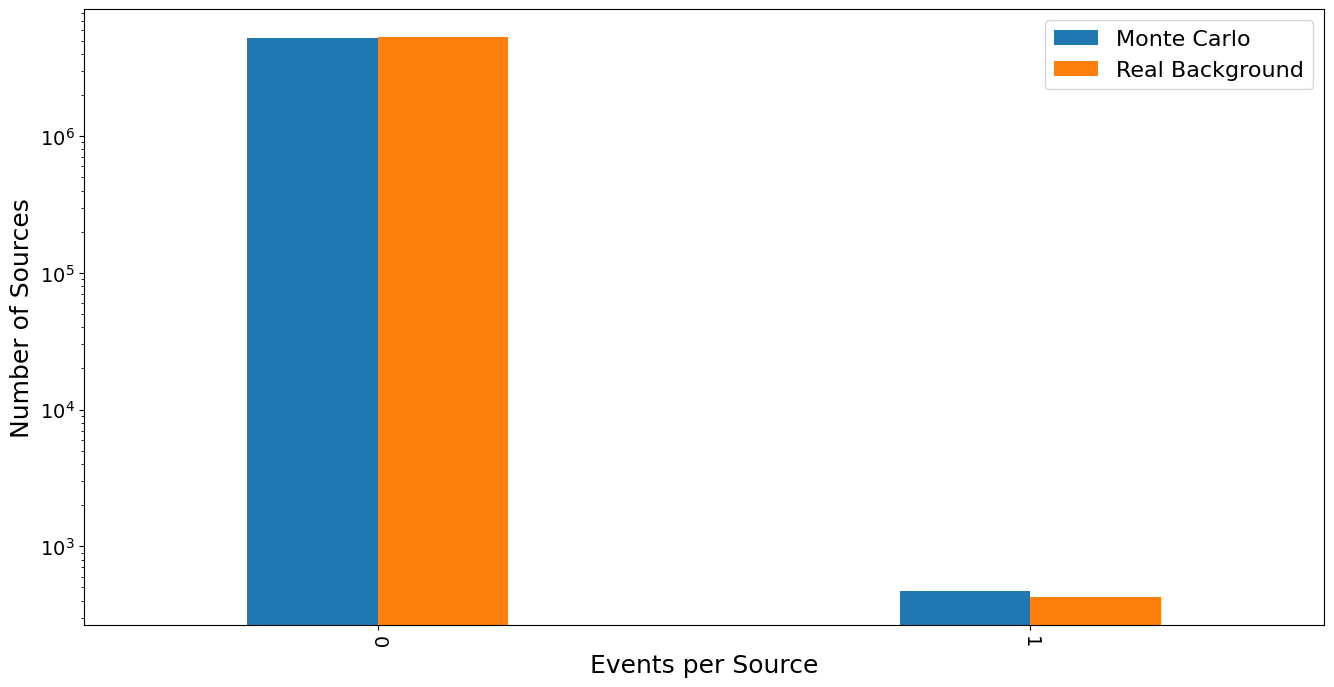

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
ev_per_source_df.plot.bar(ax=ax, width=0.4)
ax.set_yscale("log")
ax.set_xlabel("Events per Source", fontsize=18)
ax.set_ylabel("Number of Sources", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-90)
ax.legend(loc="upper right", fontsize=16)
# fig.savefig(f"{fig_dir}events_per_source_mc.png")
plt.show(fig)

In [9]:
from scipy.stats import binomtest

In [20]:
k = ev_per_source_df.loc[1, "Monte Carlo"].astype(int)
n = ev_per_source_df["Monte Carlo"].sum().astype(int)
p = ev_per_source_df.loc[1, "Real Background"] / ev_per_source_df["Real Background"].sum()
binomtest(k, n, p=p, alternative="greater").pvalue + binomtest(k, n, p=p, alternative="less").pvalue

1.0009358610243977

In [150]:
t = ev_per_source_df.copy()
t.loc[1, "Monte Carlo"] -= 50

In [164]:
fisher_exact(ev_per_source_df.values.astype(int))

SignificanceResult(statistic=0.8919841522675619, pvalue=0.08847758109196593)

In [168]:
g_test(hist_counts[0][hist_counts[0] > 0], hist_counts[1][hist_counts[1] > 0])

{'g': 281.2309233883638, 'p': 0.0}

In [171]:
results_df_irl.loc[results_df_irl["filters"].str.len() > 2]

t_start_max     t_end_max   t_start_min     t_end_min  \
objectid                                                                  
181017_1990   0  56270.354454  56282.168166  56282.153491  56282.156746   
189585_42863  0  57000.047318  57057.093995  57000.054248  57000.070199   
190049_146765 0  57432.193051  57432.196479  57432.193402  57432.196145   
192136_22350  0  57009.286674  57009.295183  57009.292113  57009.294844   

                filters  achromatic  multiplicity_2  n_bright  
objectid                                                       
181017_1990   0     izY        True           False         3  
189585_42863  0     gri        True           False         3  
190049_146765 0     gri        True           False         3  
192136_22350  0     gri        True           False         3

In [173]:
results_df_irl.loc[results_df_irl["n_bright"] > 2]

t_start_max     t_end_max   t_start_min     t_end_min  \
objectid                                                                  
181017_1990   0  56270.354454  56282.168166  56282.153491  56282.156746   
189585_42863  0  57000.047318  57057.093995  57000.054248  57000.070199   
190049_146765 0  57432.193051  57432.196479  57432.193402  57432.196145   
192136_22350  0  57009.286674  57009.295183  57009.292113  57009.294844   

                filters  achromatic  multiplicity_2  n_bright  
objectid                                                       
181017_1990   0     izY        True           False         3  
189585_42863  0     gri        True           False         3  
190049_146765 0     gri        True           False         3  
192136_22350  0     gri        True           False         3

In [179]:
q = """SELECT umag, gmag, rmag, imag, zmag, ymag FROM nsc_dr2.object WHERE id = '192136_22350'"""
qc.query(sql=q, fmt="pandas")

umag      gmag       rmag       imag       zmag   ymag
0  21.974447  20.90636  20.908352  20.871496  20.897032  99.99

In [93]:
taus = np.geomspace(1e-4, 1e4, num=50)
hist_counts = np.zeros((2, len(taus)))

dfs = [results_df, results_df_irl]

for j in range(len(dfs)):
    df = dfs[j]
    t_matrix = df[["t_start_max", "t_start_min", "t_end_min", "t_end_max"]].values

    for i in range(t_matrix.shape[0]):
        ts = t_matrix[i]
        post = integrated_event_duration_posterior(taus, ts)
        hist_counts[j] += post

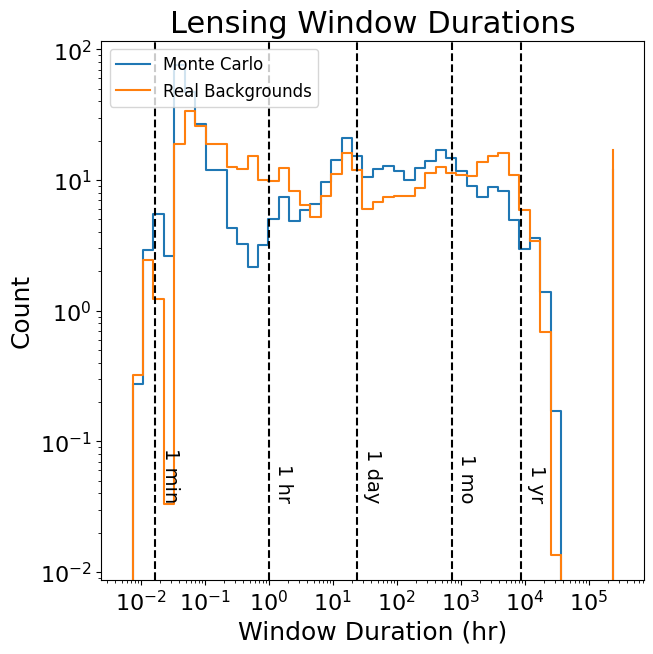

In [94]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 
                            60 * 60 * 24 * 30, 
                            60 * 60 * 24 * 365]) * (1 / 60**2))
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
x = taus * 24
labels = ["Monte Carlo", "Real Backgrounds"]

fig, ax = plt.subplots(figsize=(7, 7))

for i in range(len(labels)):
    h = hist_counts[i]
    label = labels[i]
    ax.plot(x, h, ds="steps-post", label=label)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((x[0], 3*x[-1]))
ax.legend(loc="upper left", fontsize=12)
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.15)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations_mc.png")
plt.close(fig)

In [163]:
g_test(hist_counts[0, 3:44], hist_counts[1, 3:44])

{'g': 289.59028405080096, 'p': 0.0}

In [186]:
er_df.loc["rate"].values

array([           nan,            nan,            nan,            inf,
       2.82754919e-02, 1.66283483e-03, 1.01479120e-05, 3.63924835e-03,
       1.38528302e-03, 7.03218899e-04, 1.63031010e-04, 5.13745275e-05,
       1.63018995e-05, 8.81824868e-06, 6.83134246e-06, 2.81063931e-06,
       1.94243042e-06, 1.58754649e-06, 7.16396309e-07, 4.37932140e-07,
       2.70242655e-07, 2.87651329e-07, 3.03414735e-07, 3.15360773e-07,
       1.67999007e-07, 6.25581082e-08, 5.51784661e-08, 4.47877505e-08,
       3.32538828e-08, 2.40503707e-08, 2.03368647e-08, 1.92560838e-08,
       1.52056428e-08, 9.73388348e-09, 7.50870927e-09, 5.86182191e-09,
       5.96413385e-09, 5.26004778e-09, 4.36853493e-09, 2.34943404e-09,
       1.09057505e-09, 6.21790268e-10, 1.24604583e-10, 3.05374702e-12,
       0.00000000e+00, 0.00000000e+00,            nan,            nan,
                  nan,            inf])

In [189]:
np.geomspace(1e-4, 1e4, num=50)[er_df.loc["rate"].values > 1e-3] * 86400

array([2.66876087e+01, 3.88664583e+01, 5.66031073e+01, 1.20052411e+02,
       1.74838146e+02, 8.64000000e+08])

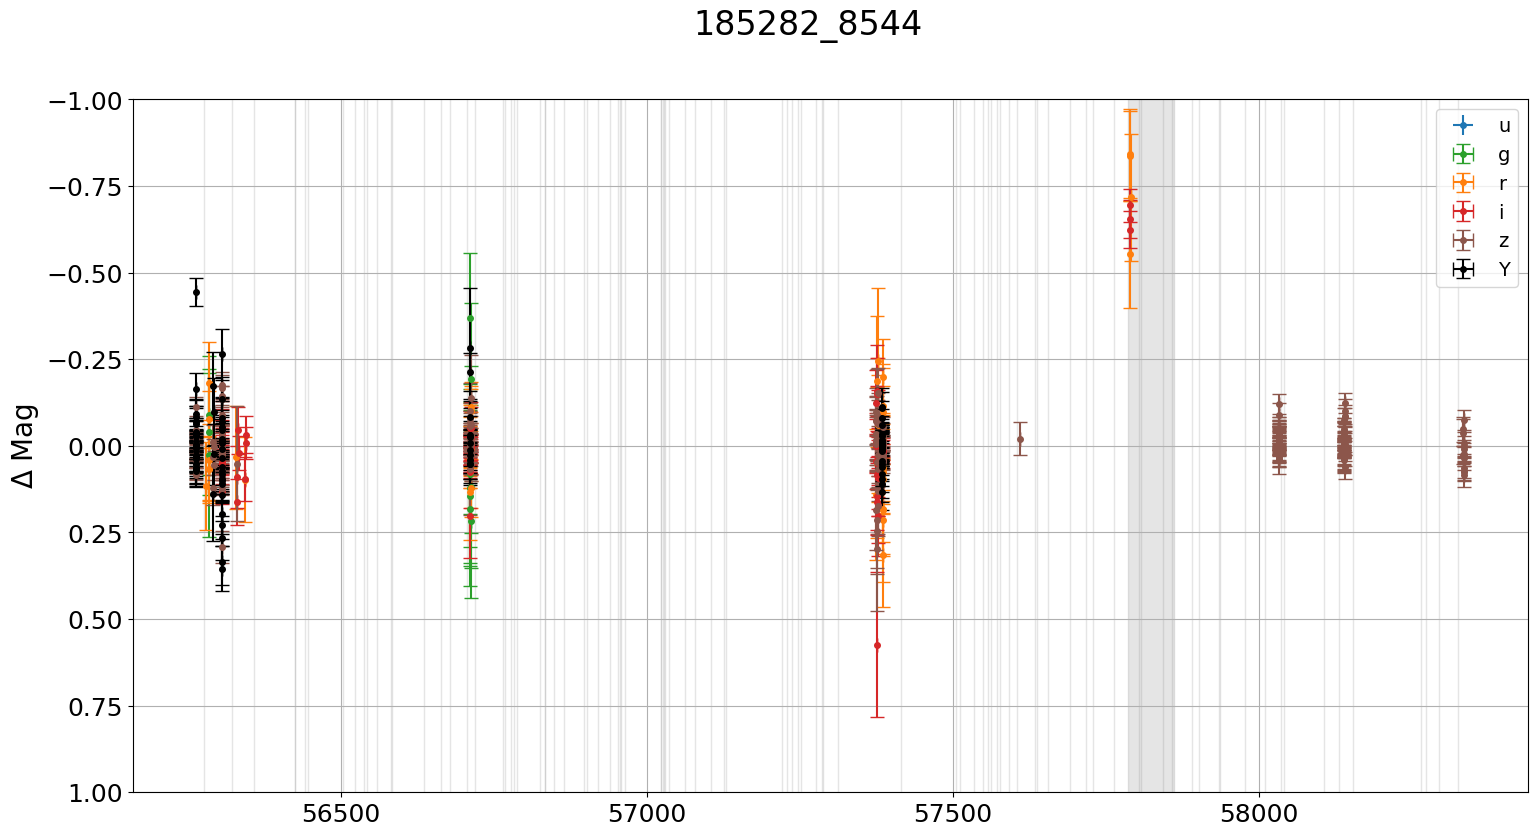

In [182]:
er_df = pd.read_parquet(f"{base_dir}/results/12aug2024/event_rates.parquet")
rates = er_df.loc["rate"]
taus = np.geomspace(1e-4, 1e4, num=50)
m = np.isfinite(rates)
rates = rates[m]
taus = taus[m]
rng = np.random.default_rng(seed=9047851)
oids = lc_class_df.query("lightcurve_class == 'unstable'")["objectid"]

for oid in oids[1:2]:
    lc = lens_lc(oid, rates, taus, rng_state, rng)
    lc = cluster_label_dataframe(lc)
    g = lc.groupby(by=["objectid", "filter"], sort=False, group_keys=False)
    baseline_subtracted = subtract_baseline(g)
    fig = plot_lensed_lc(baseline_subtracted, taus, rng_state, rng,
                         mag_column="delta_mag",
                         magerr_column="delta_mag_err")
    ax = fig.get_axes()[0]
    ax.legend(fontsize=14, loc="upper right")
    ax.set_ylabel(r"$\Delta$ Mag", fontsize=20)
    ax.set_ylim((1, -1))
    fig.suptitle(f"{oid}", fontsize=24)
    plt.show(fig)
    plt.close(fig)

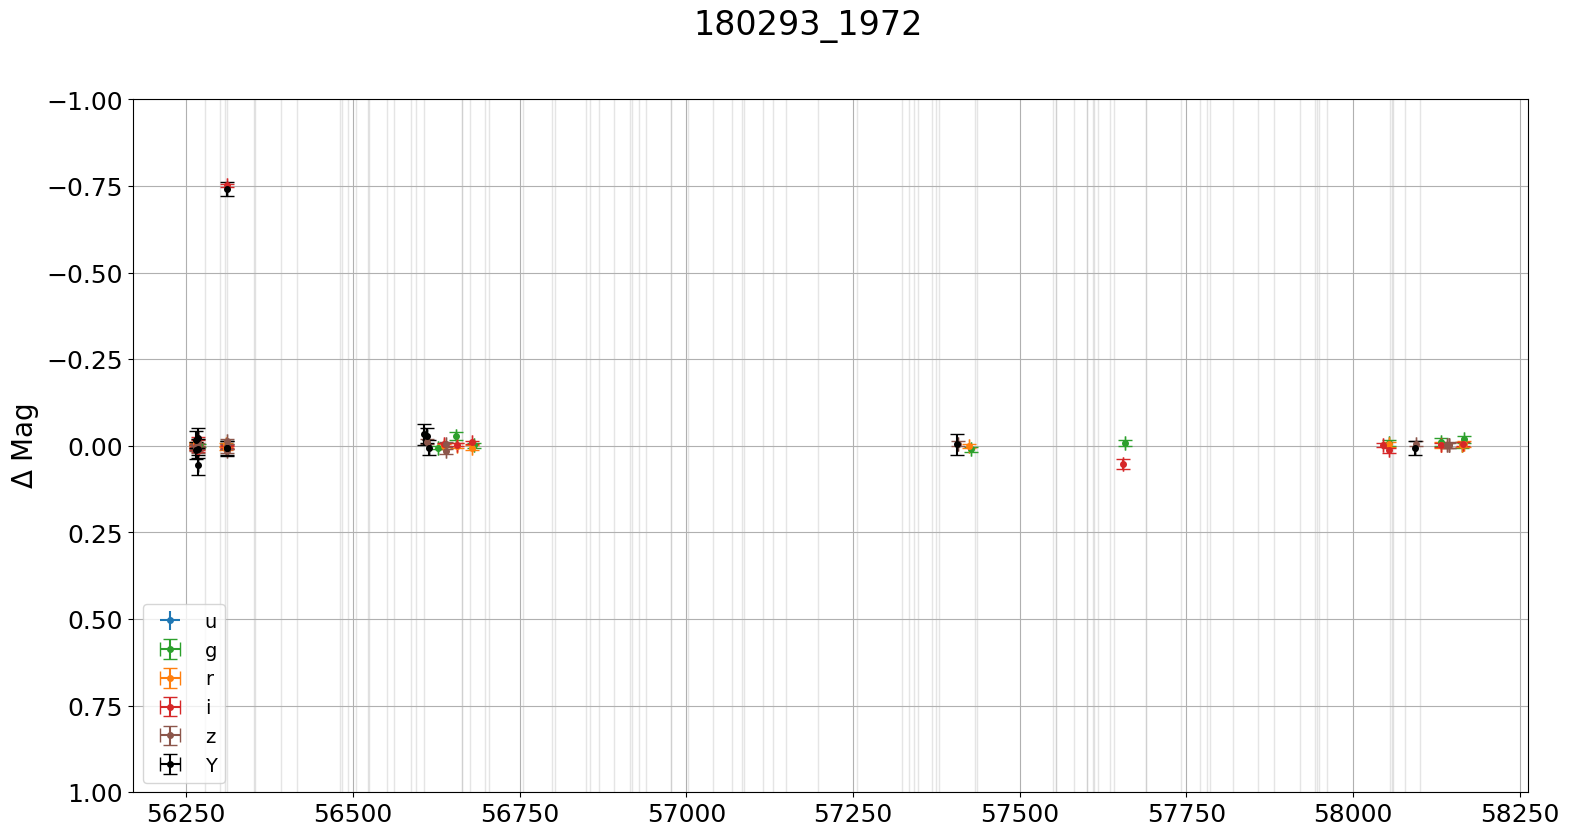

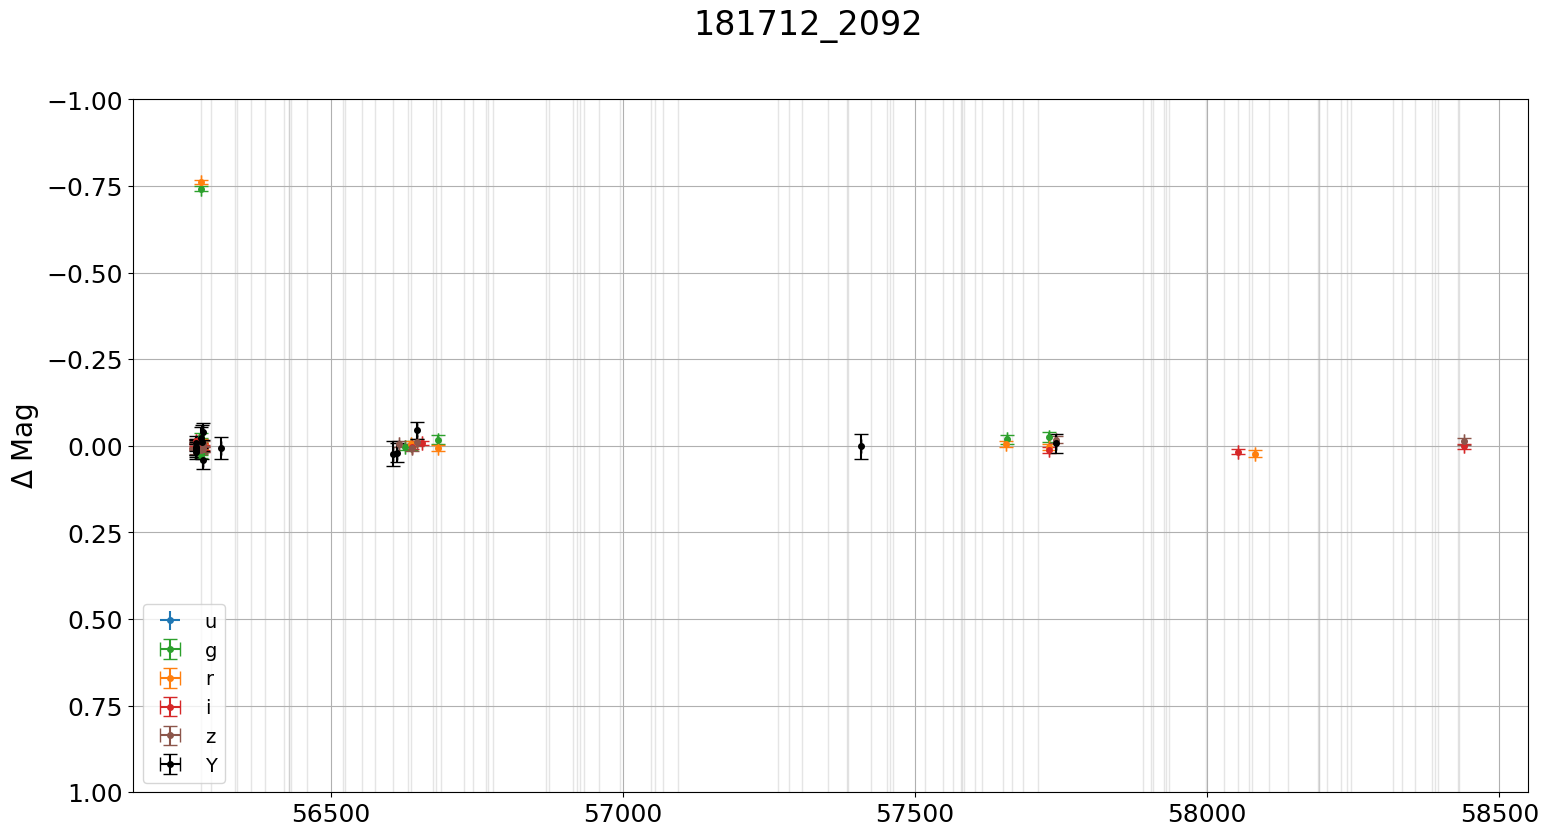

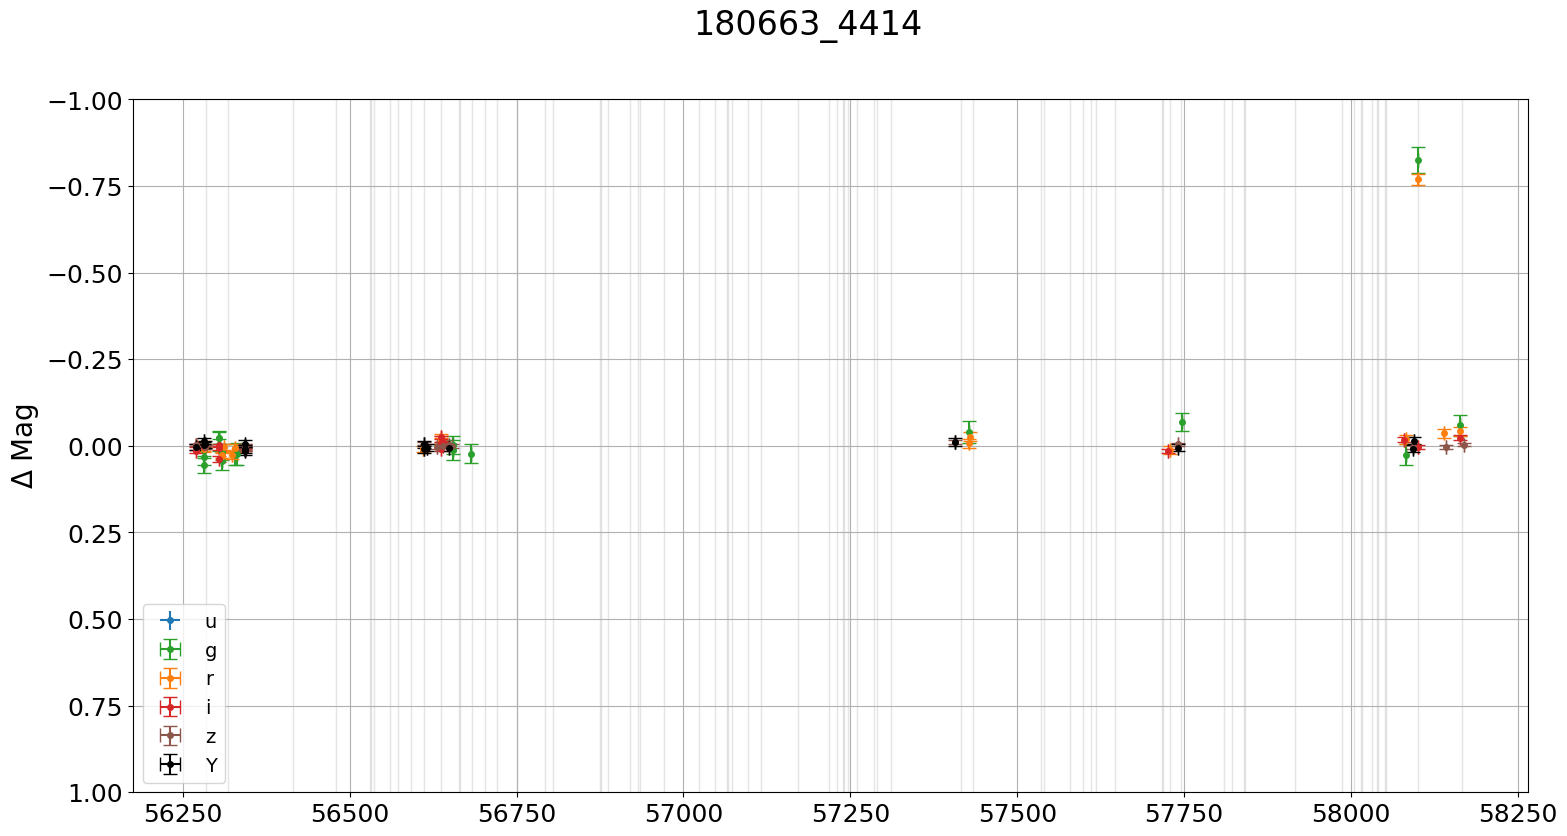

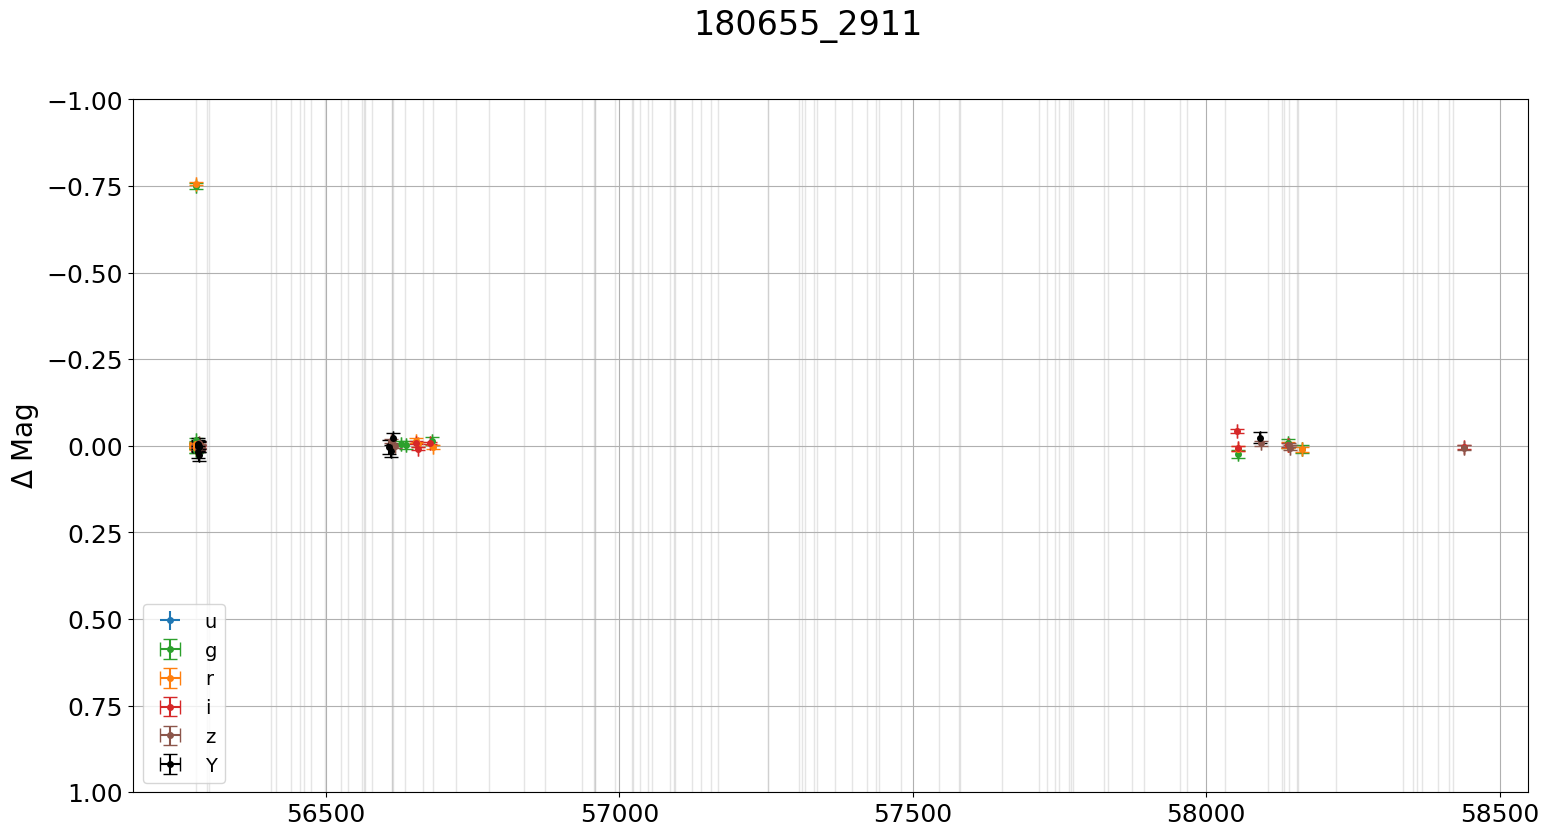

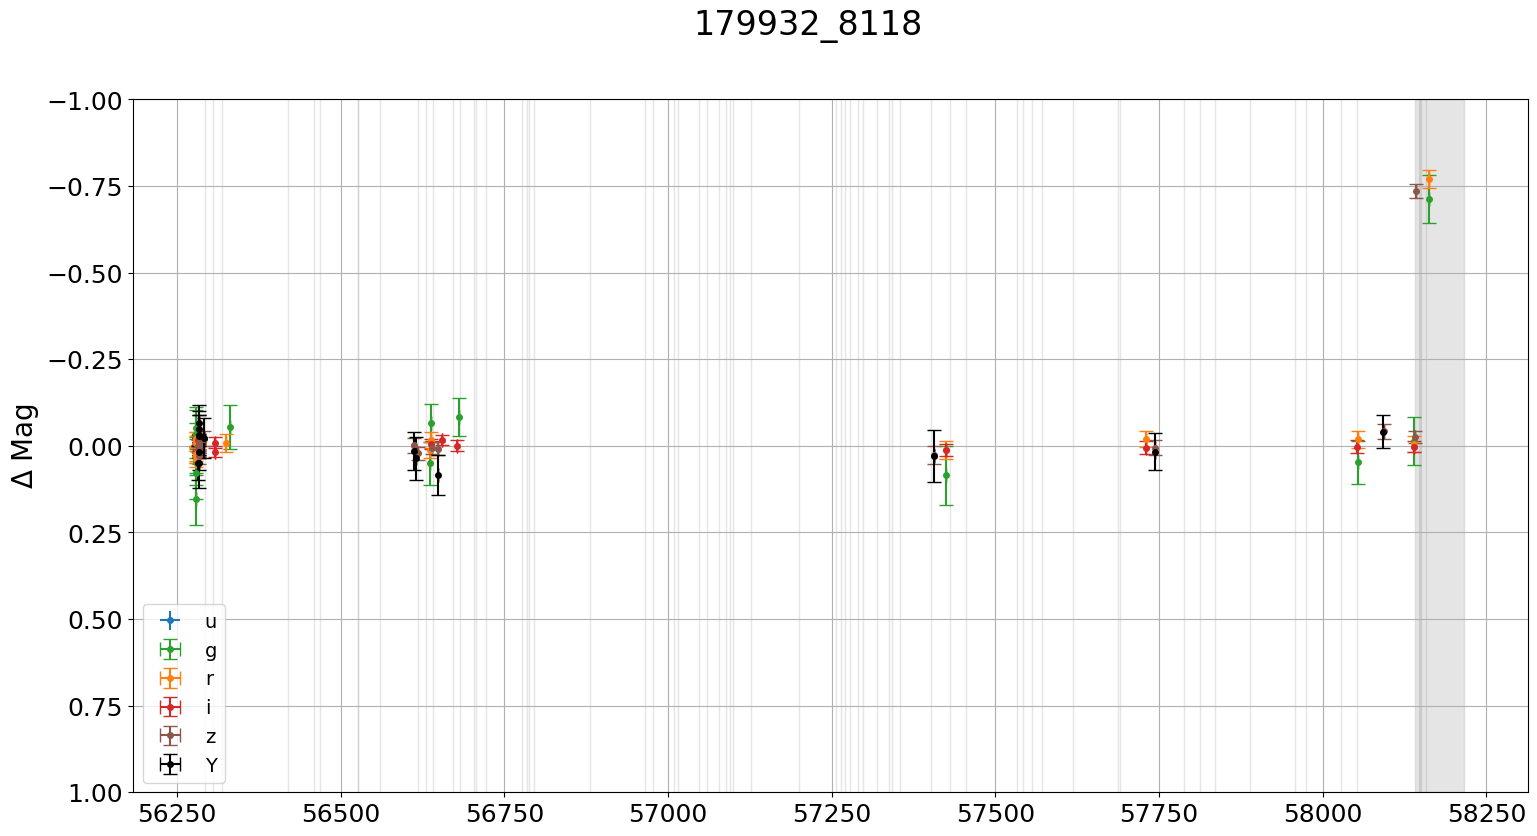

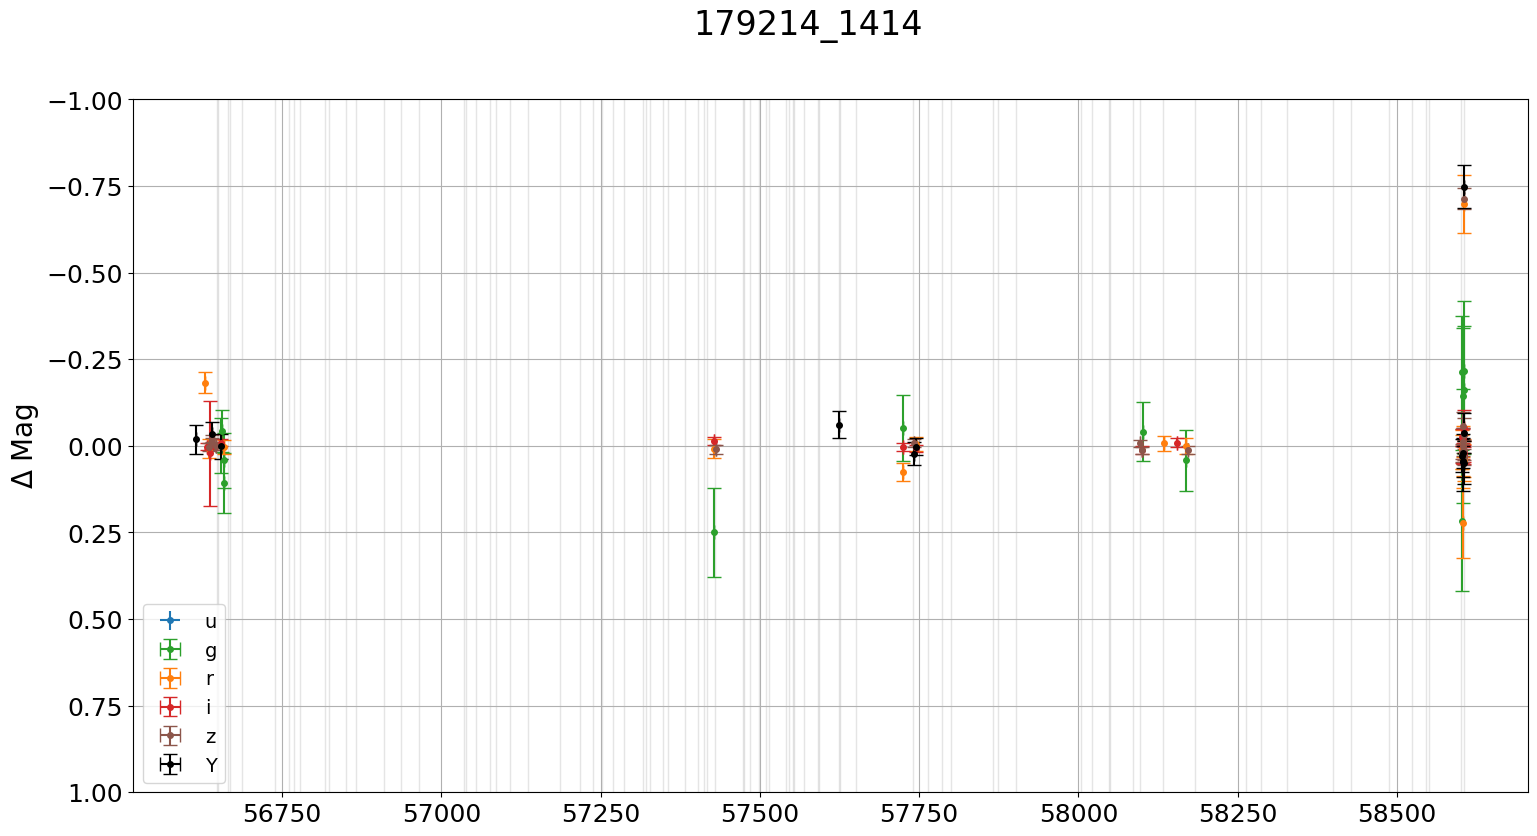

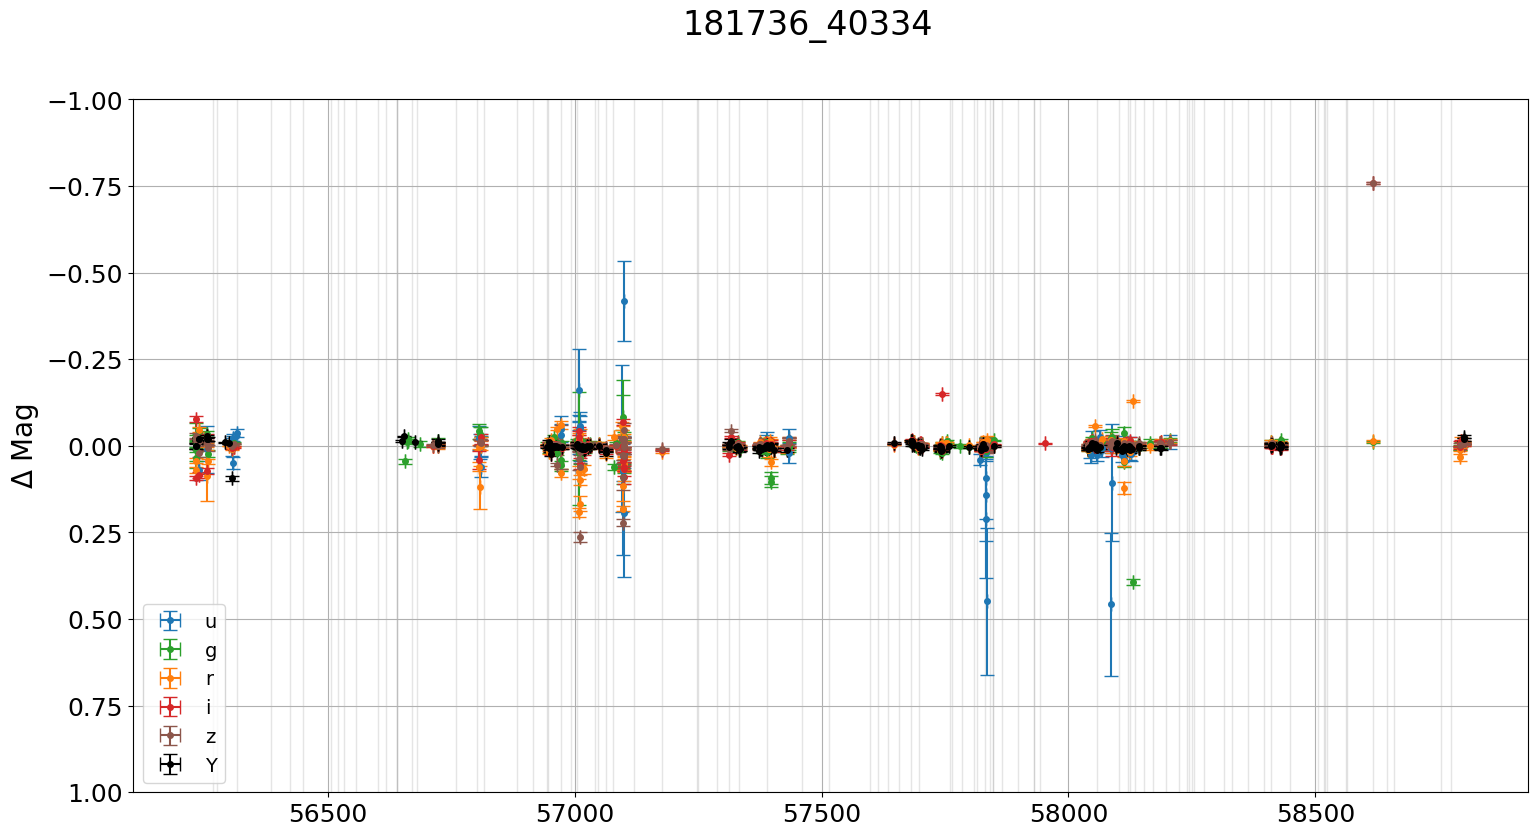

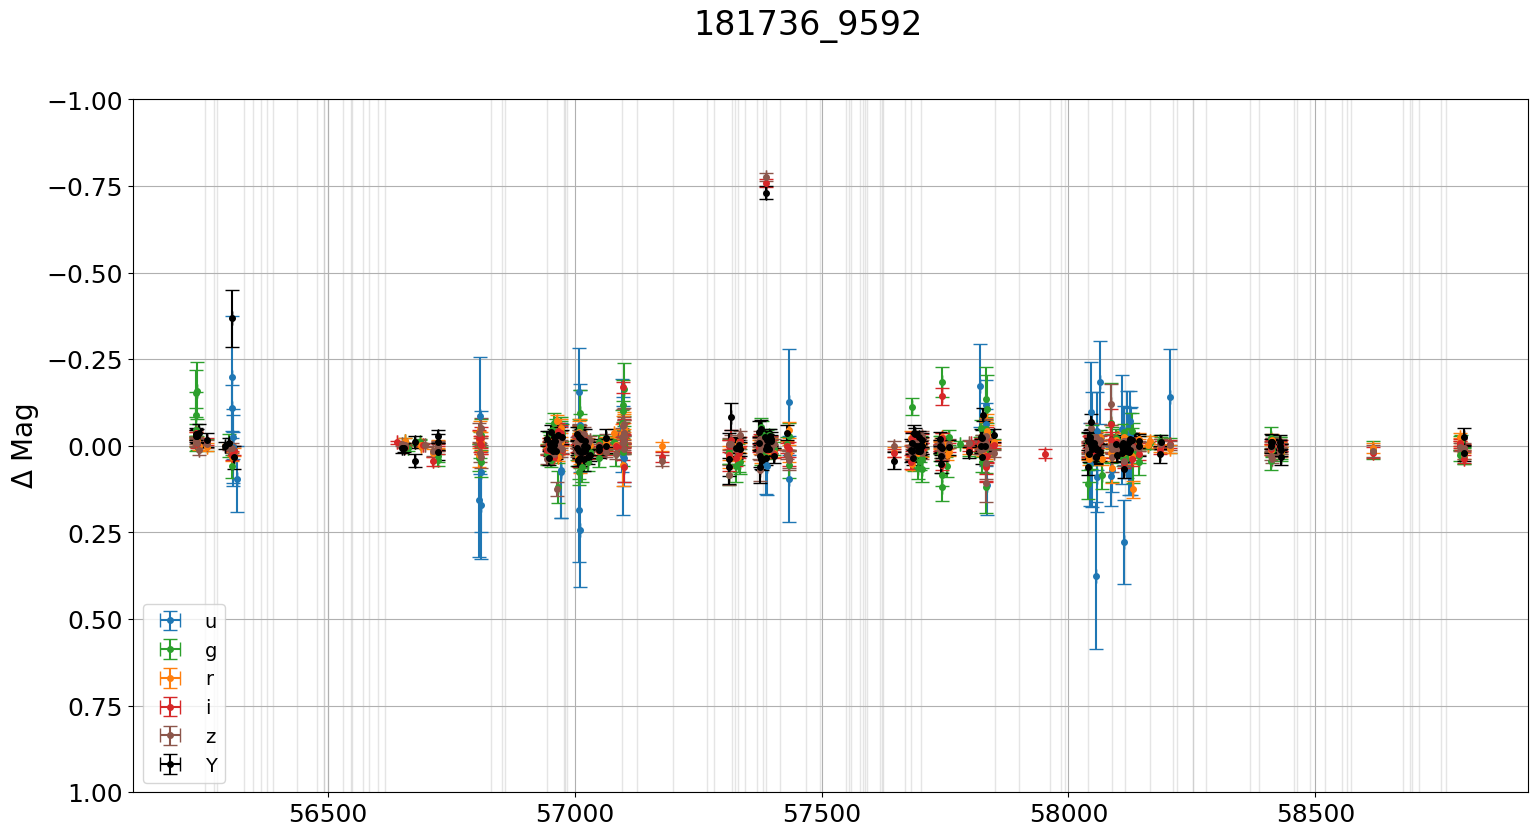

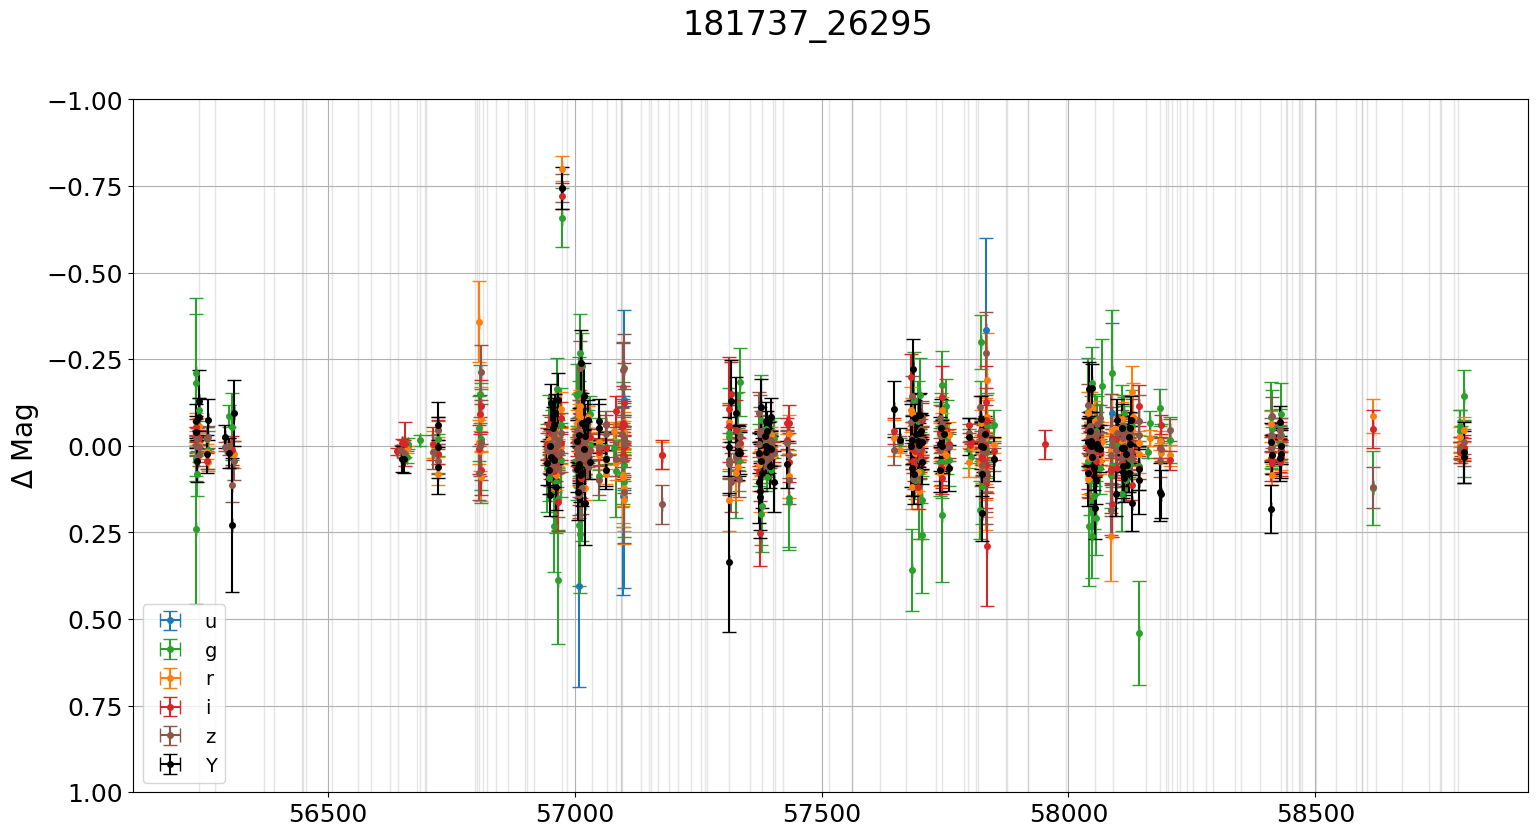

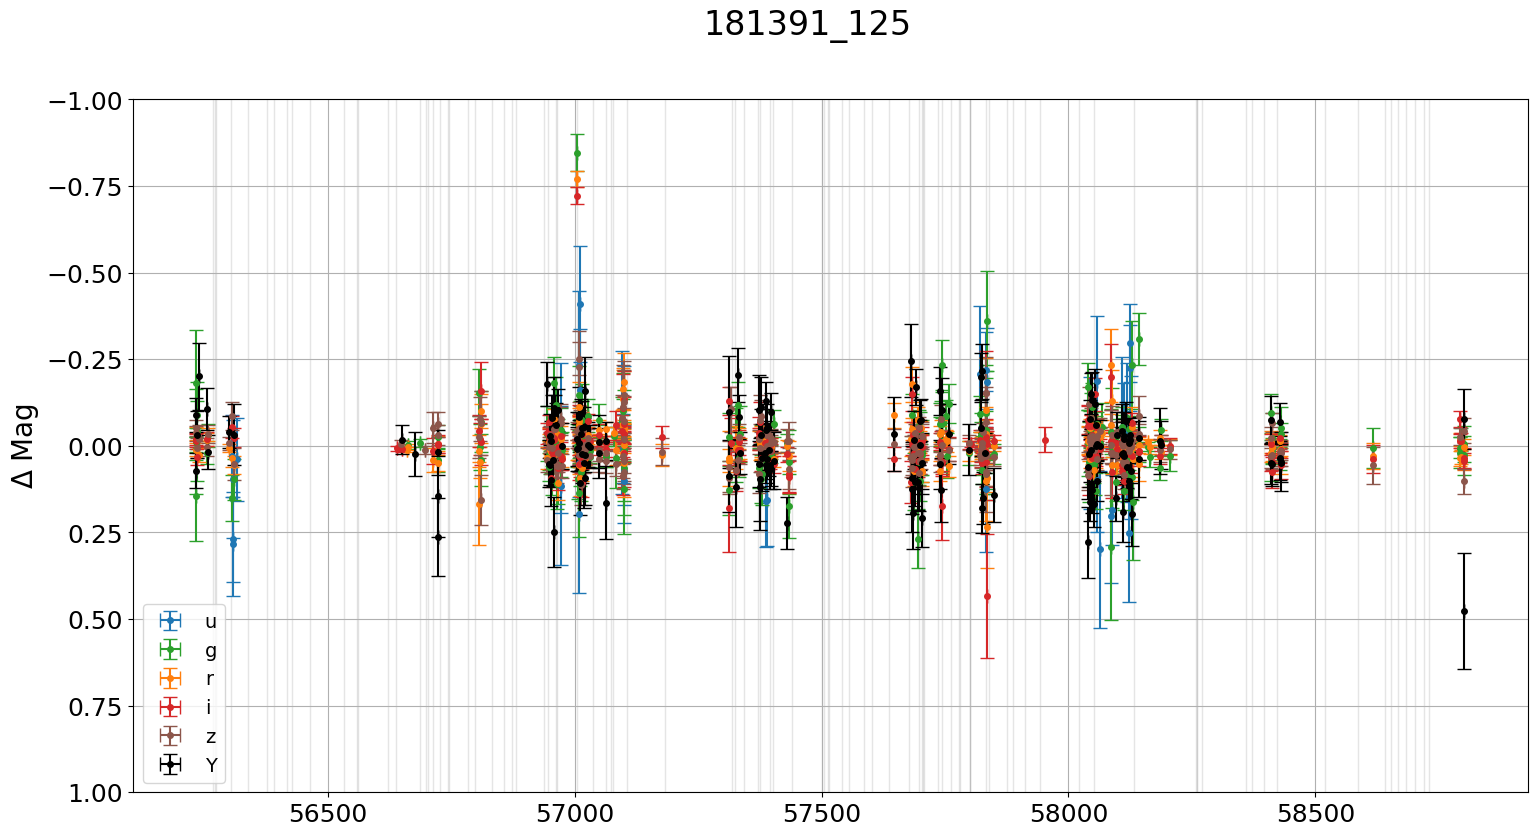

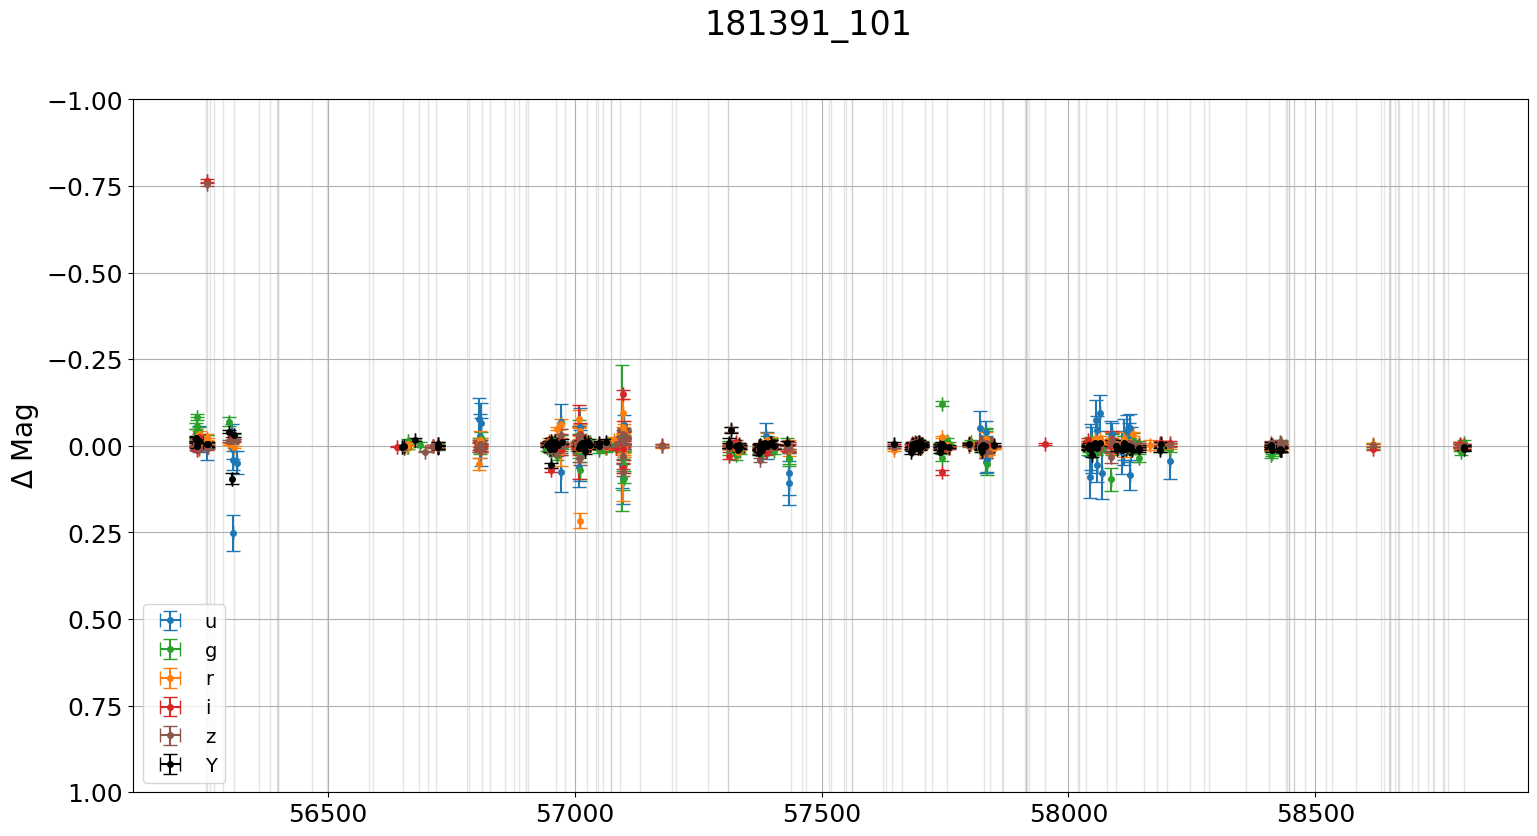

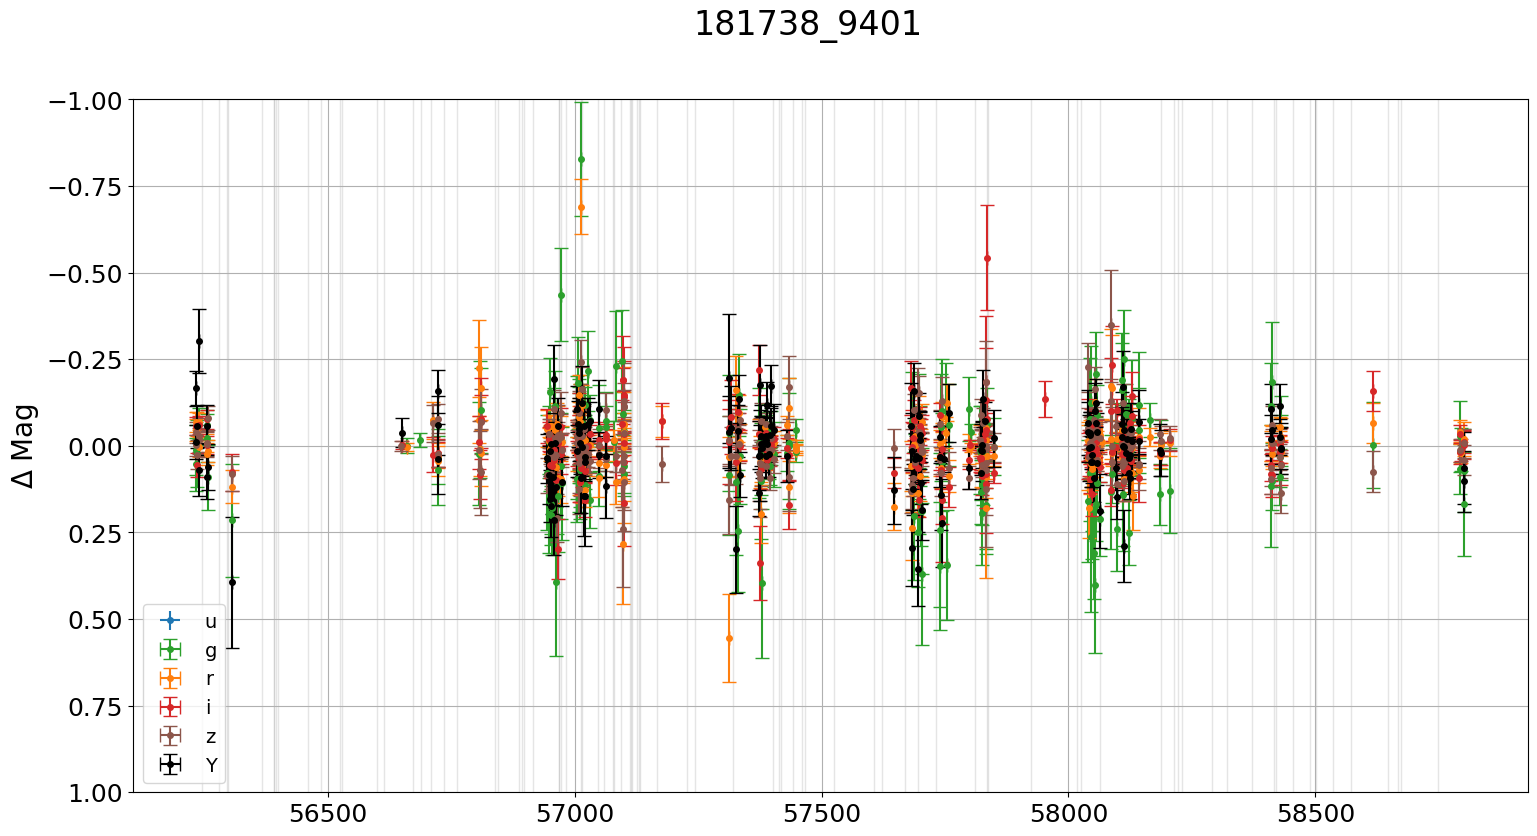

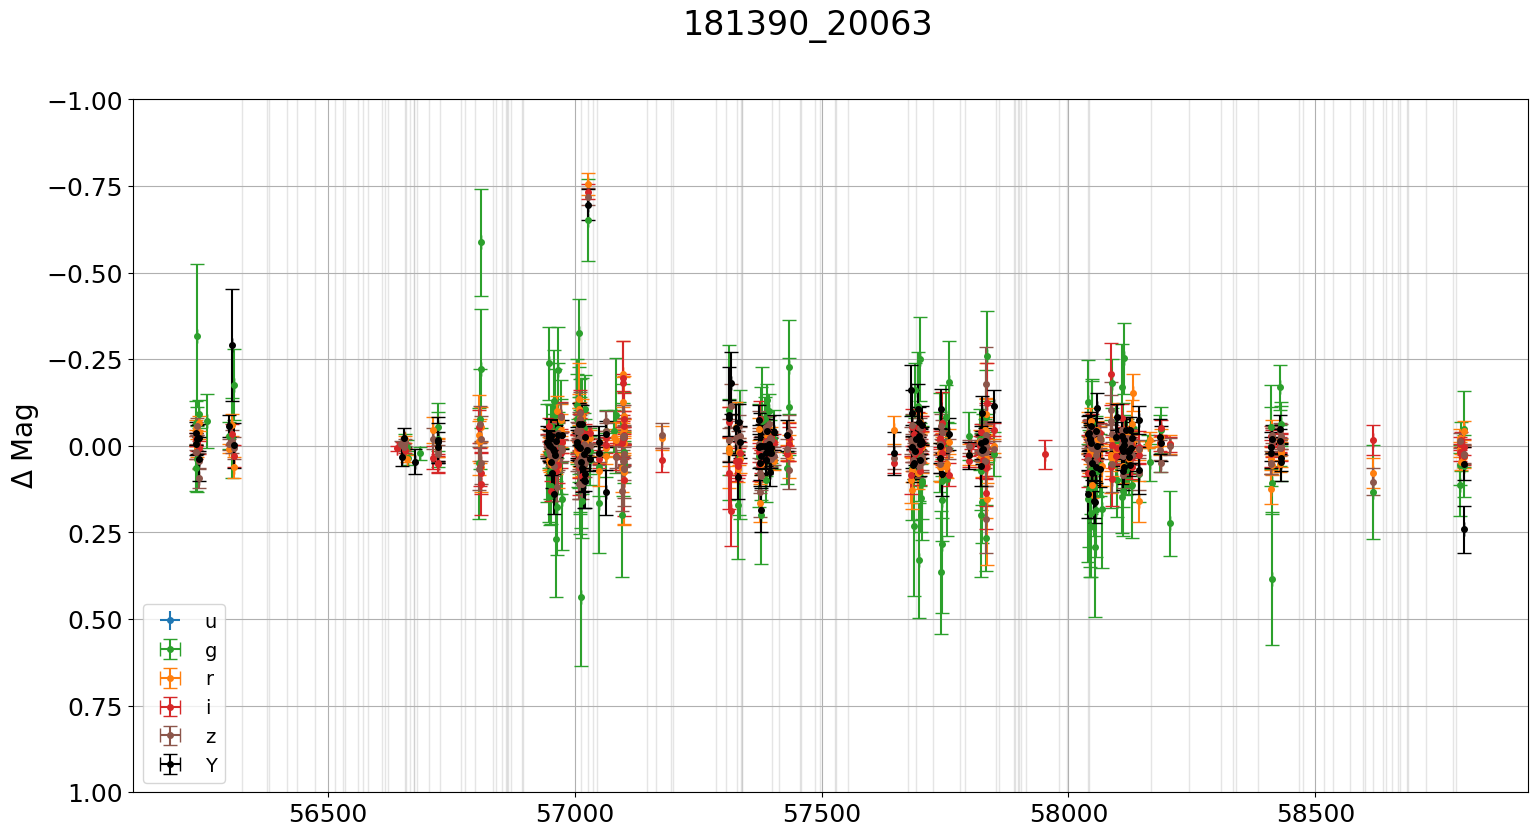

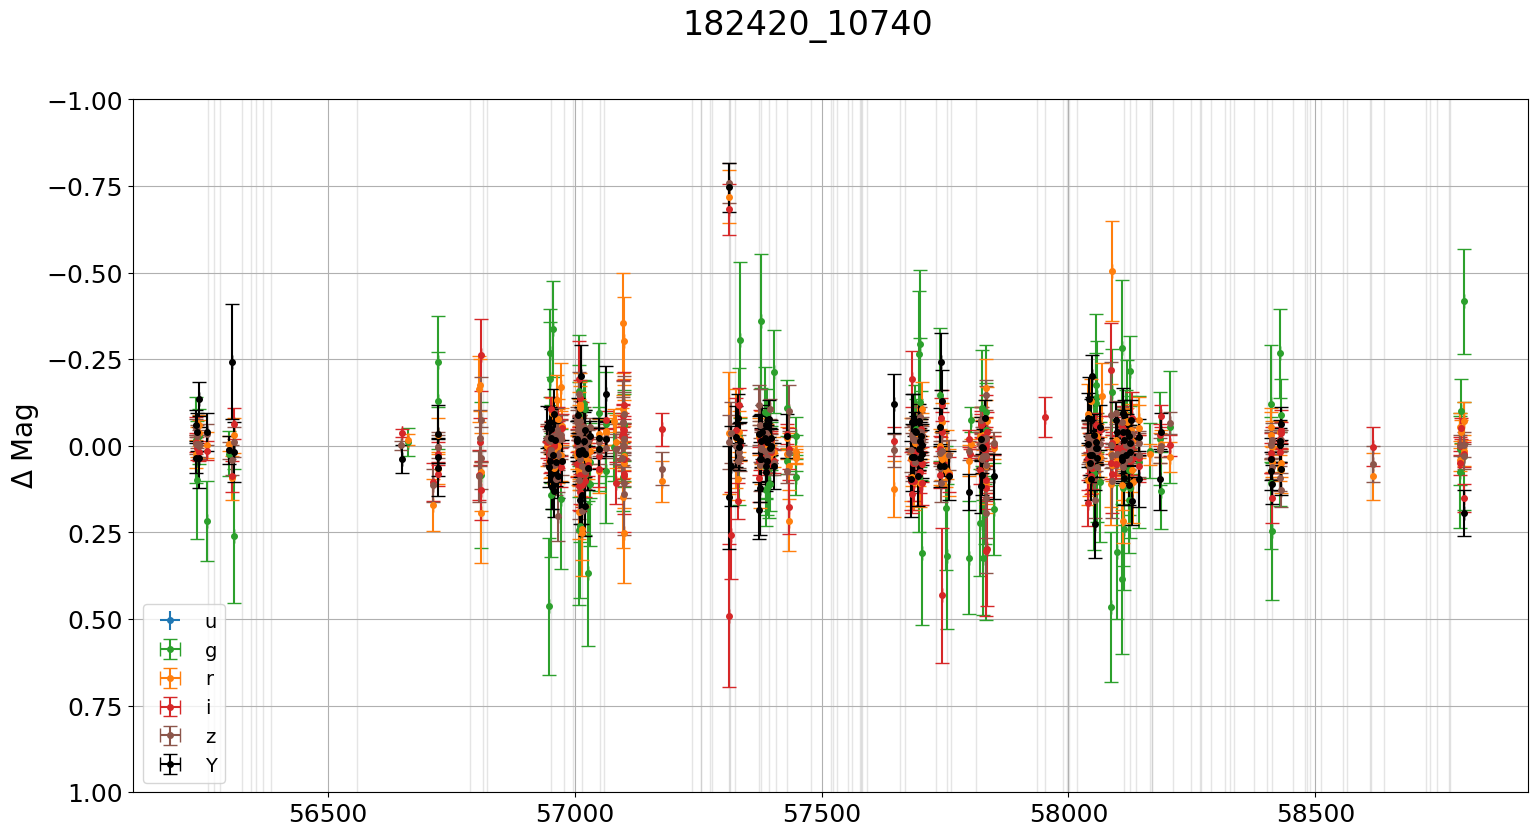

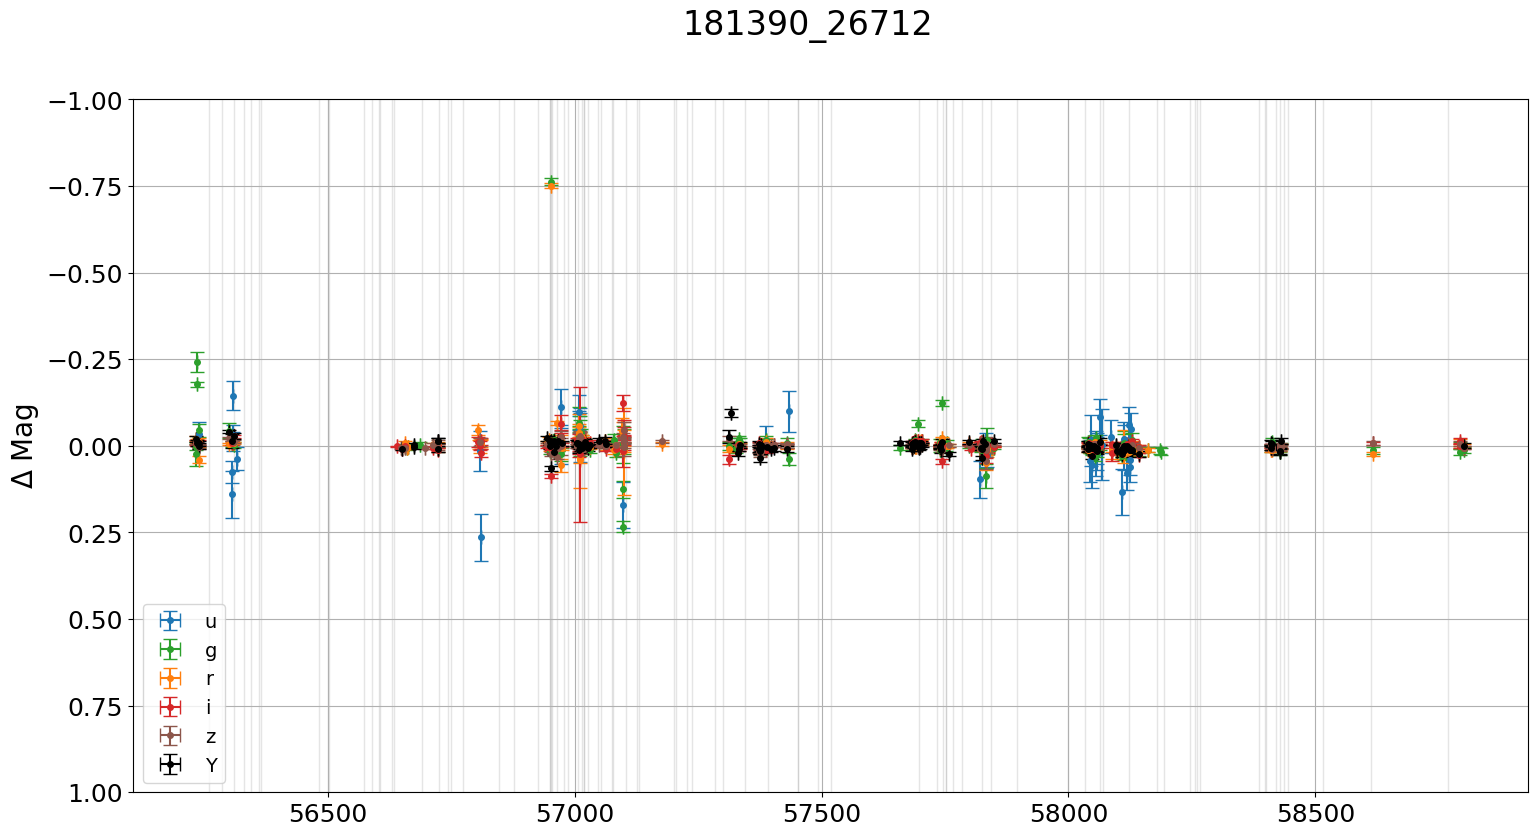

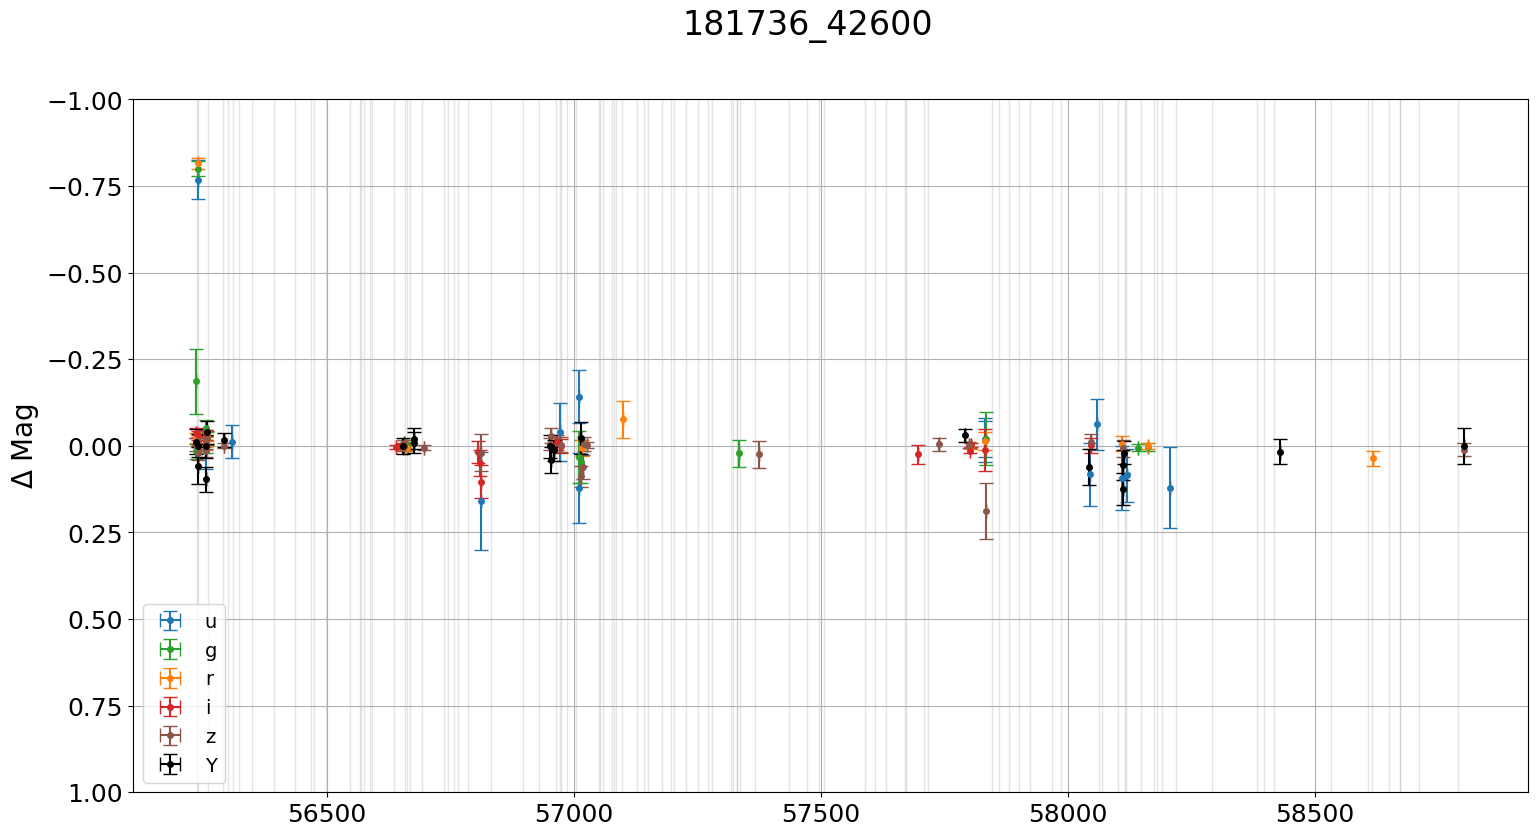

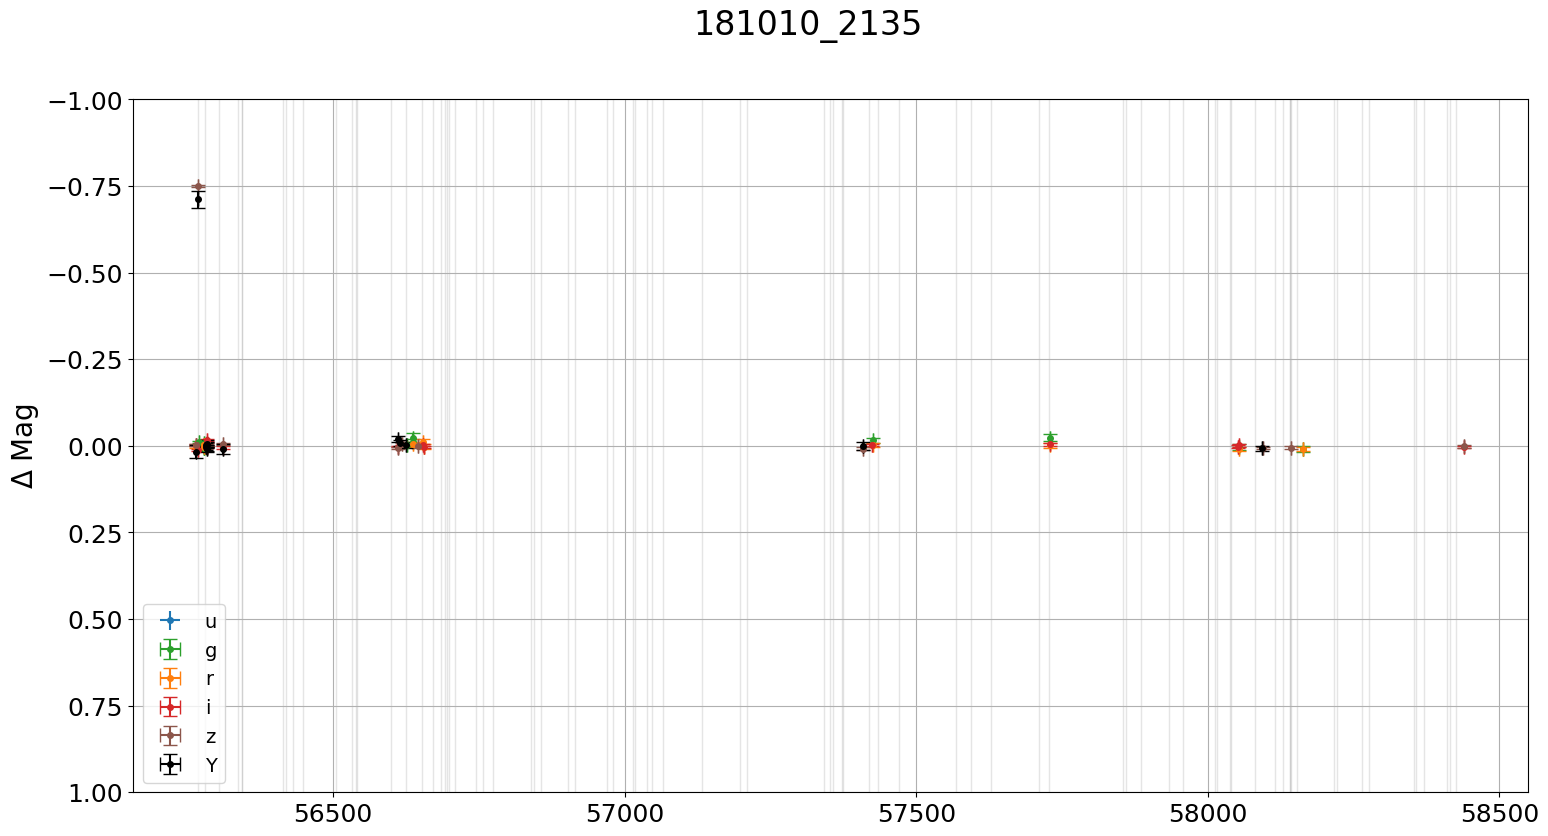

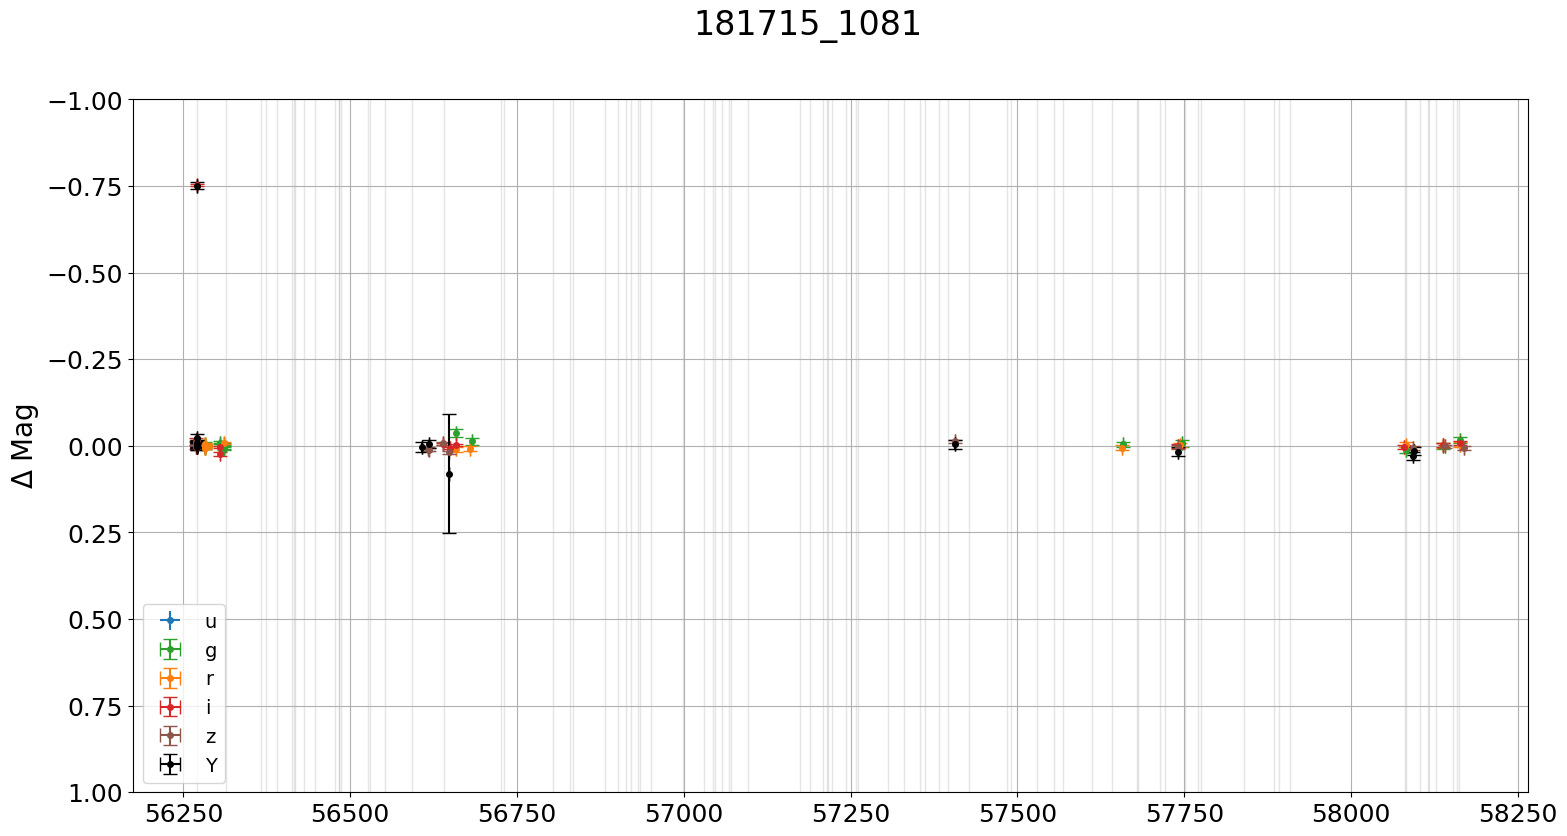

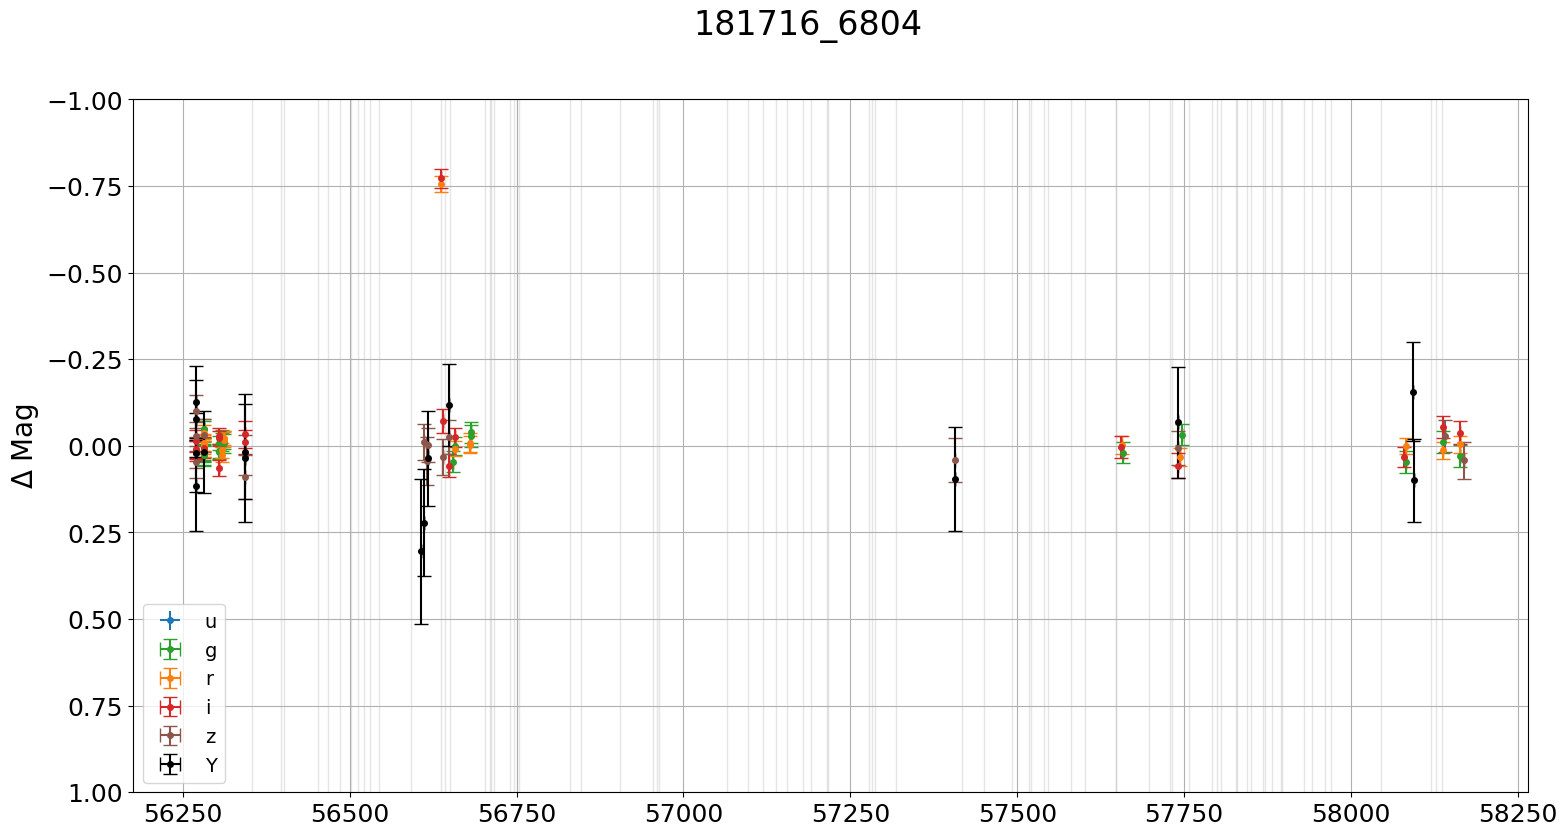

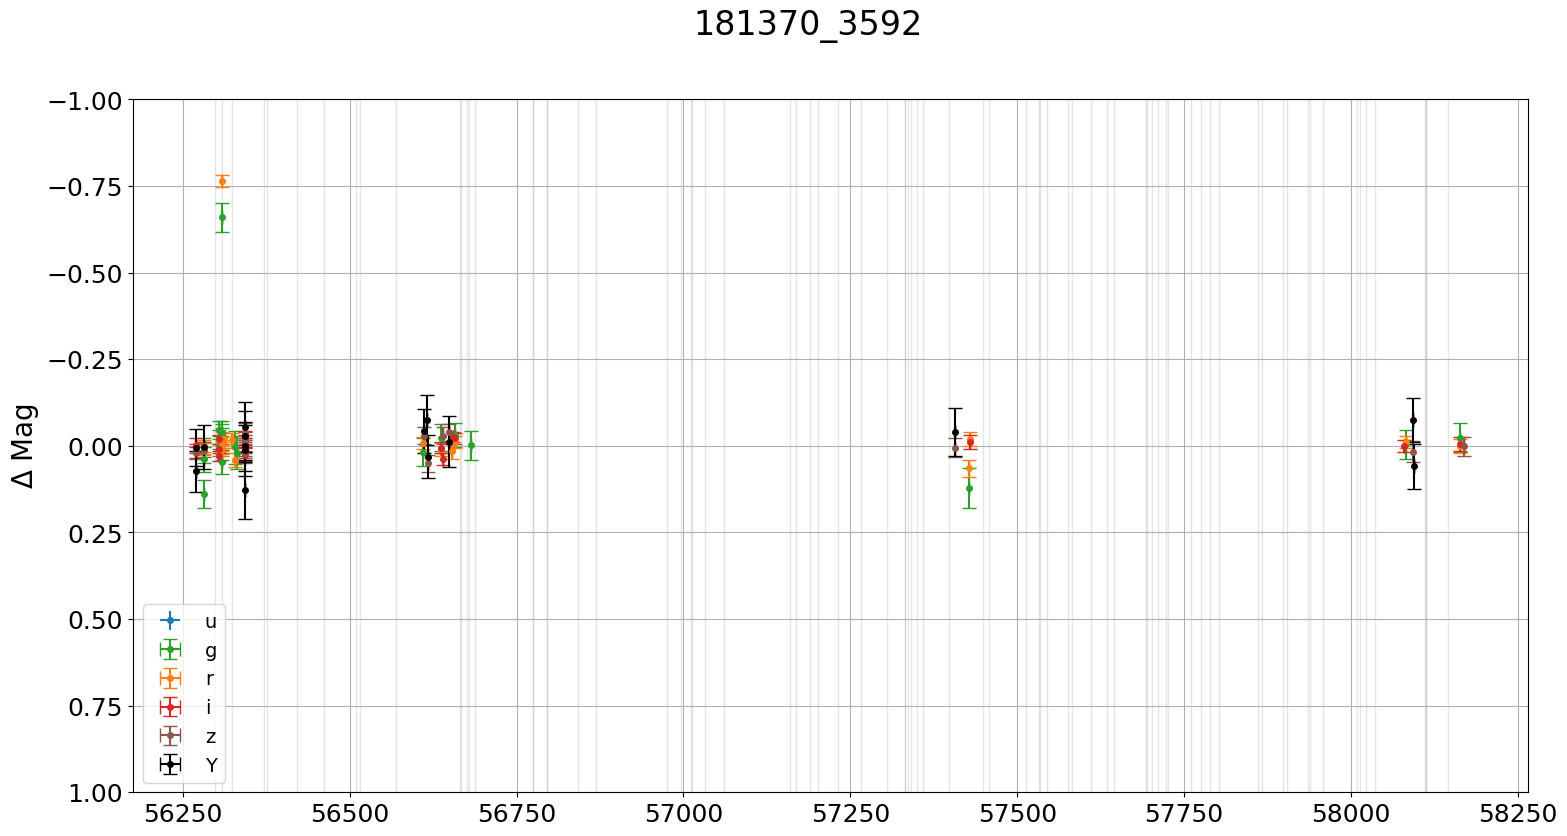

In [96]:
oids = lc_class_df.query("lightcurve_class == 'background'")["objectid"]

for oid in oids[:20]:
    lc = lens_lc(oid, rates, taus, rng_state, rng)
    lc = cluster_label_dataframe(lc)
    g = lc.groupby(by=["objectid", "filter"], sort=False, group_keys=False)
    baseline_subtracted = subtract_baseline(g)
    fig = plot_lensed_lc(baseline_subtracted, taus, rng_state, rng,
                         mag_column="delta_mag",
                         magerr_column="delta_mag_err")
    ax = fig.get_axes()[0]
    ax.legend(fontsize=14, loc="lower left")
    ax.set_ylabel(r"$\Delta$ Mag", fontsize=20)
    ax.set_ylim((1, -1))
    fig.suptitle(f"{oid}", fontsize=24)
    plt.show(fig)
    plt.close(fig)

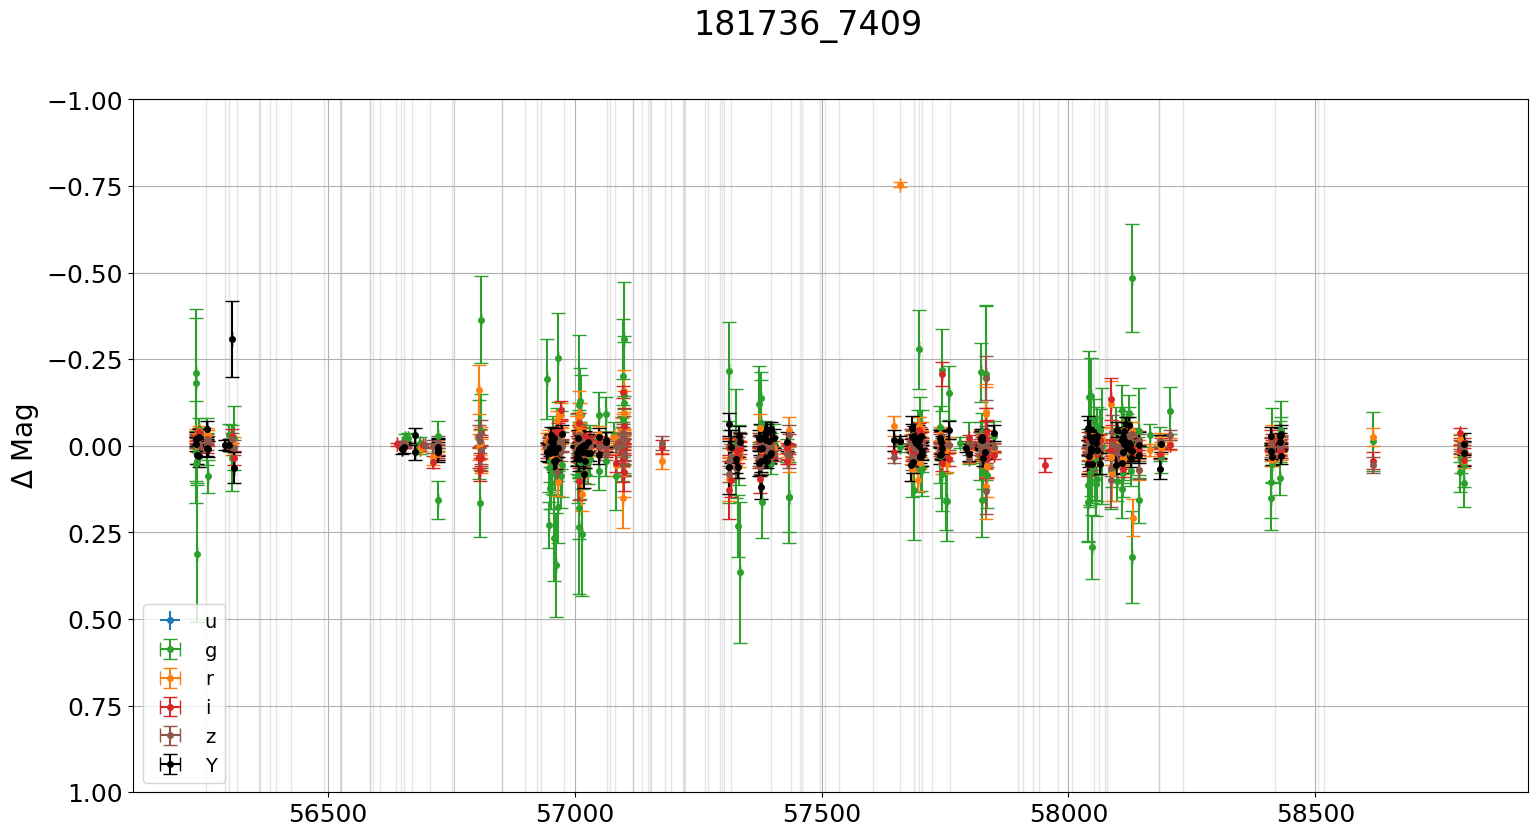

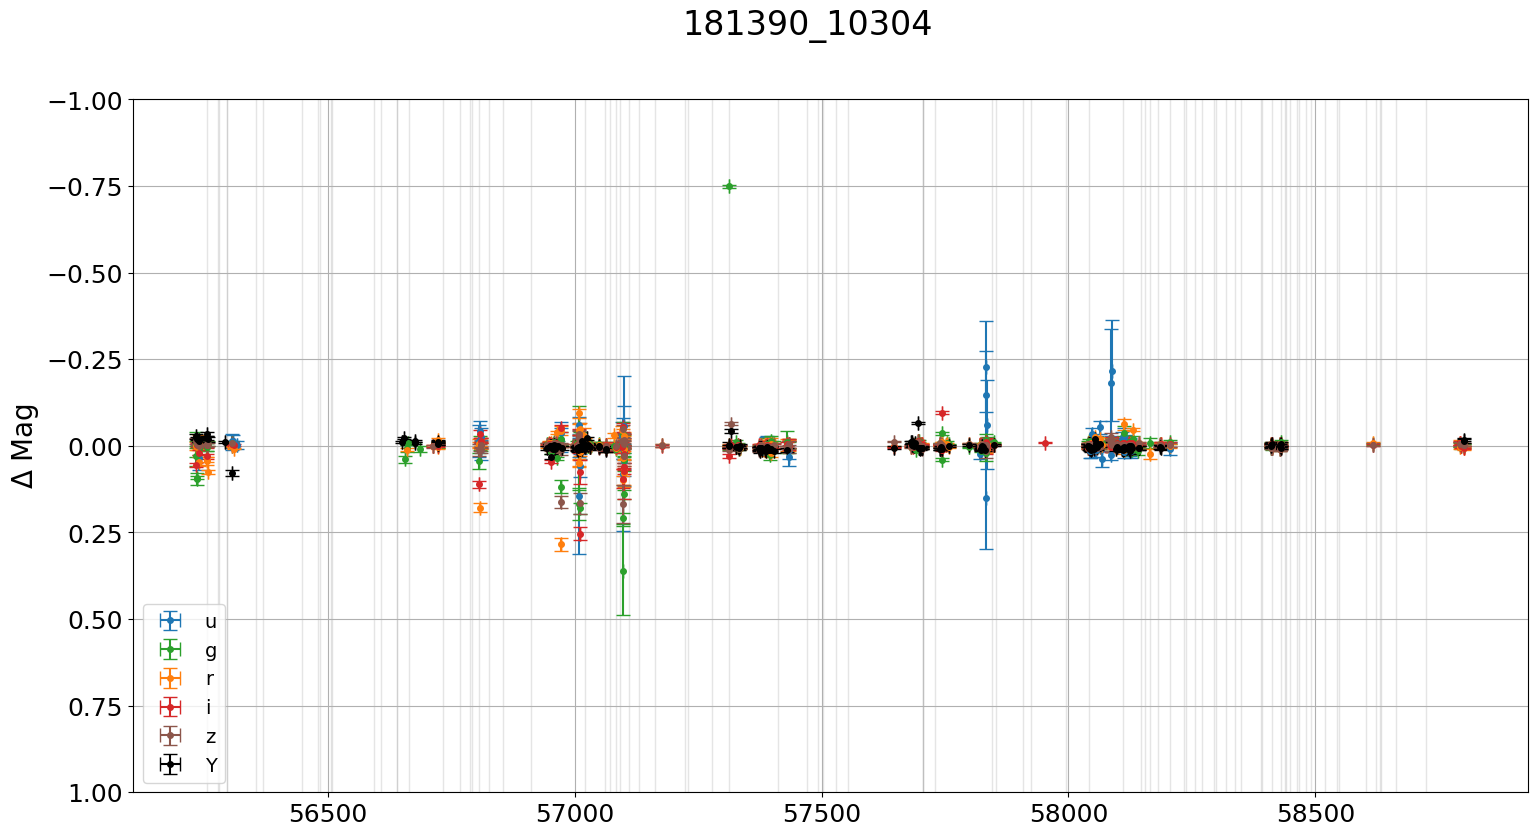

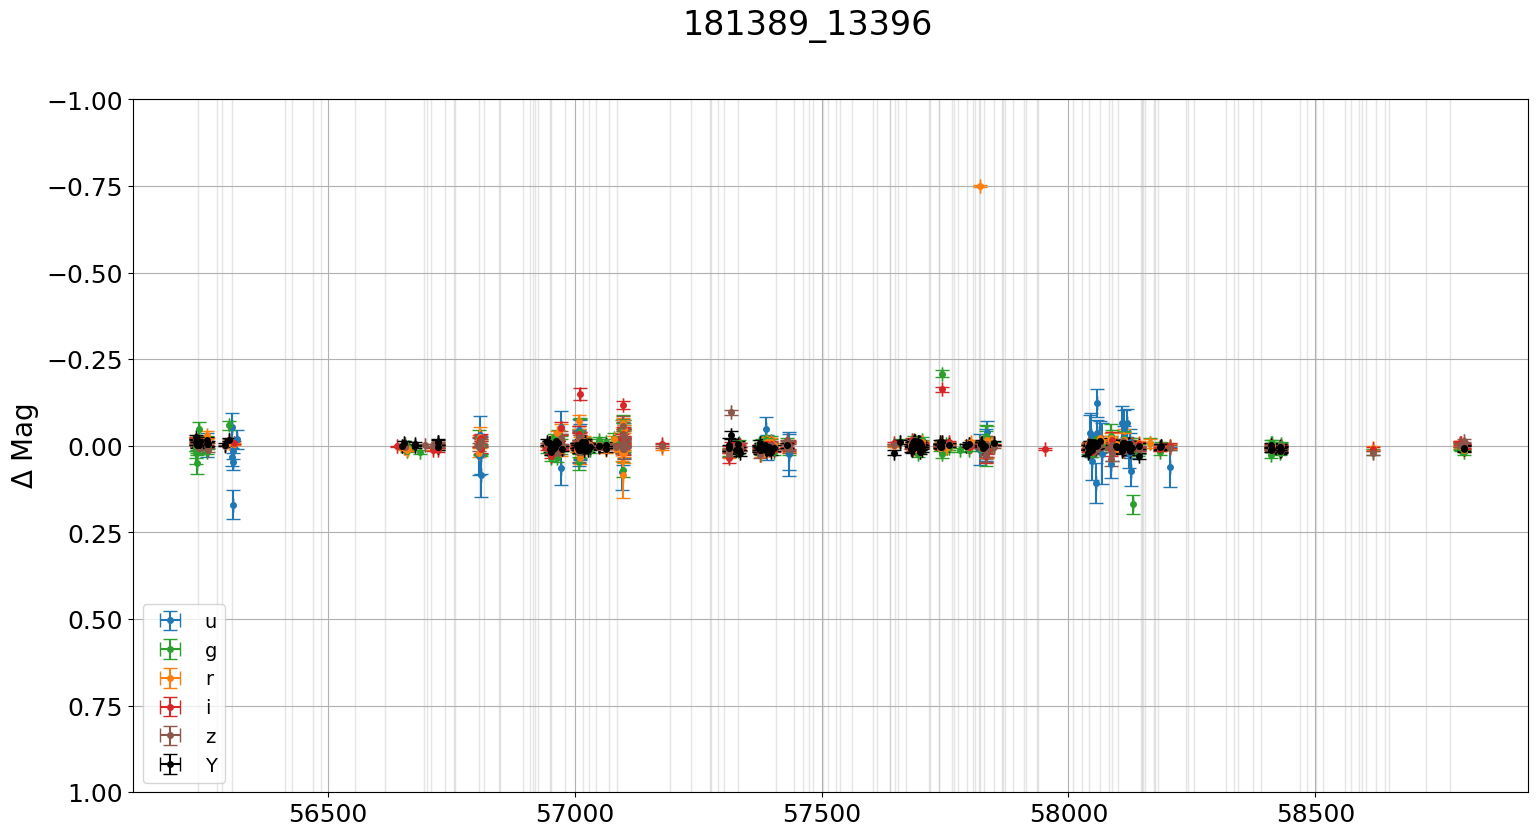

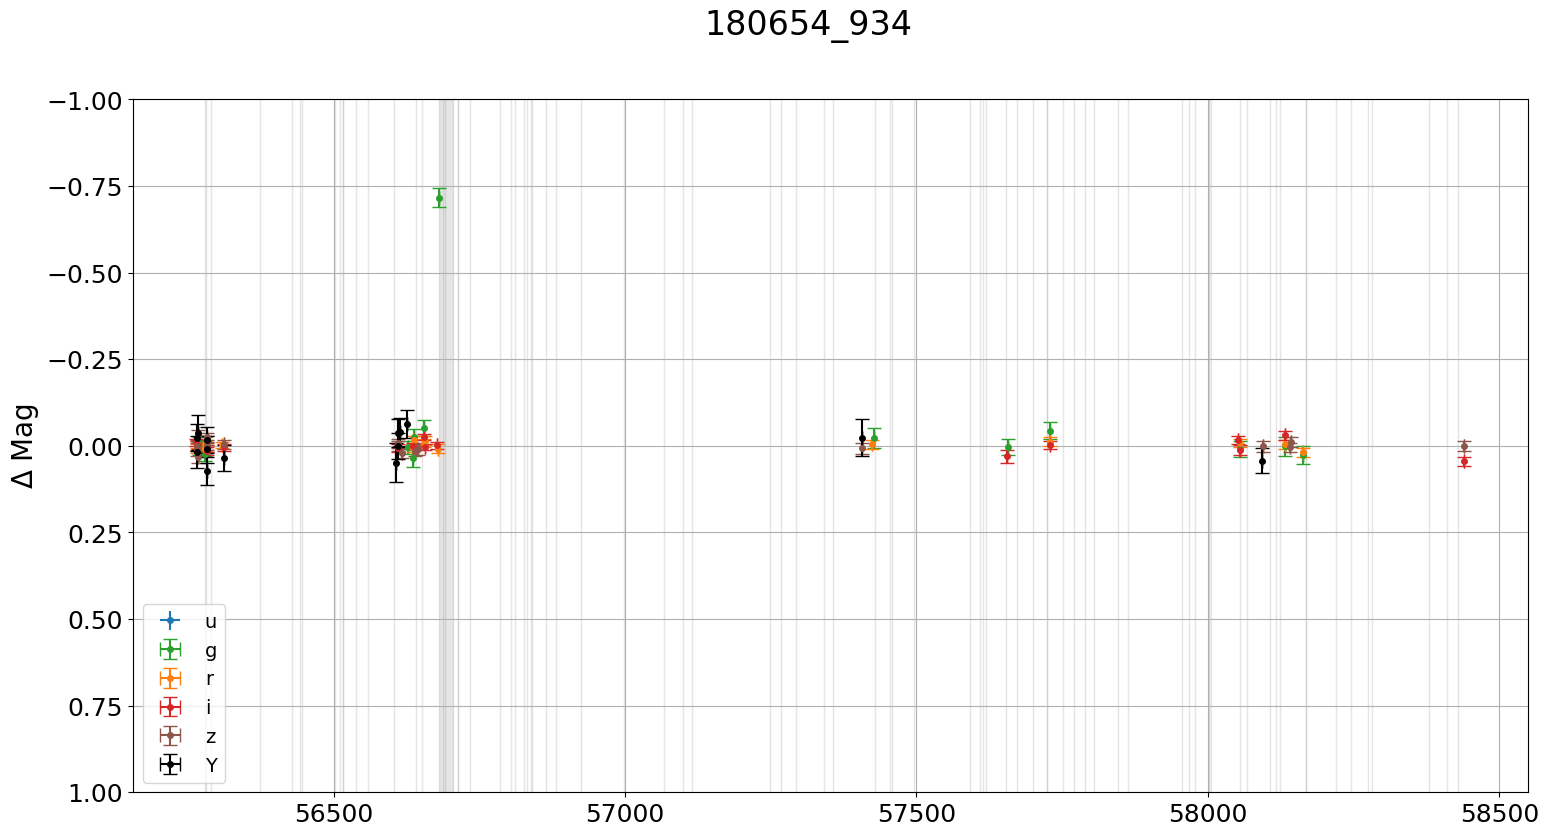

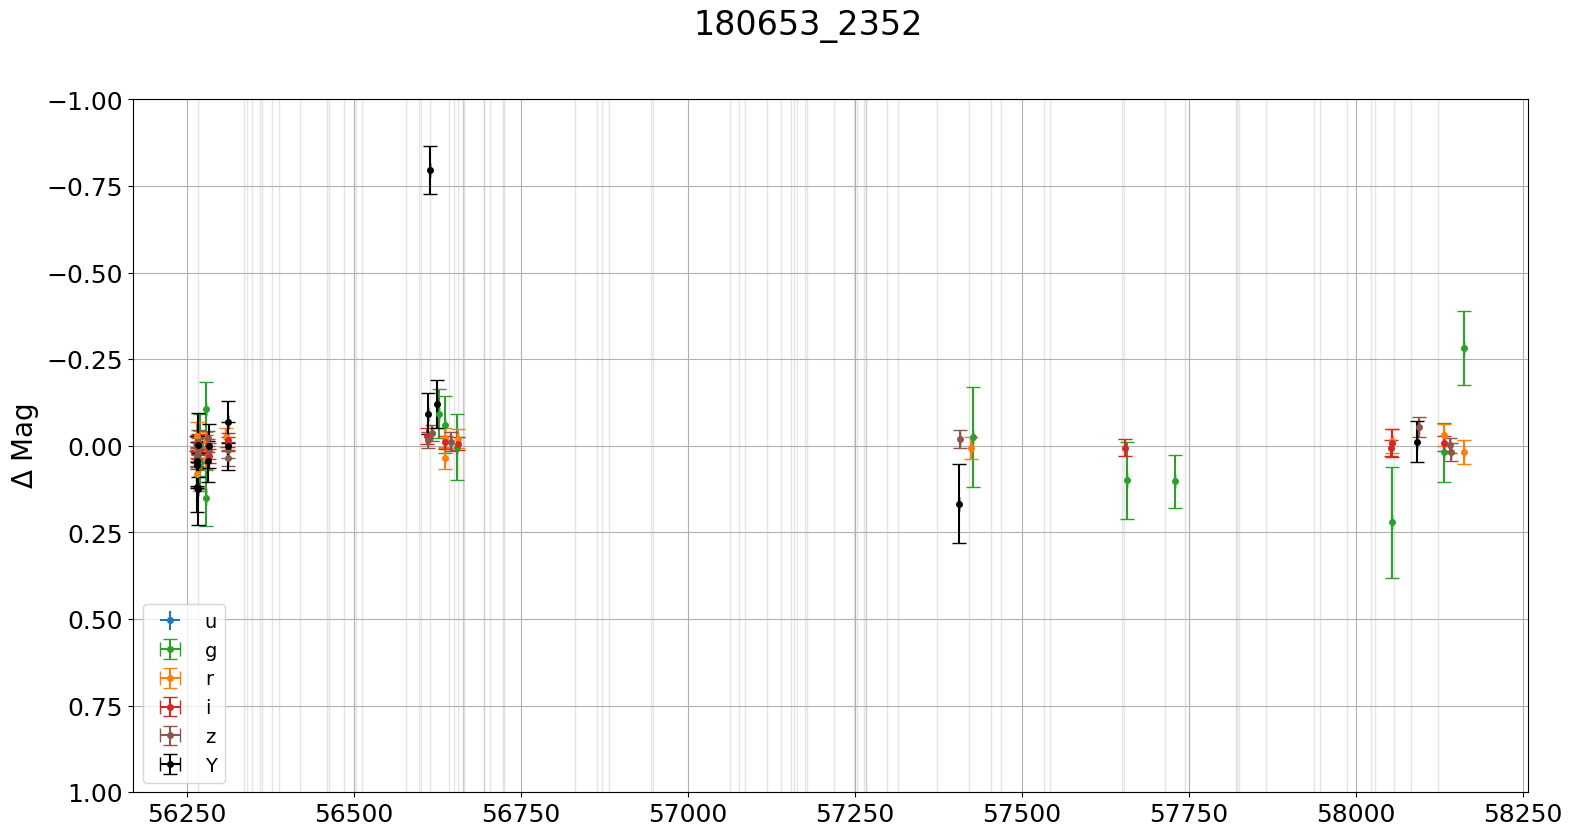

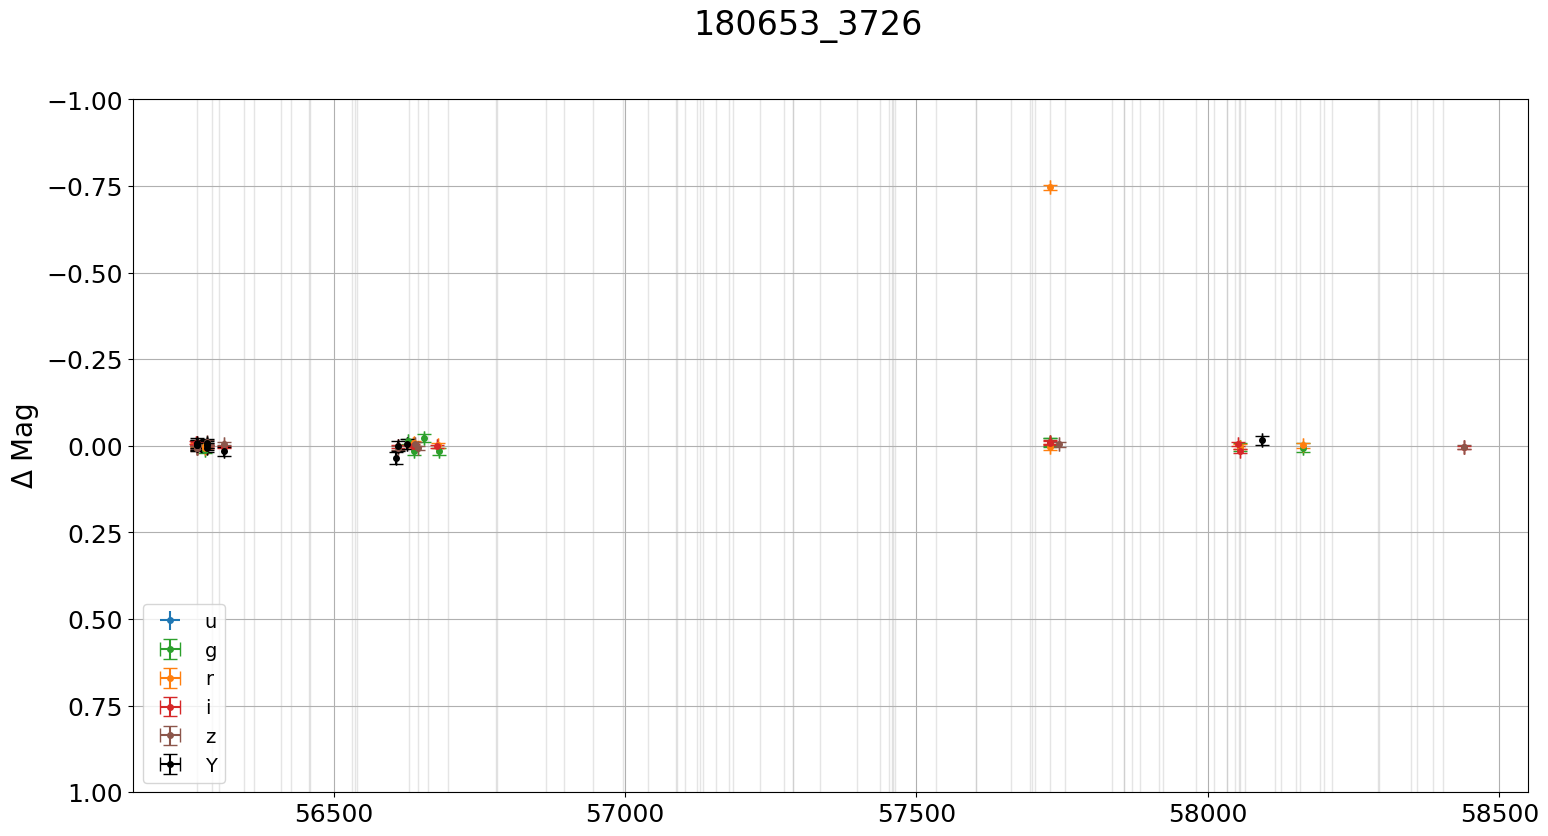

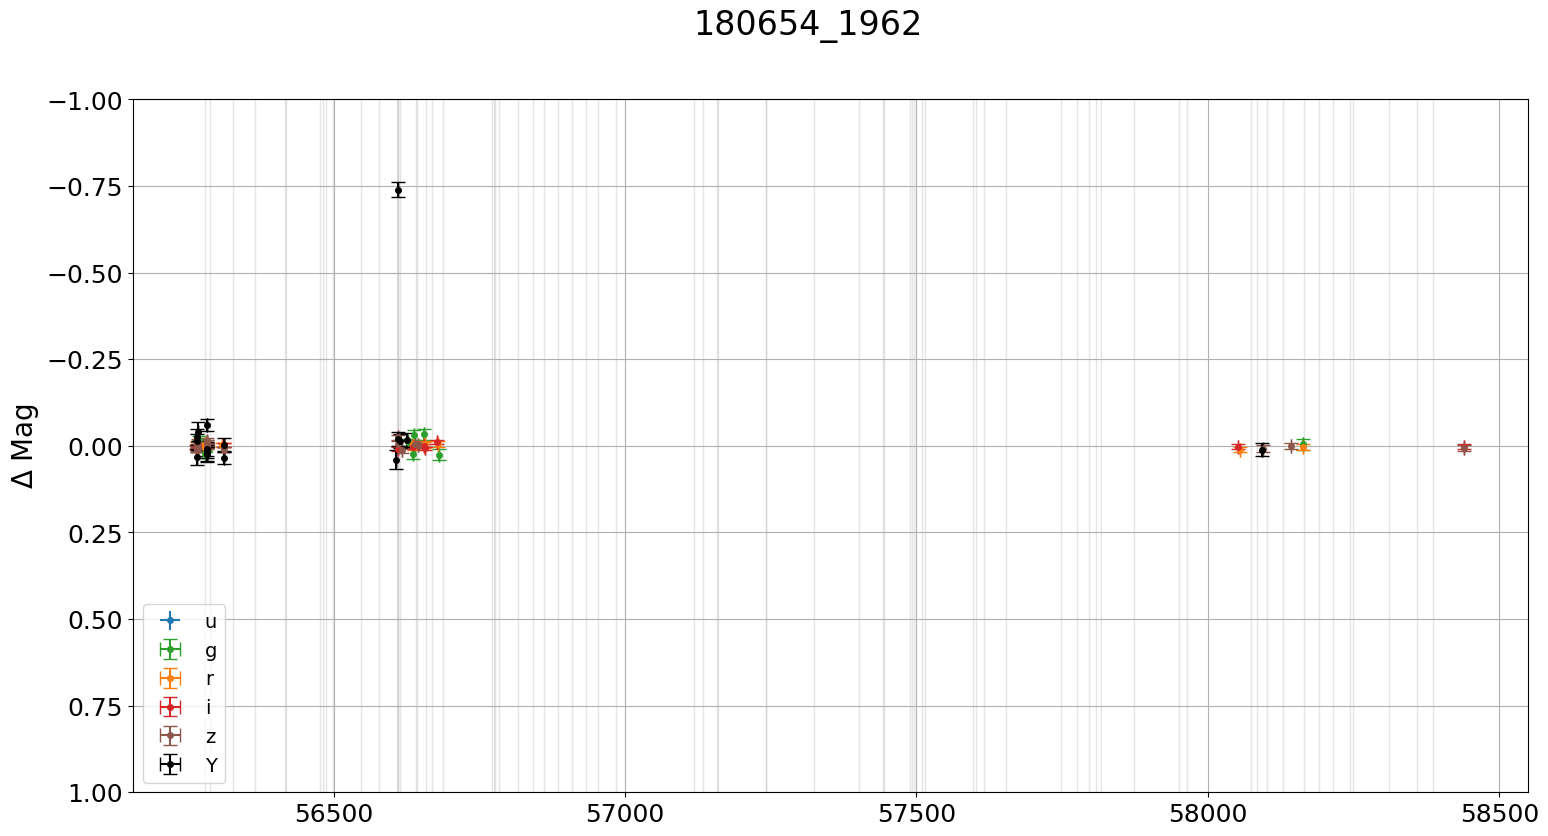

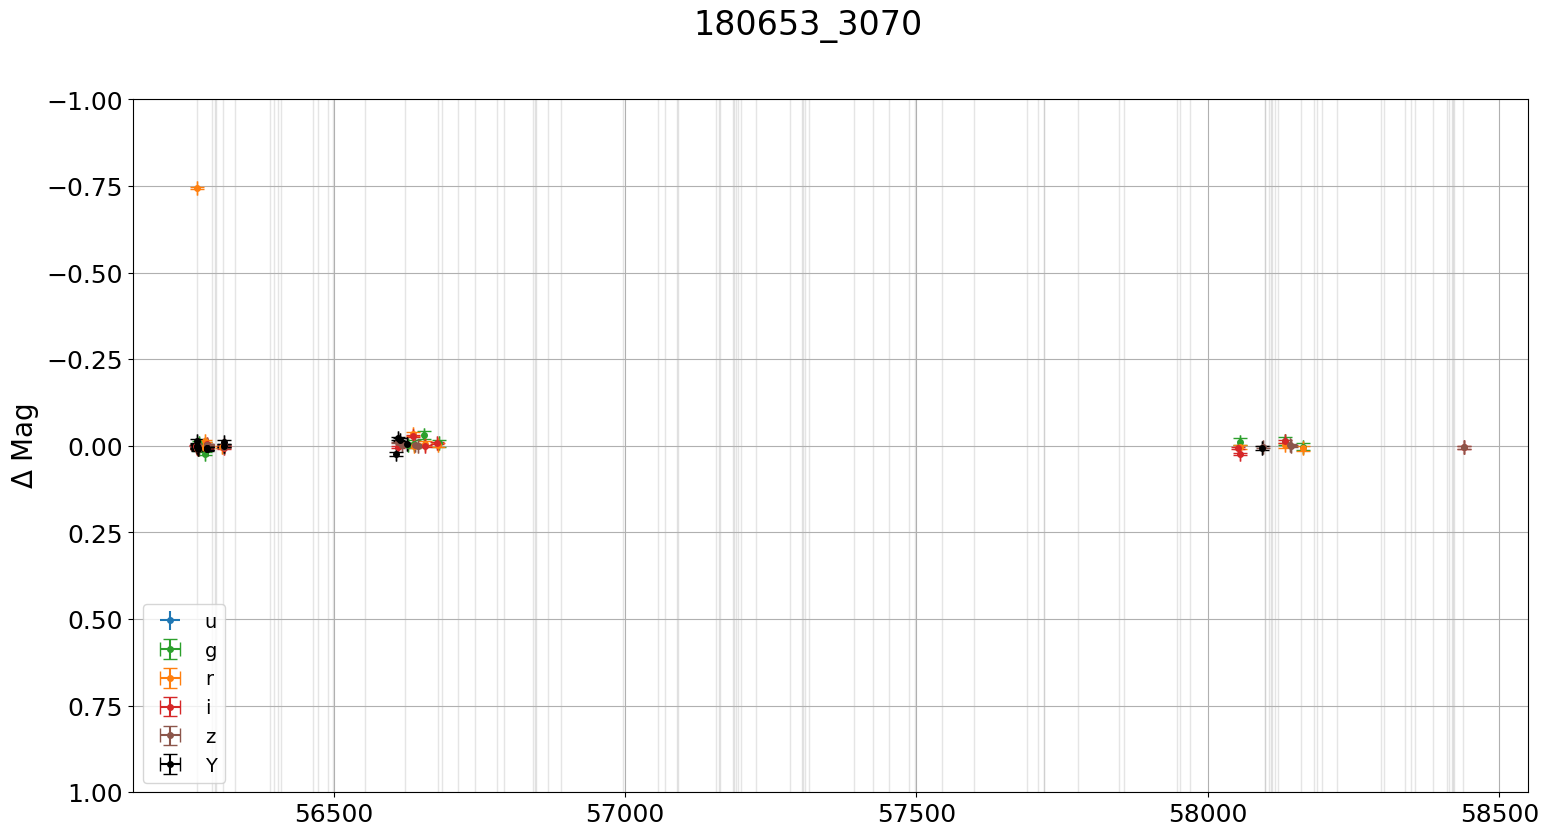

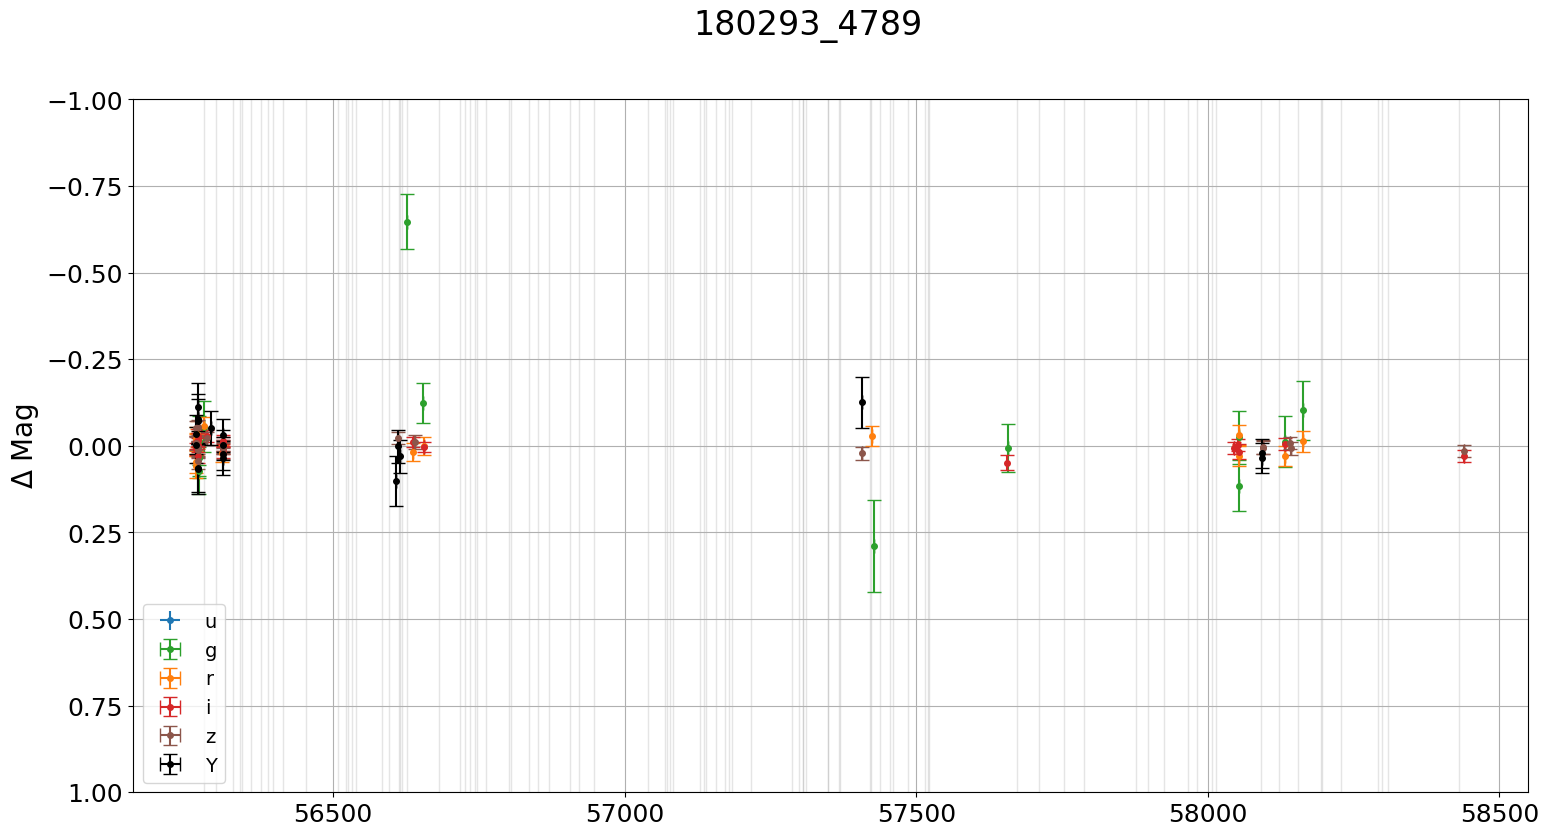

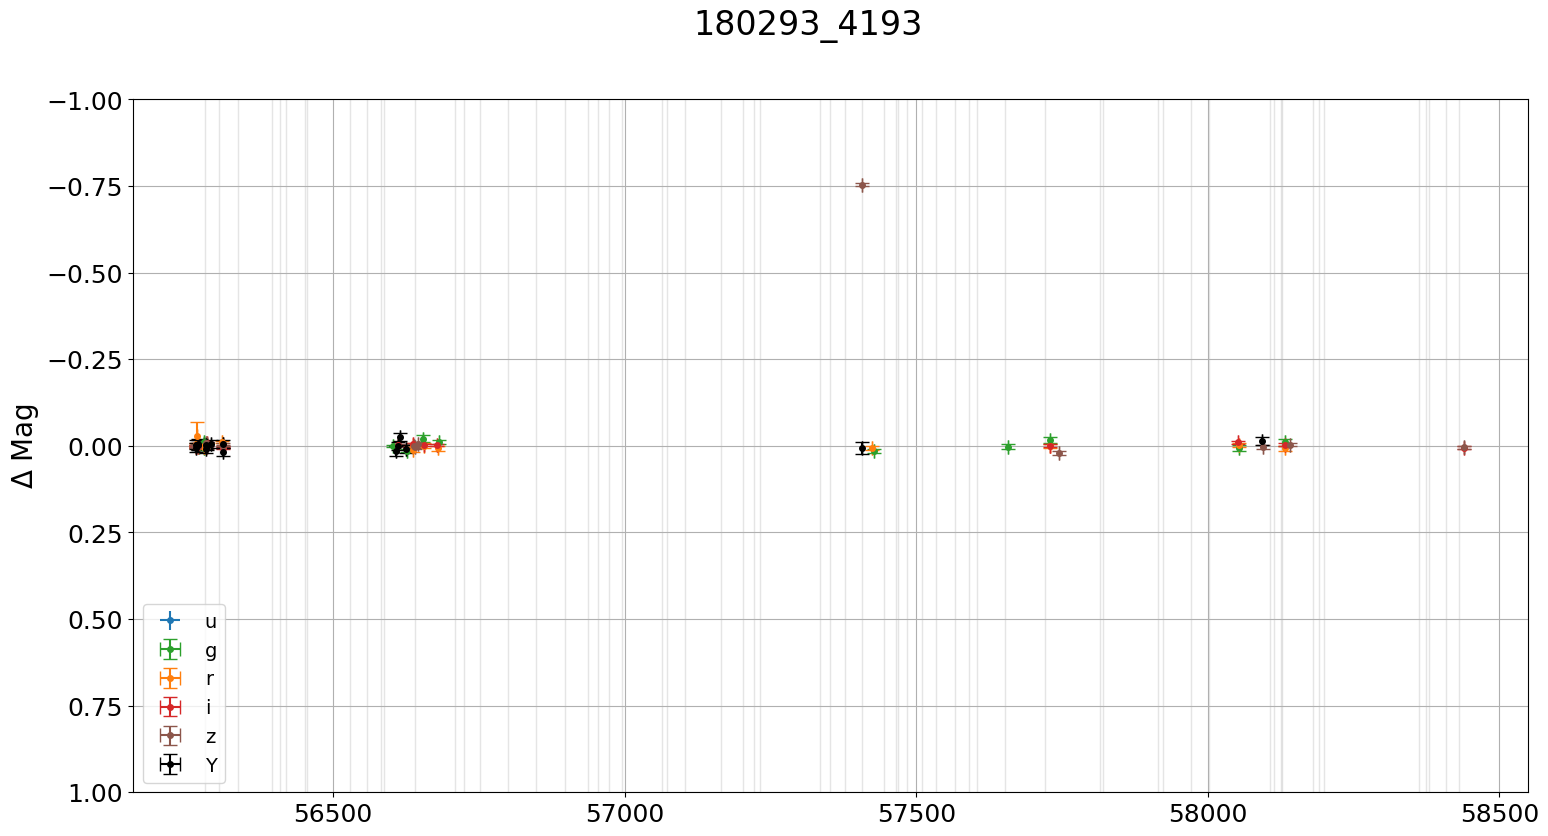

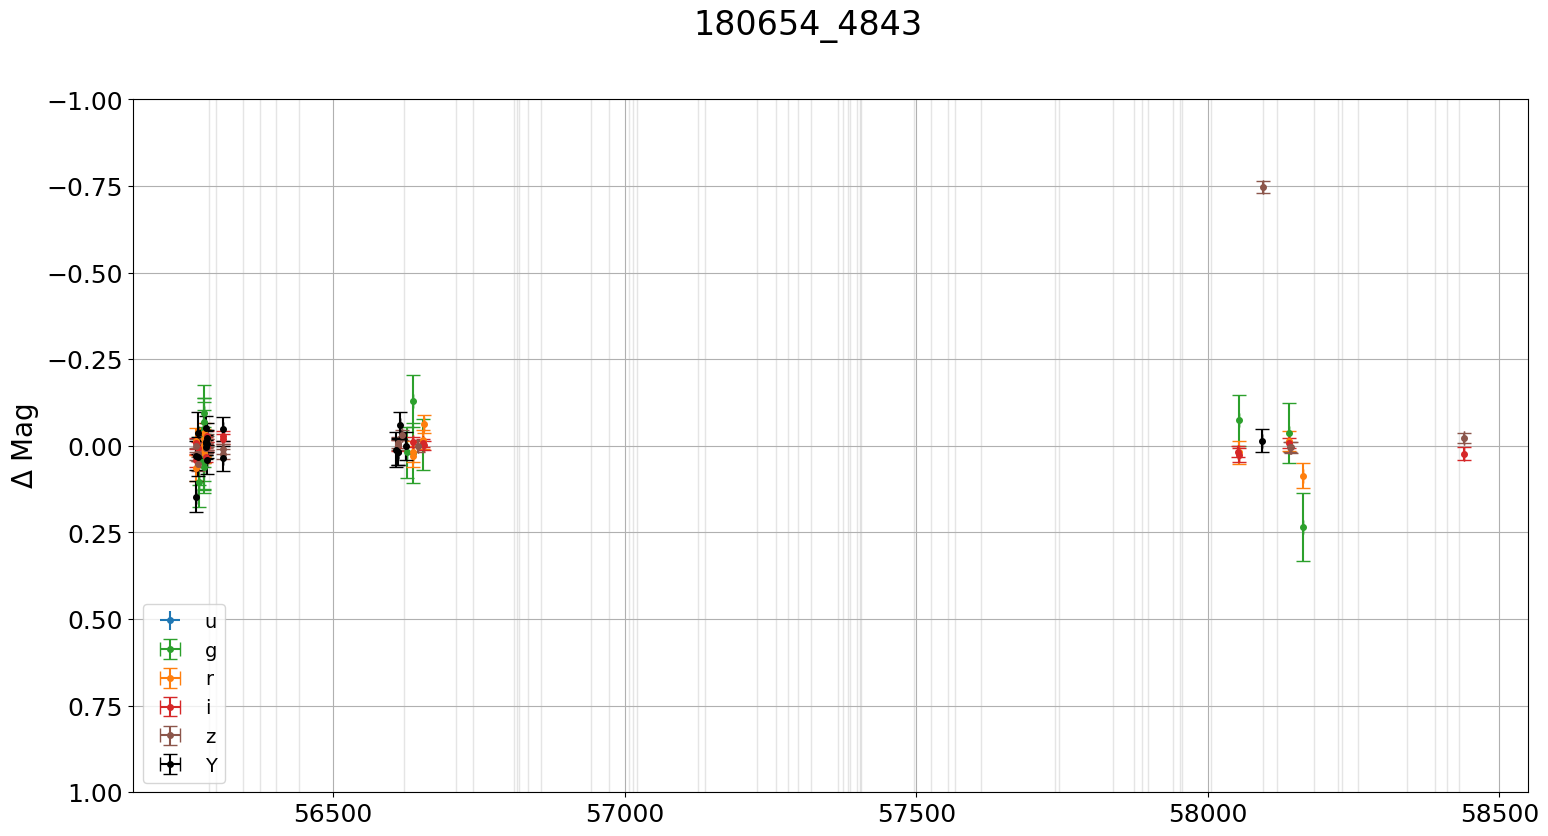

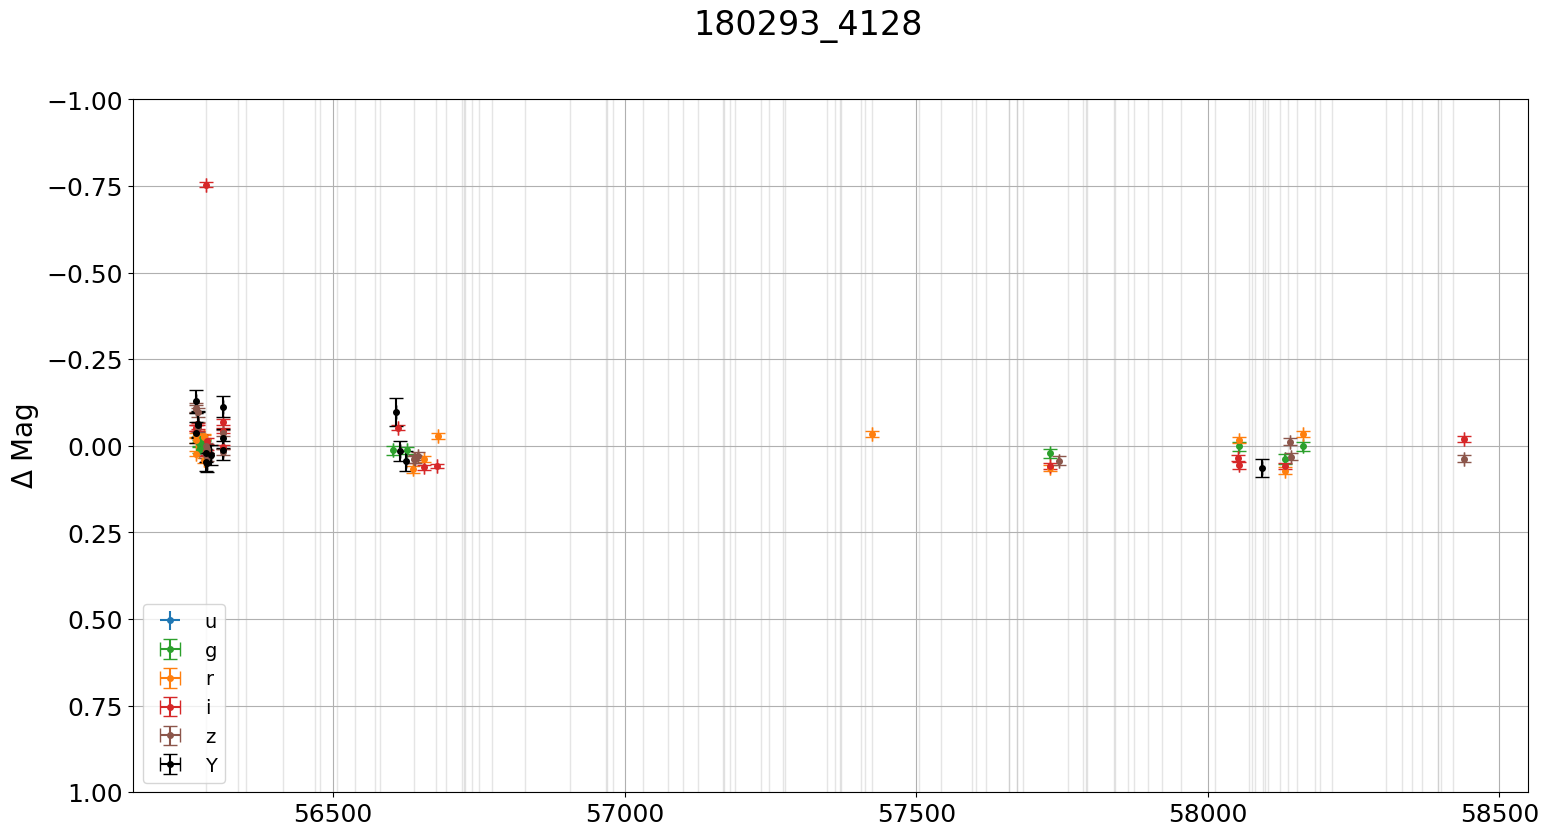

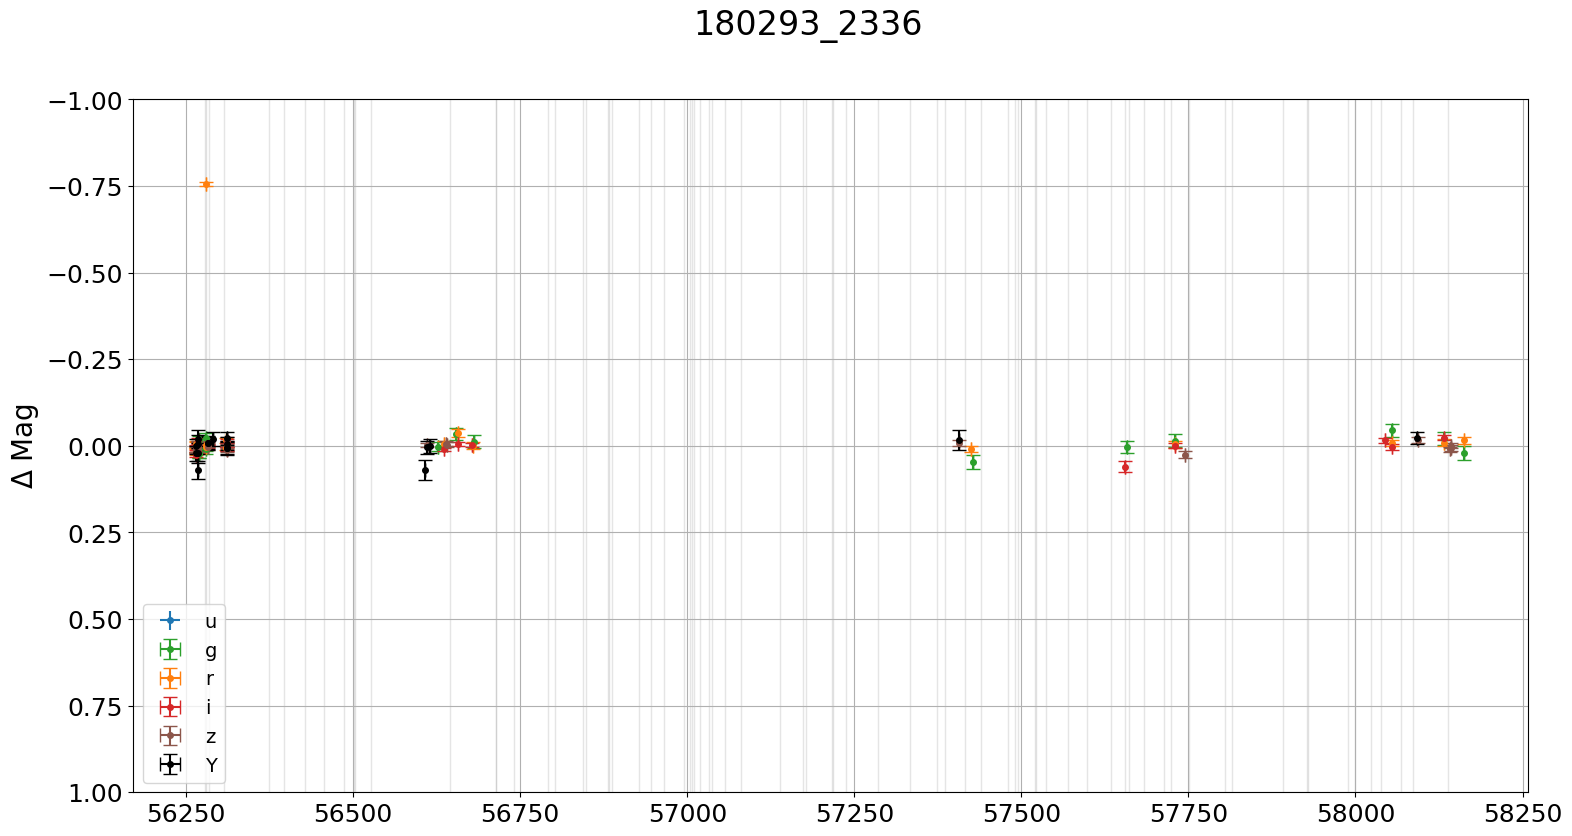

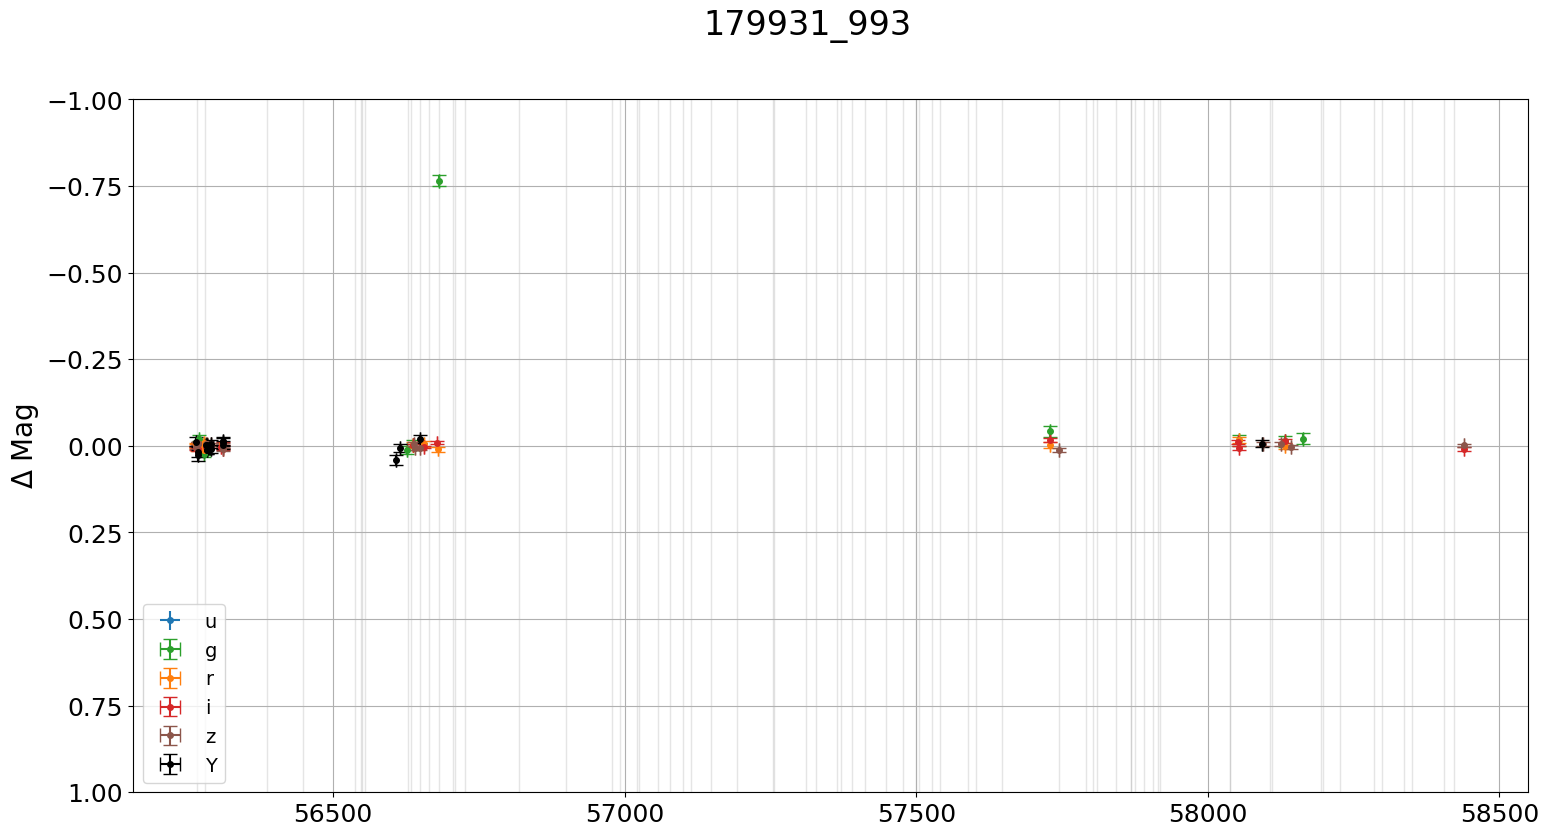

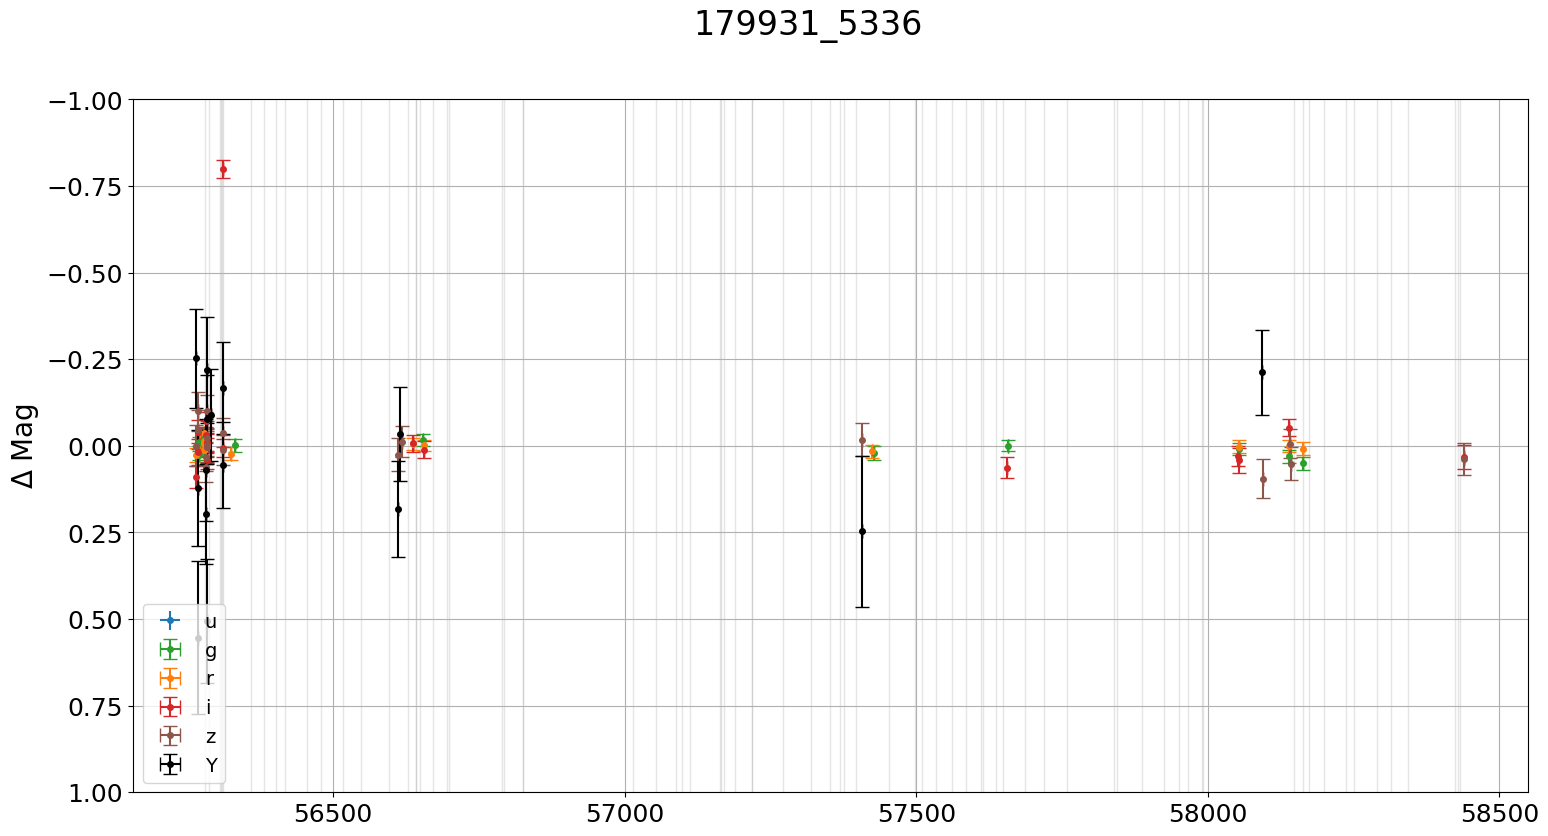

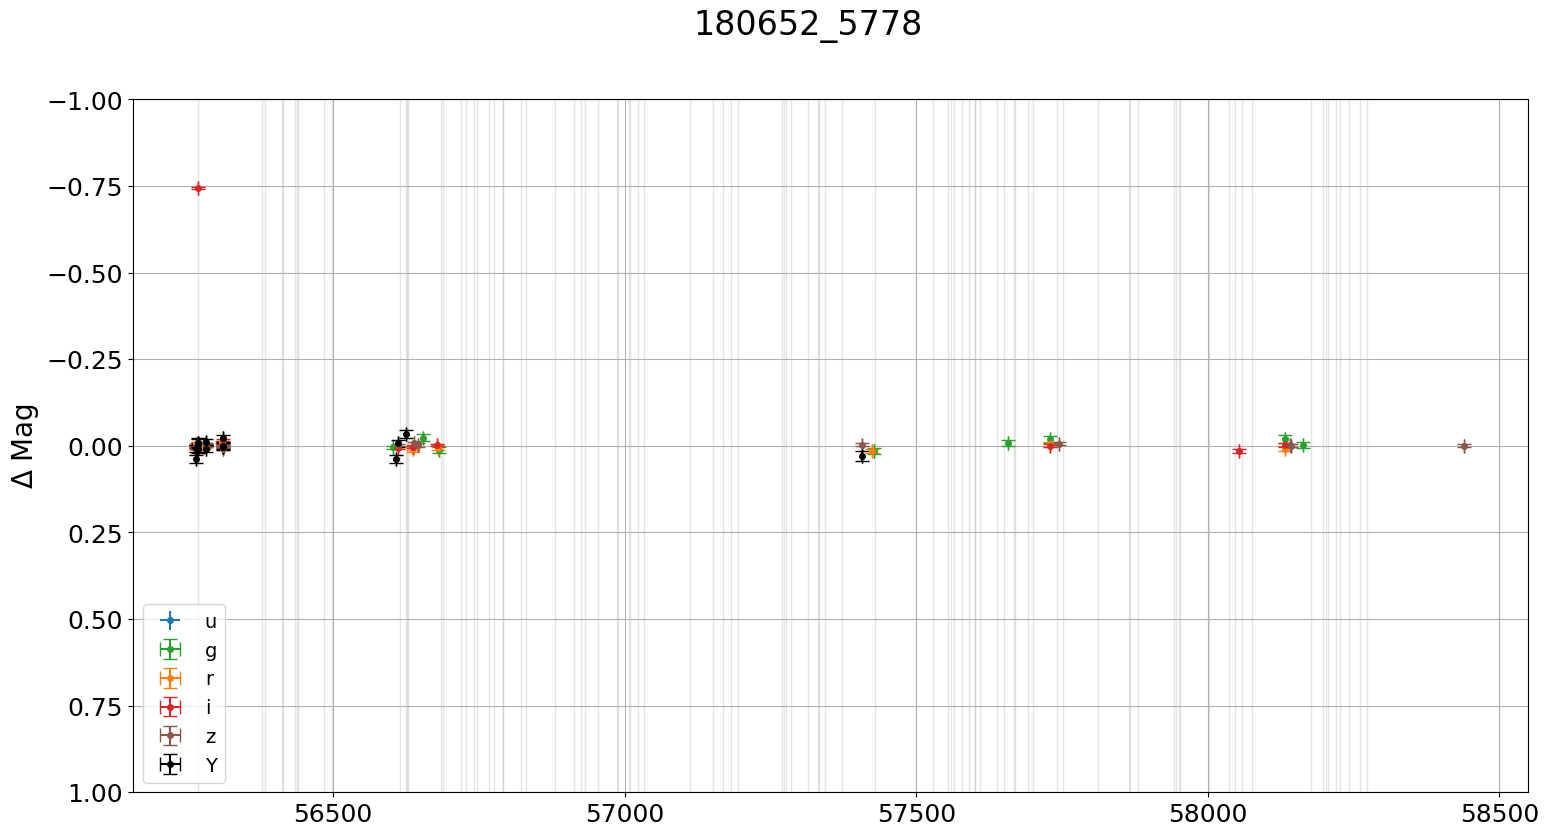

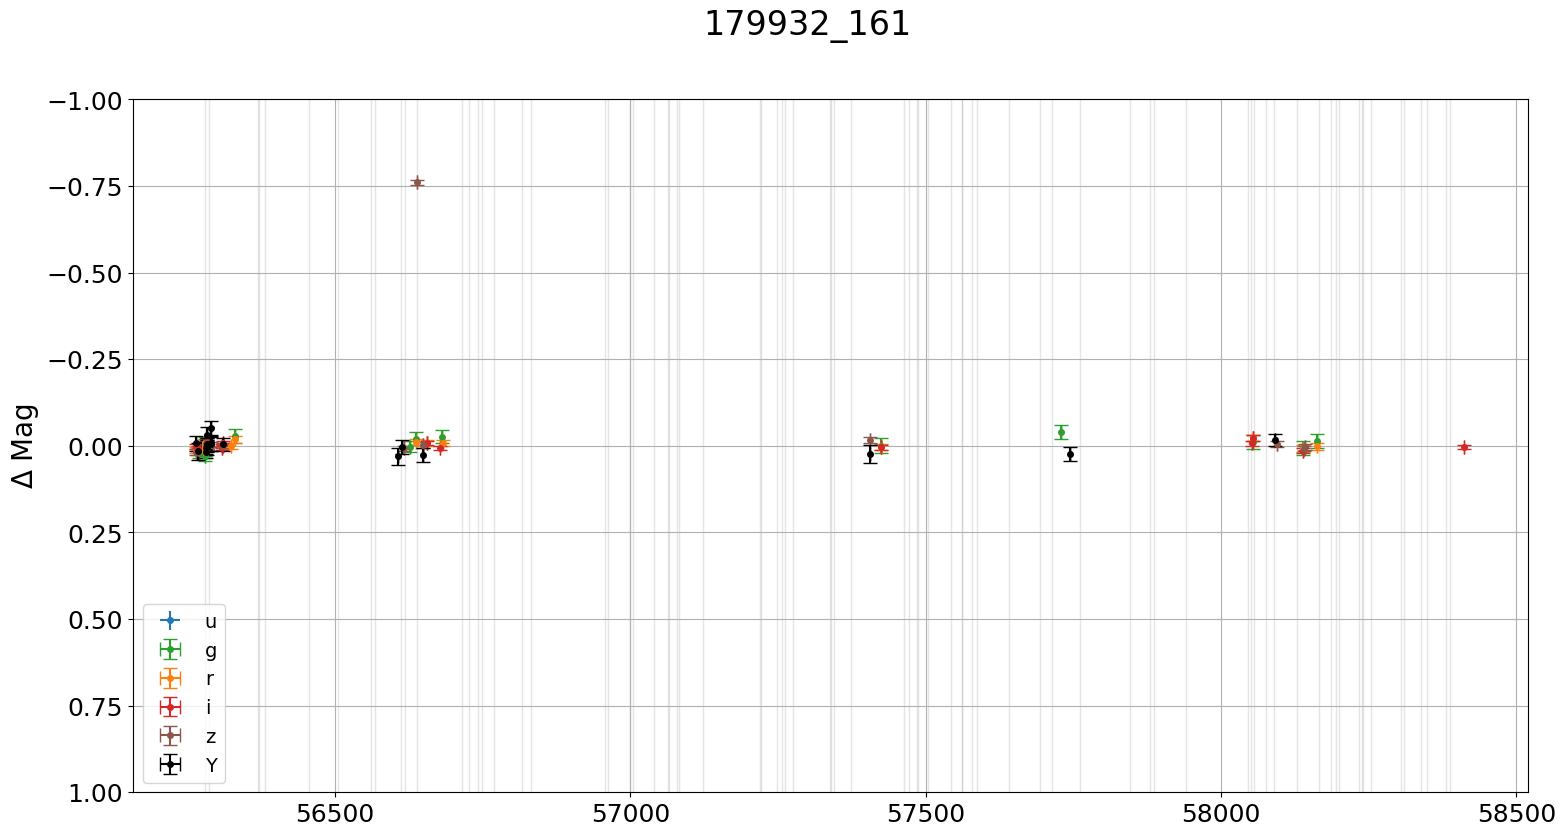

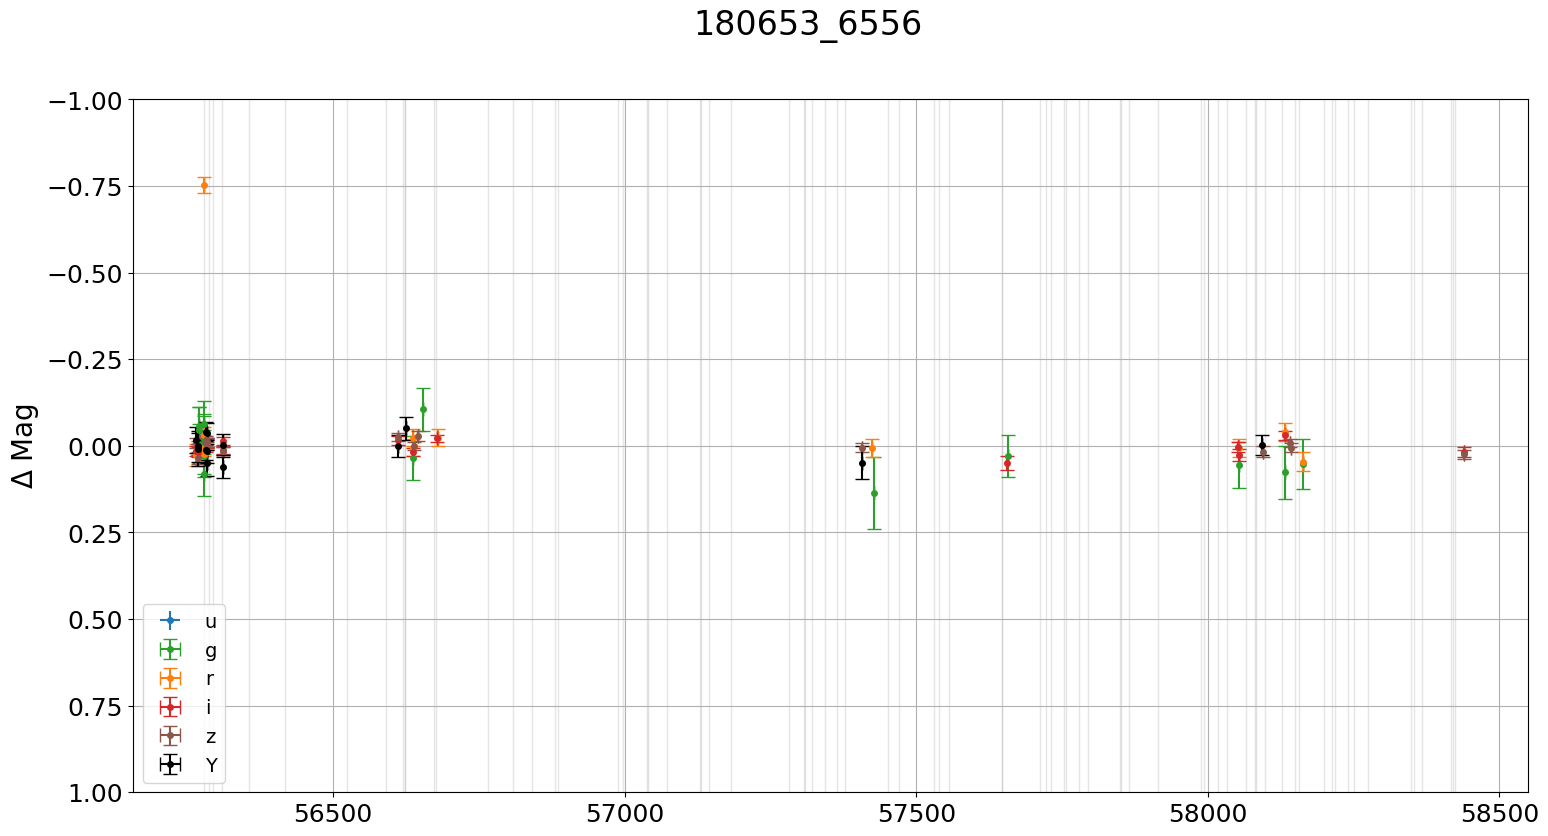

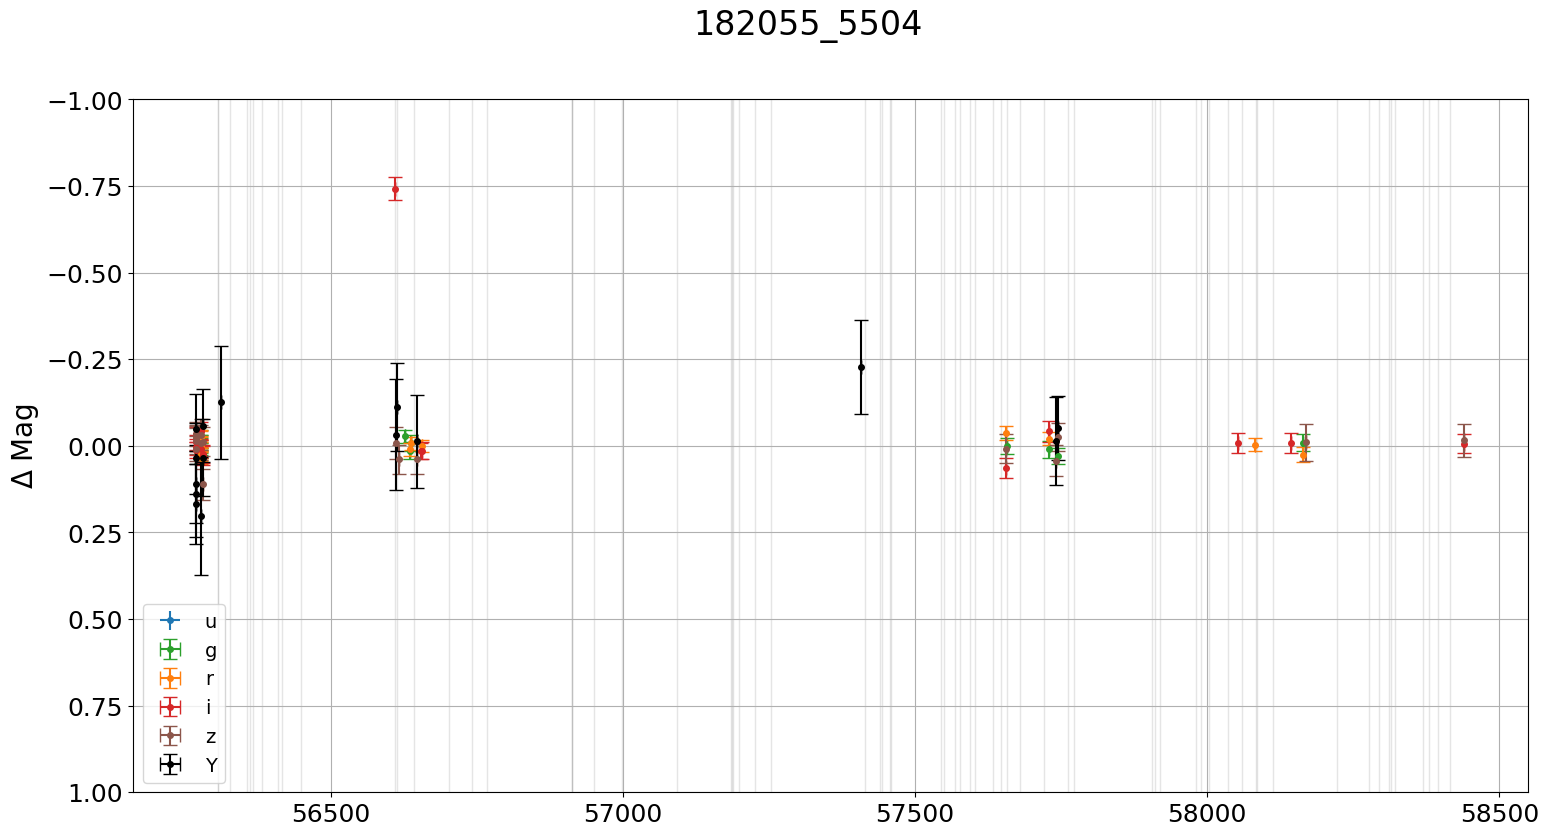

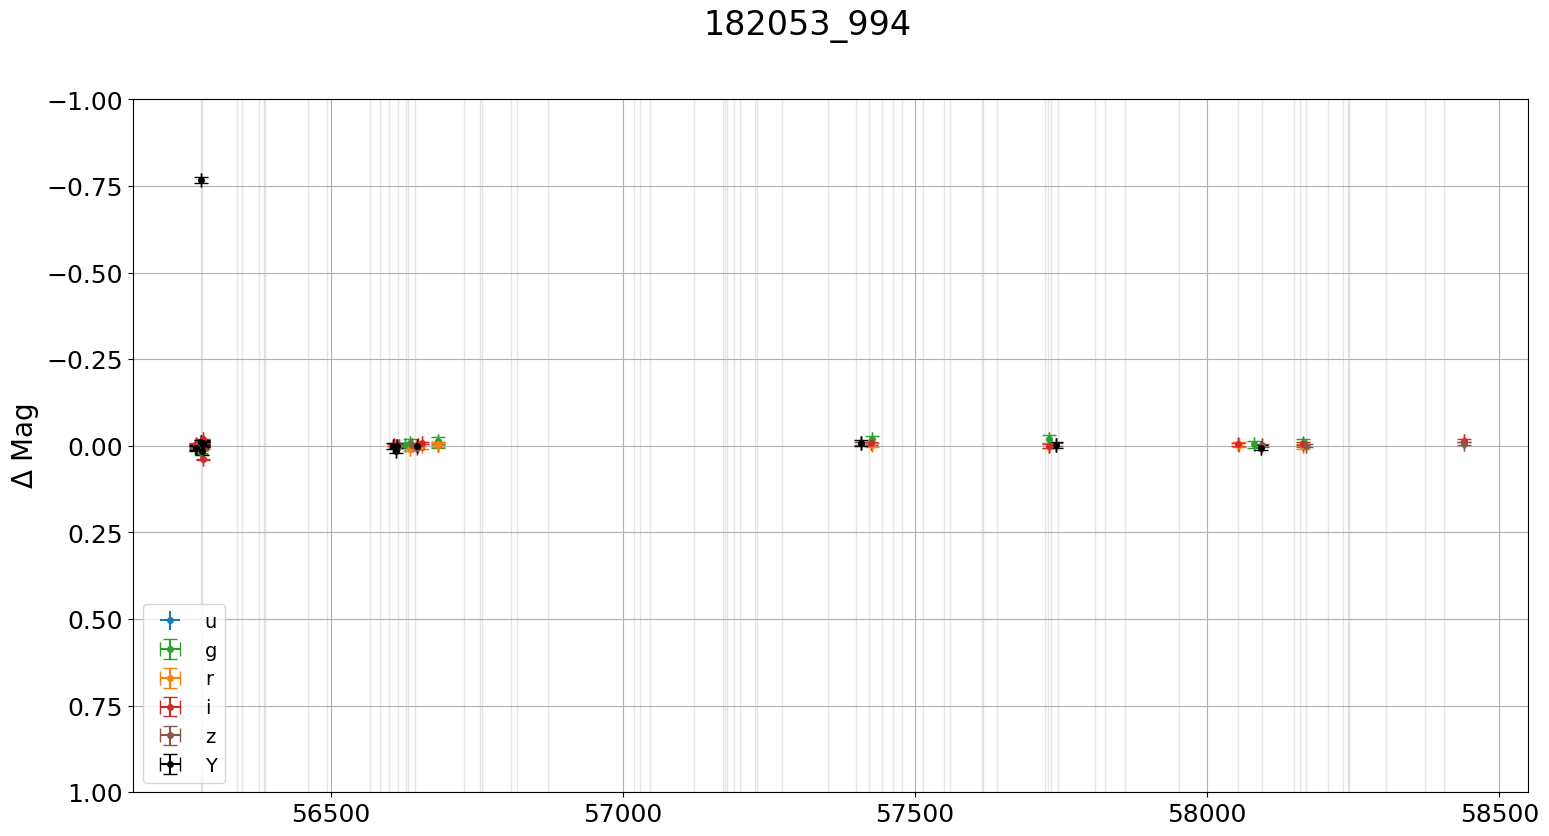

In [97]:
oids = lc_class_df.query("lightcurve_class.isnull()")["objectid"]

for oid in oids[:20]:
    lc = lens_lc(oid, rates, taus, rng_state, rng)
    lc = cluster_label_dataframe(lc)
    g = lc.groupby(by=["objectid", "filter"], sort=False, group_keys=False)
    baseline_subtracted = subtract_baseline(g)
    fig = plot_lensed_lc(baseline_subtracted, taus, rng_state, rng,
                         mag_column="delta_mag",
                         magerr_column="delta_mag_err")
    ax = fig.get_axes()[0]
    ax.legend(fontsize=14, loc="lower left")
    ax.set_ylabel(r"$\Delta$ Mag", fontsize=20)
    ax.set_ylim((1, -1))
    fig.suptitle(f"{oid}", fontsize=24)
    plt.show(fig)
    plt.close(fig)

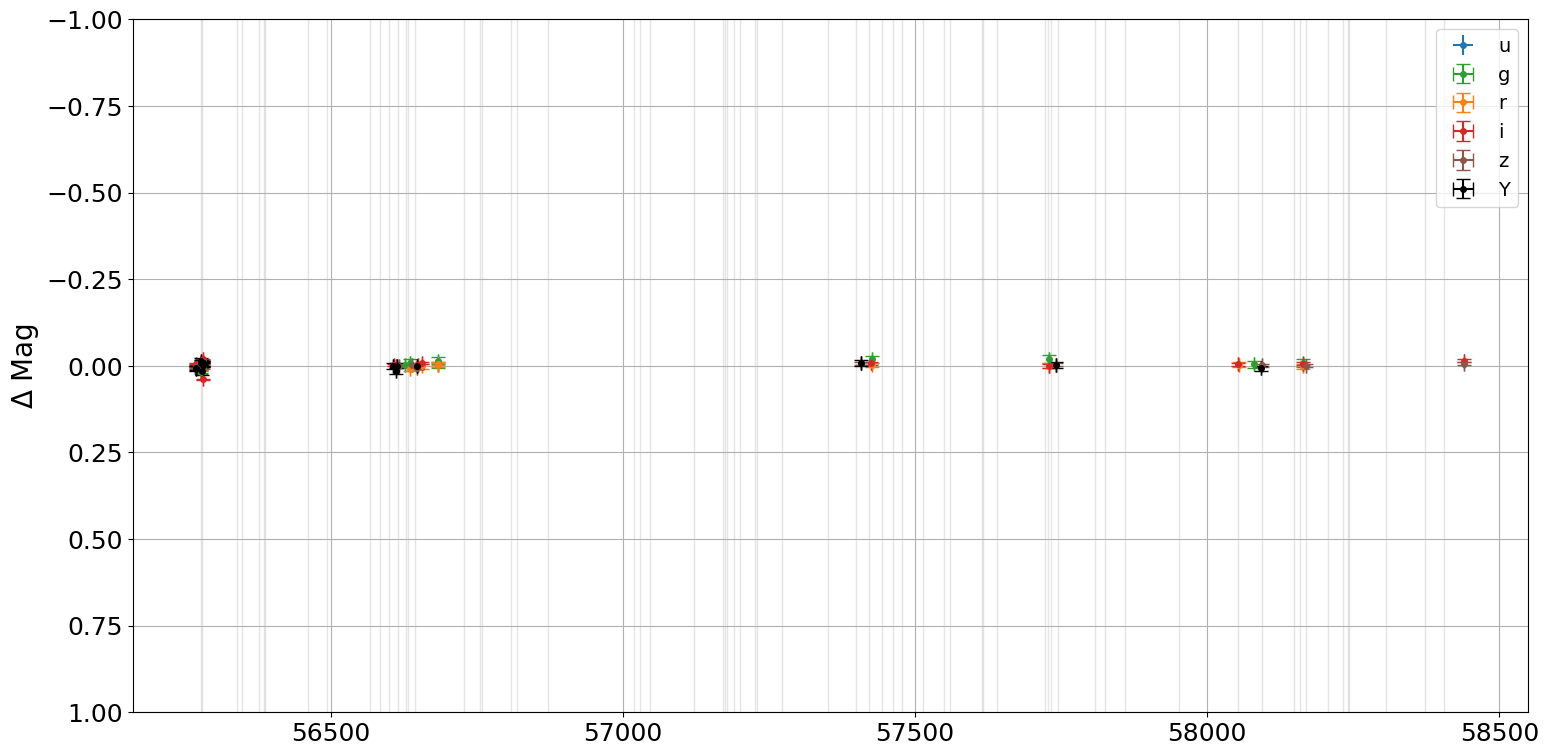

In [98]:
unlensed = get_lc(oid)
unlensed = cluster_label_dataframe(unlensed)
unlensed = subtract_baseline(unlensed.groupby(by=["objectid", "filter"], sort=False, group_keys=False))

fig = plot_lensed_lc(unlensed, taus, rng_state, rng,
                     mag_column="delta_mag",
                     magerr_column="delta_mag_err")
ax = fig.get_axes()[0]
ax.legend(fontsize=14)
ax.set_ylabel(r"$\Delta$ Mag", fontsize=20)
ax.set_ylim((1, -1))
plt.show(fig)

In [84]:
((len(lc_class_df.query("lightcurve_class == 'unstable'")) + 
  len(lc_class_df.query("lightcurve_class.isnull()"))) / len(lc_class_df))

0.002490776550257431

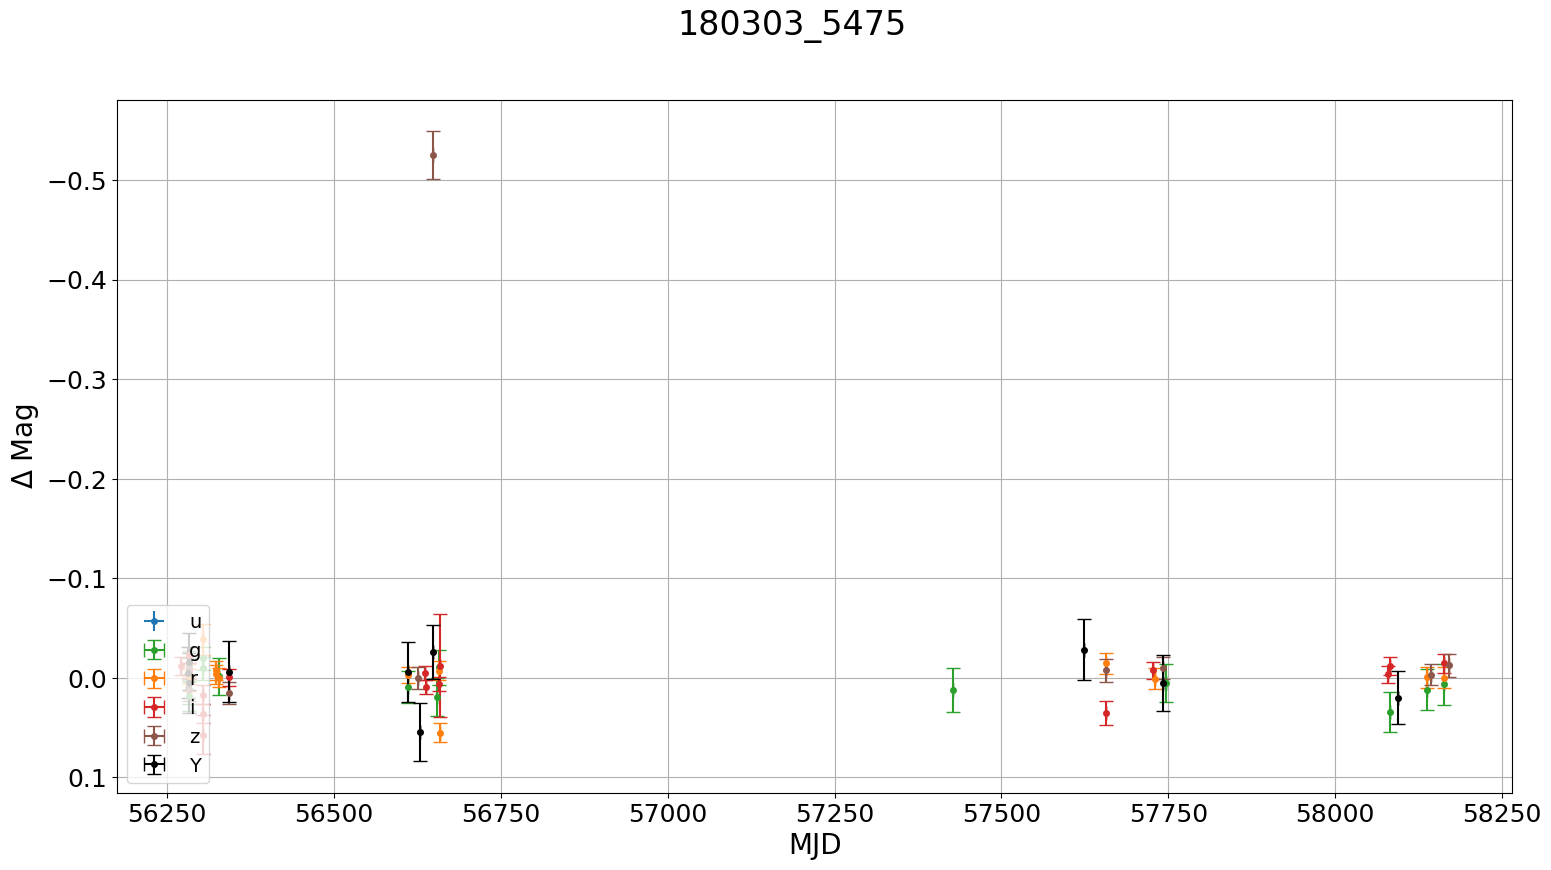

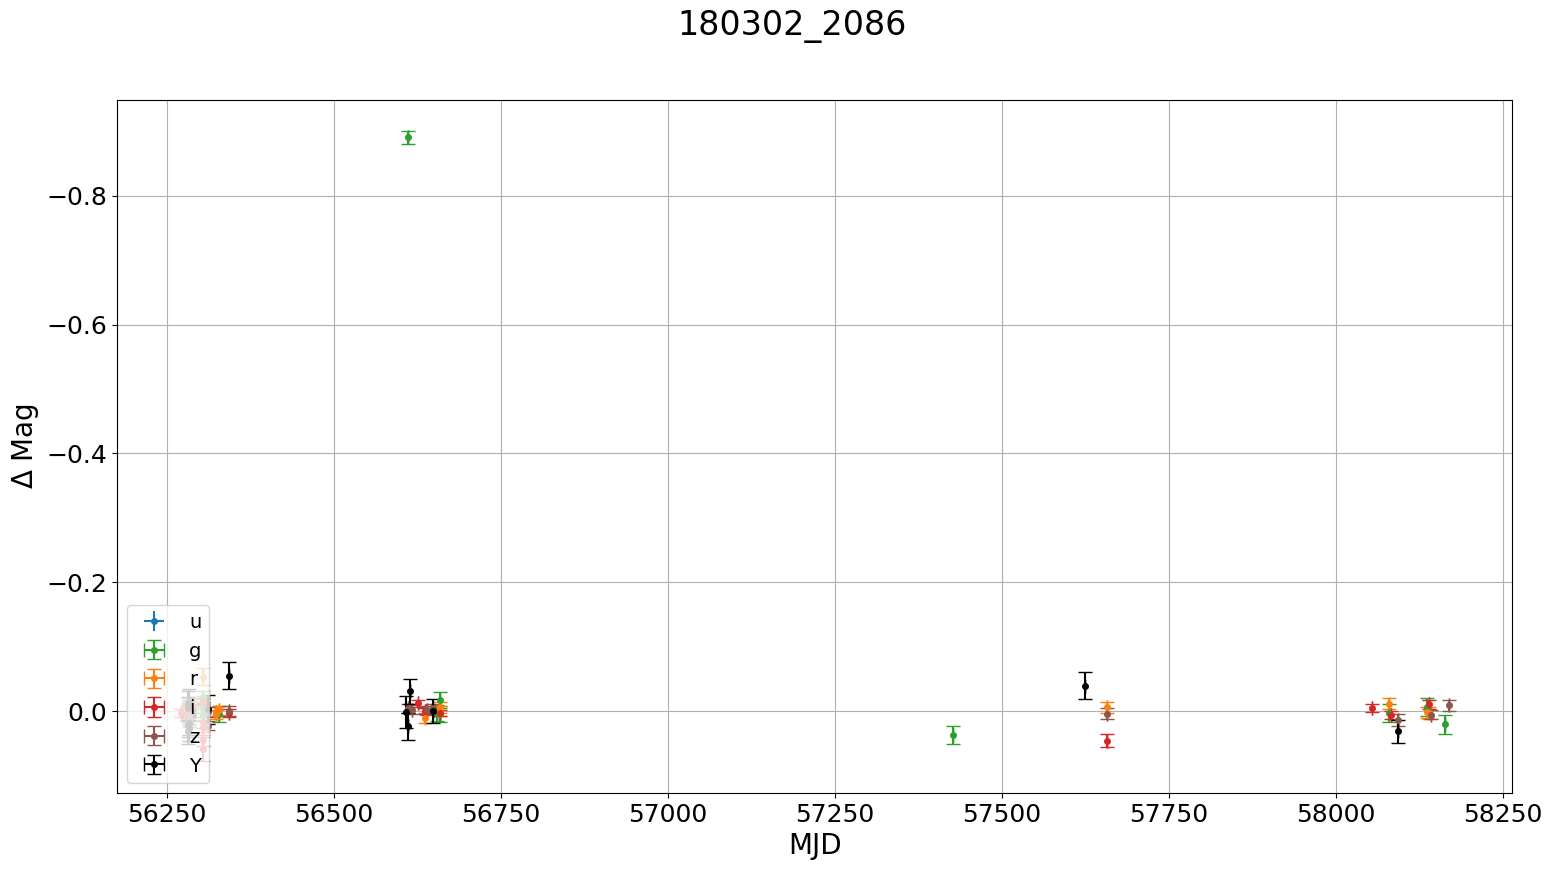

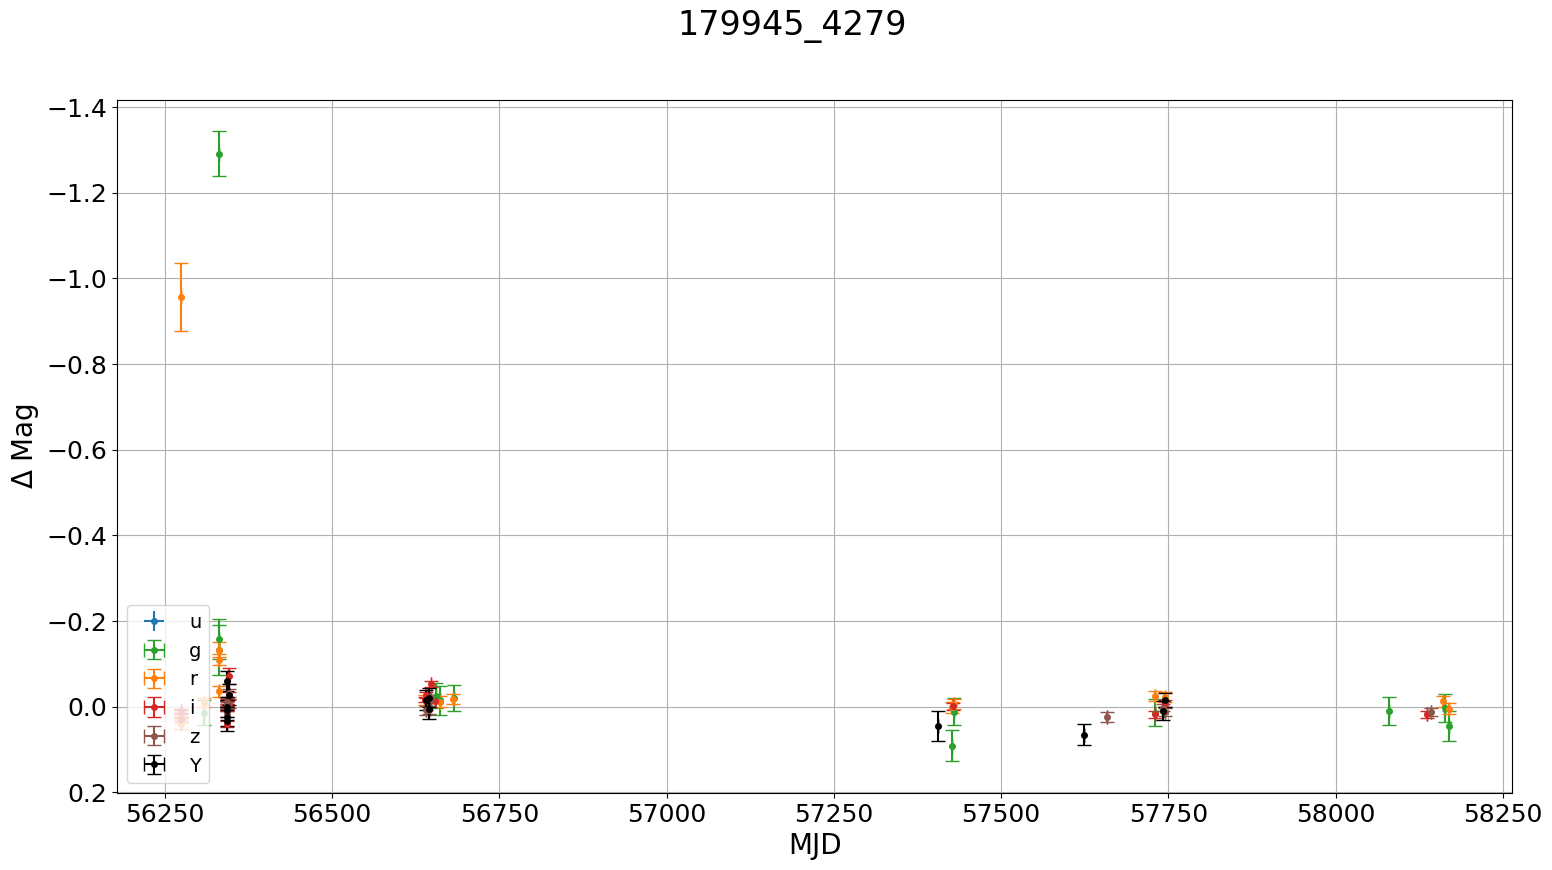

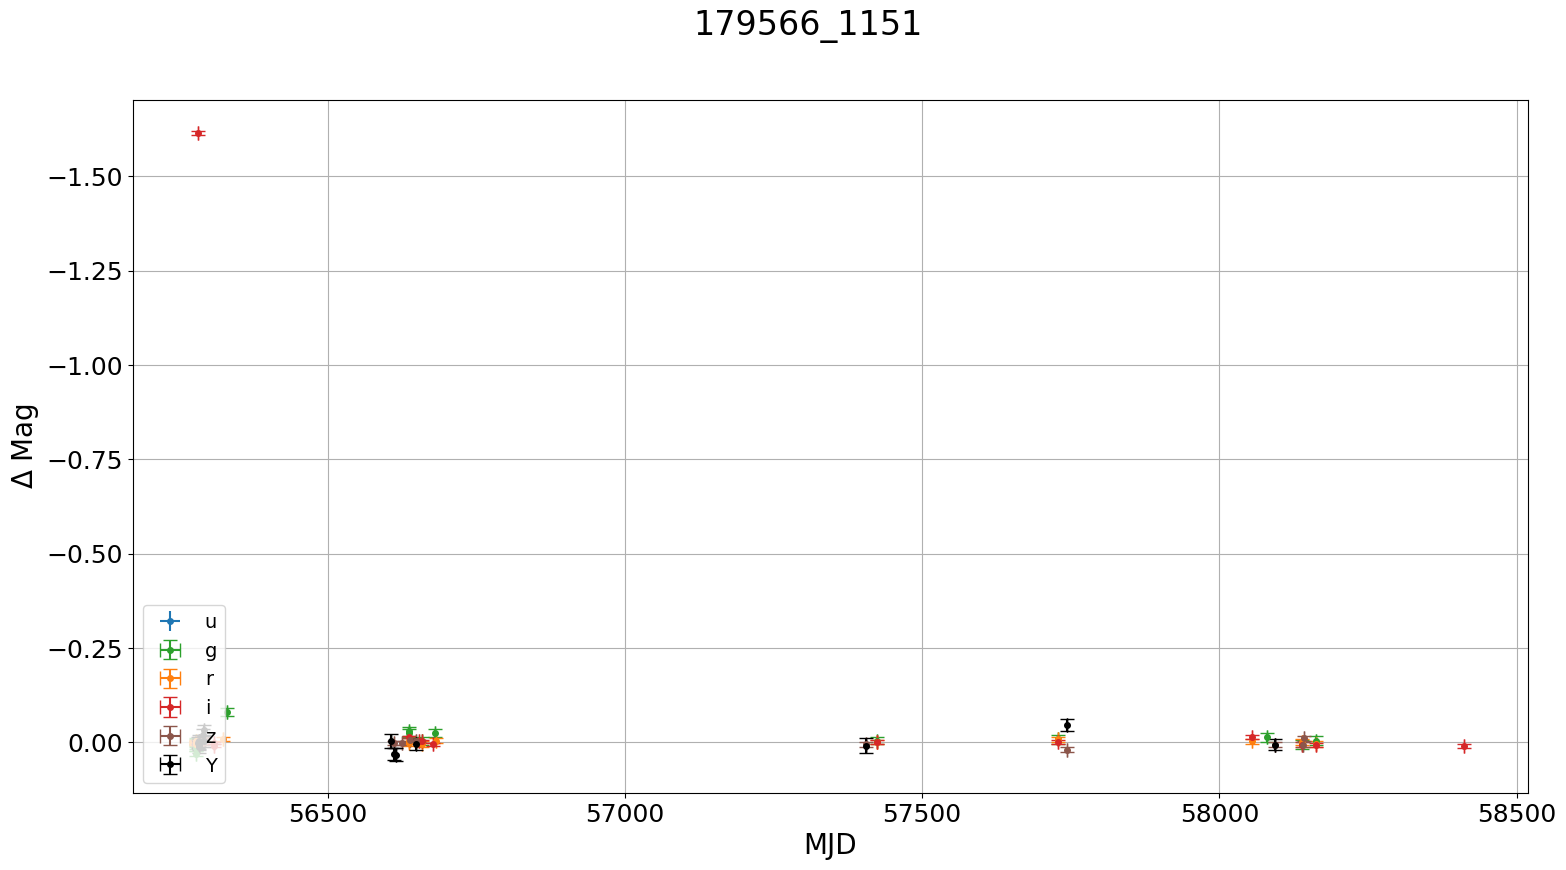

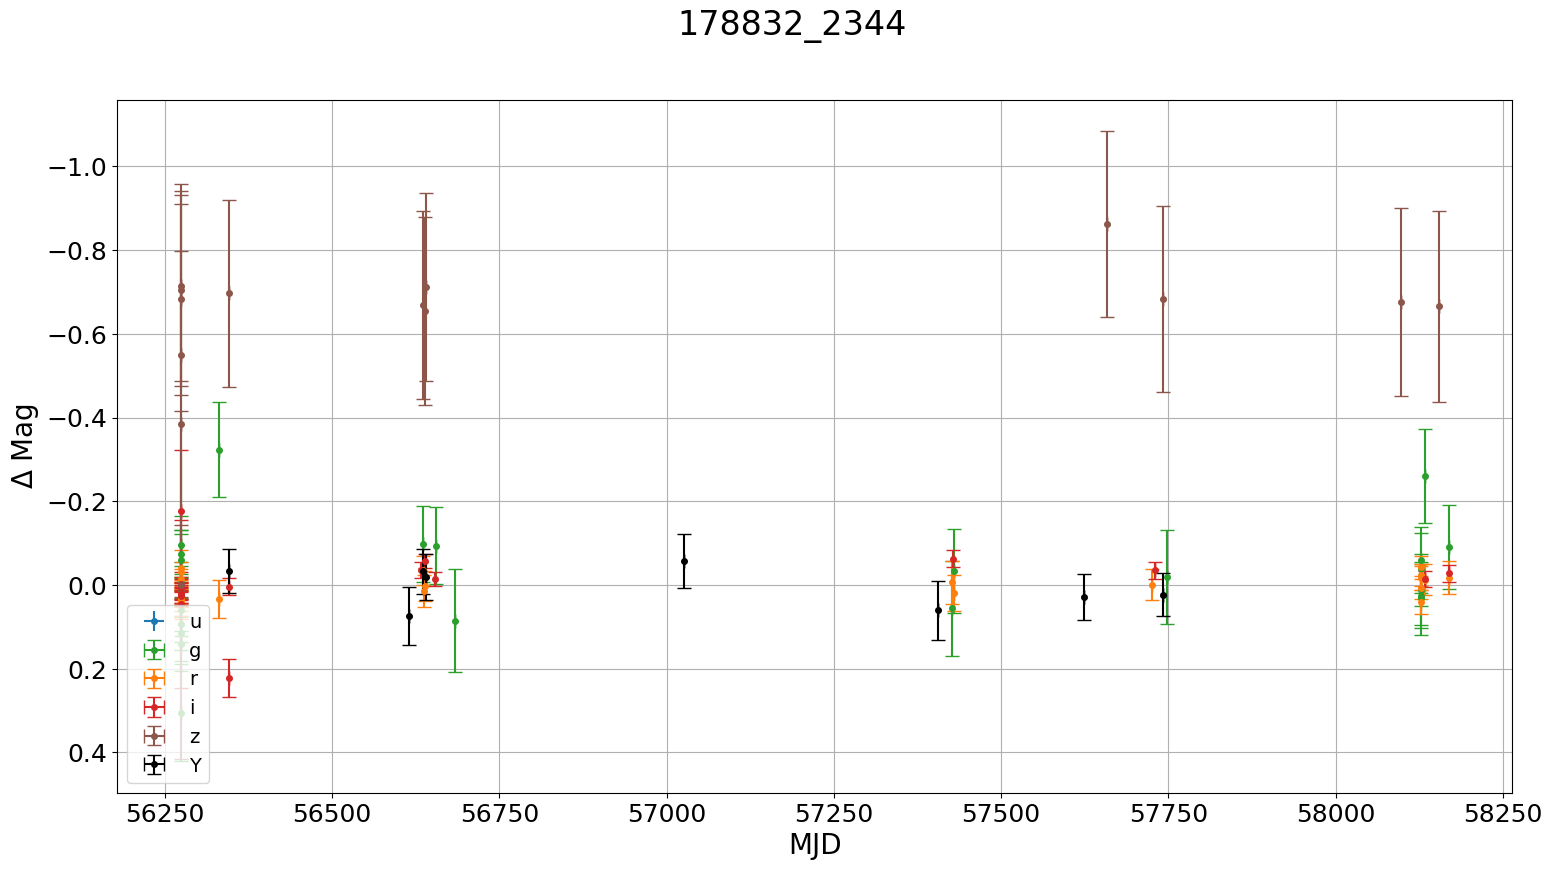

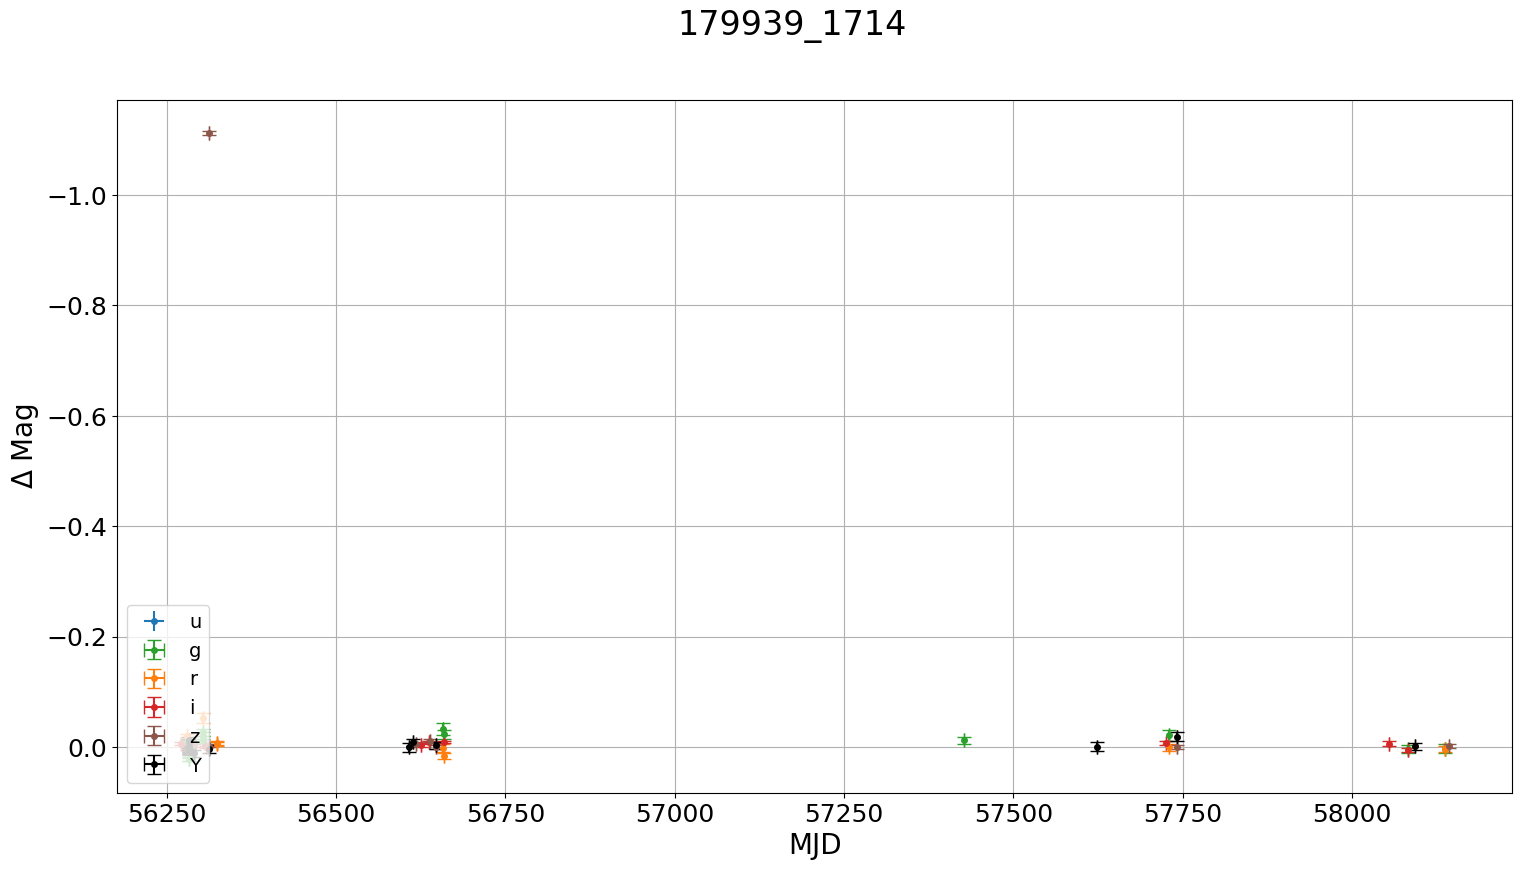

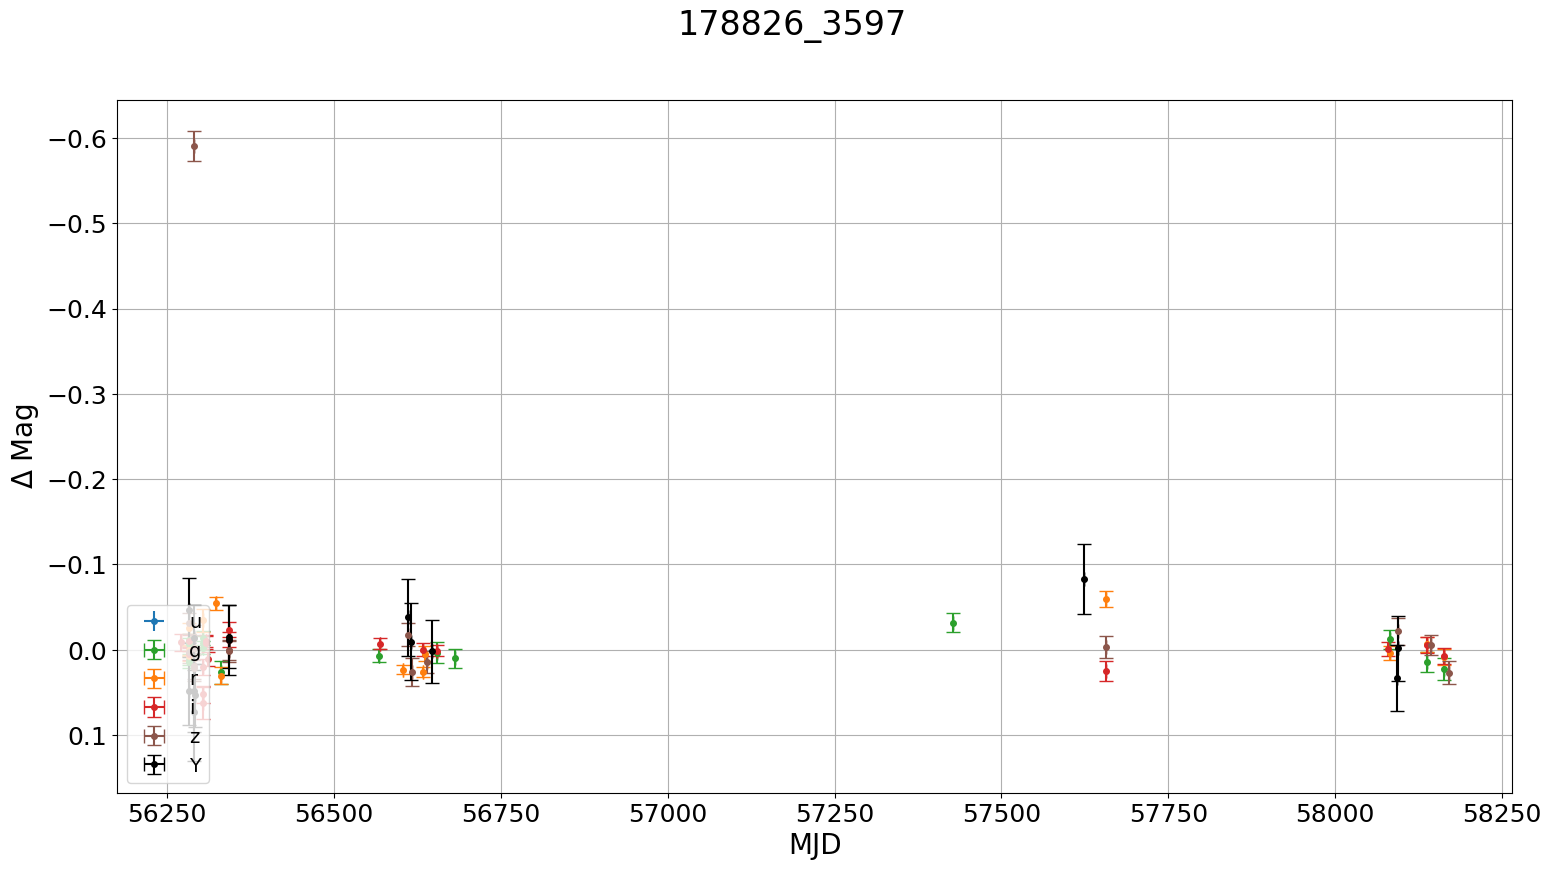

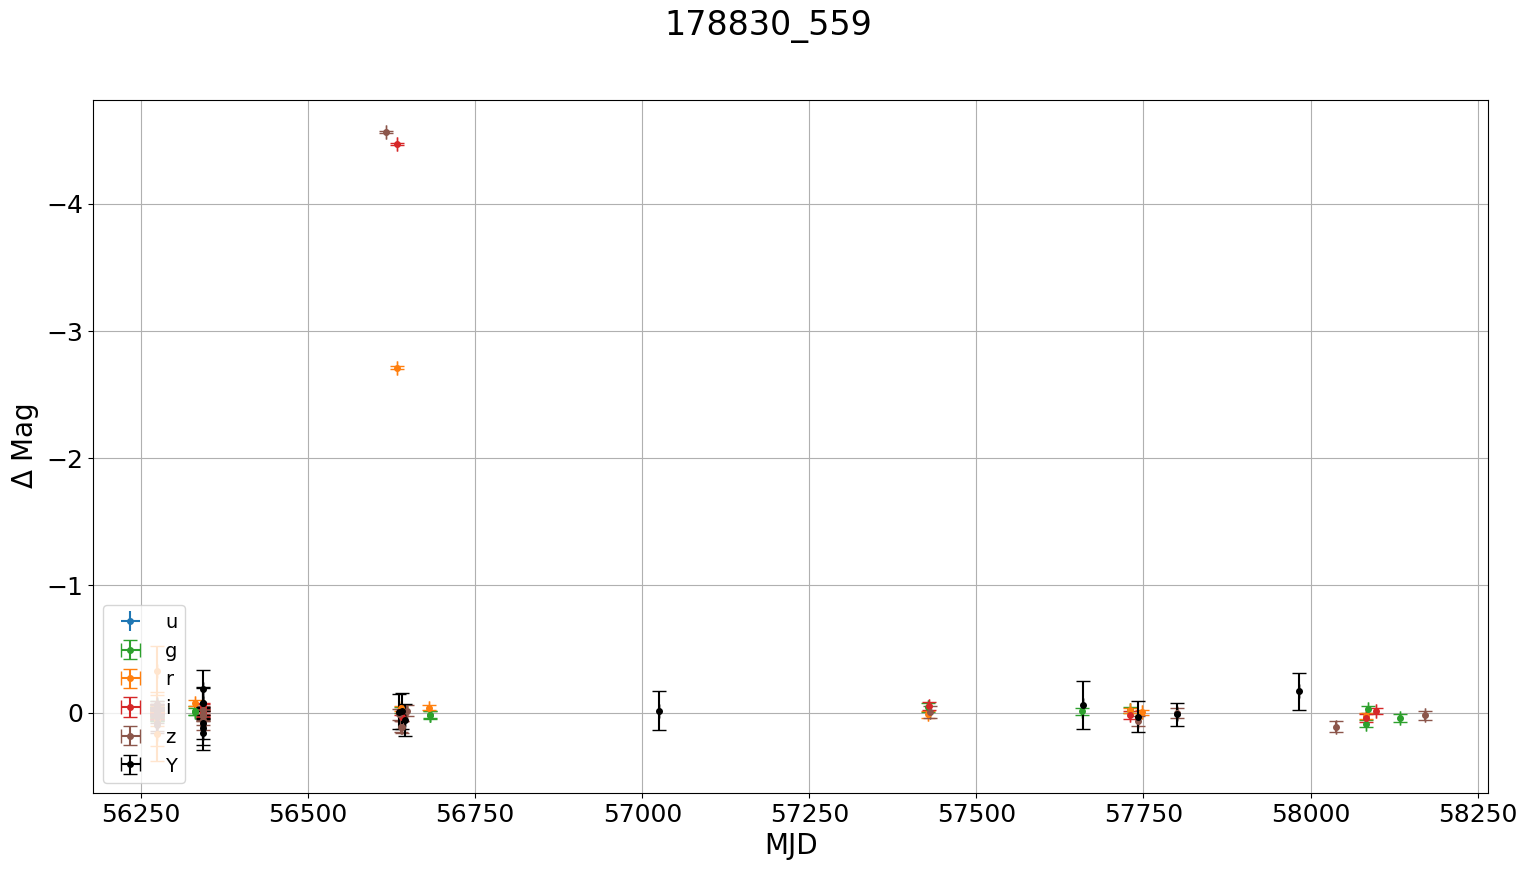

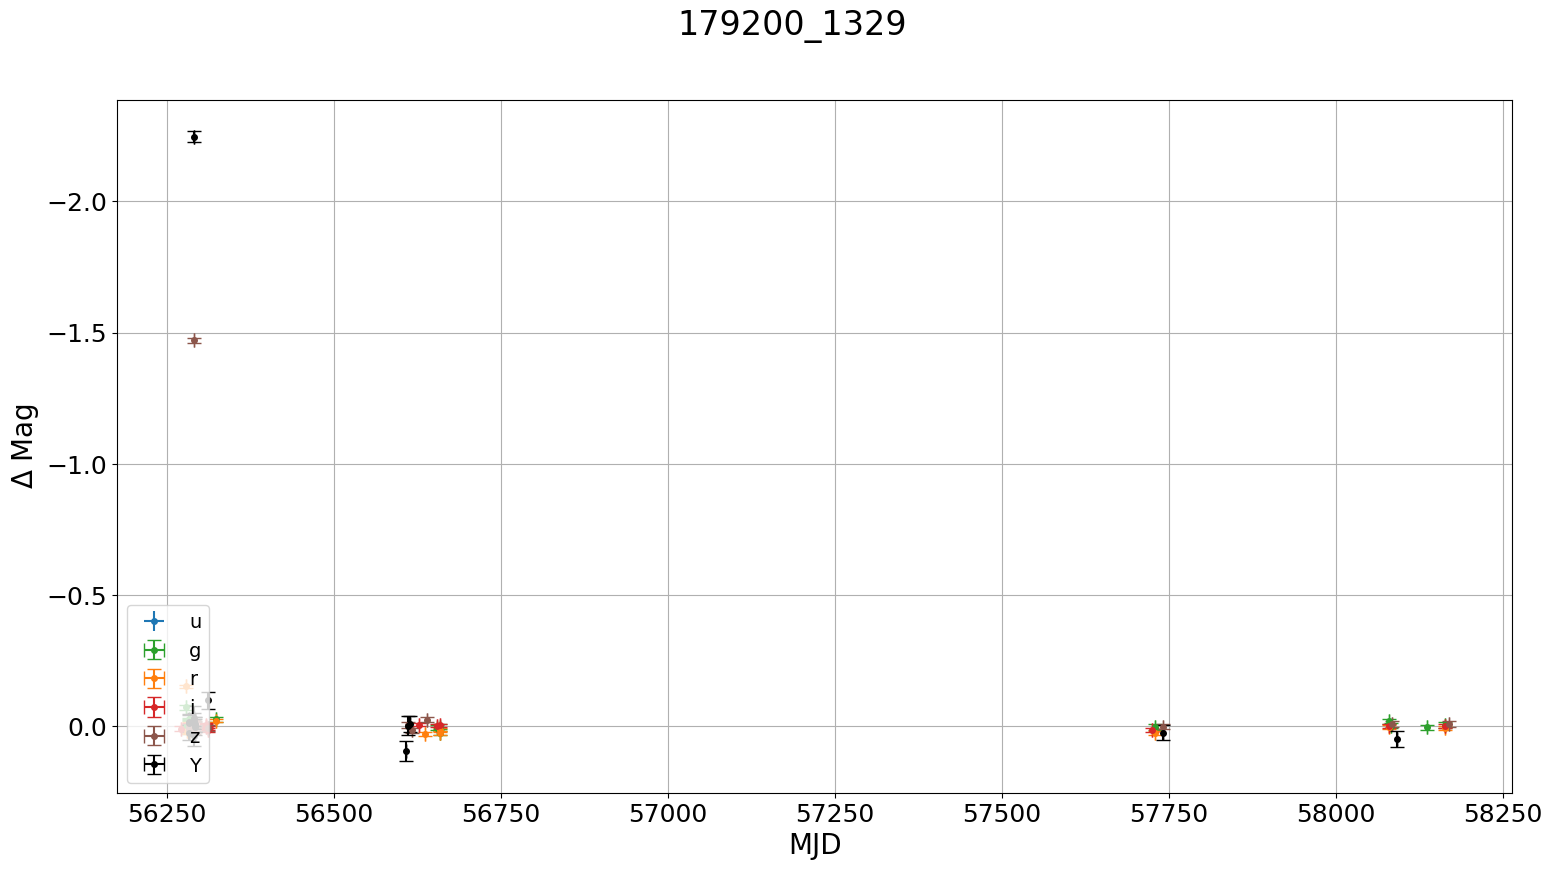

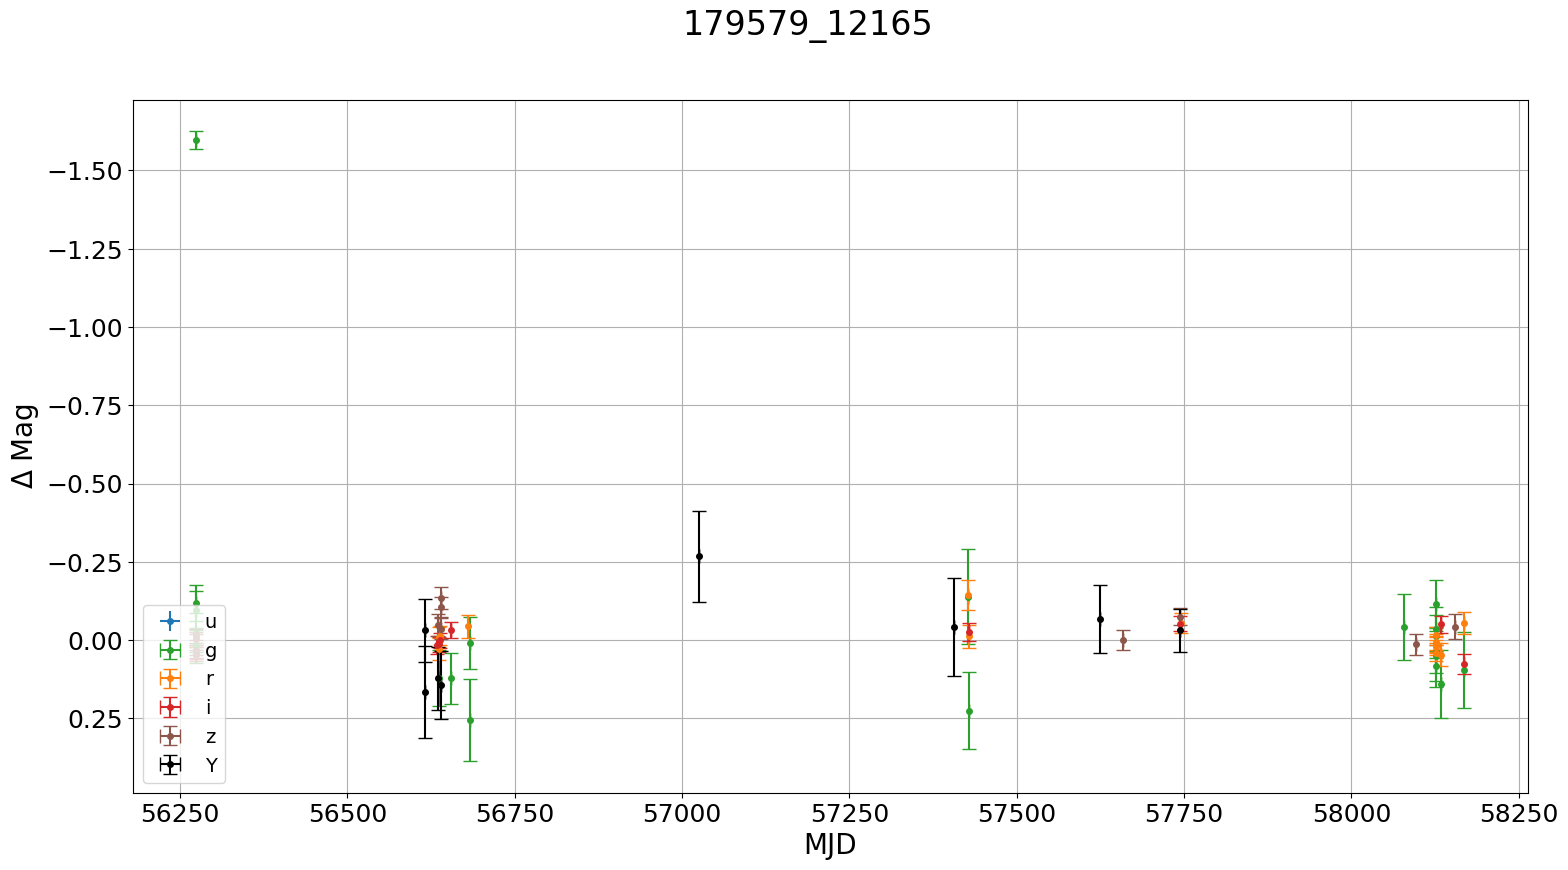

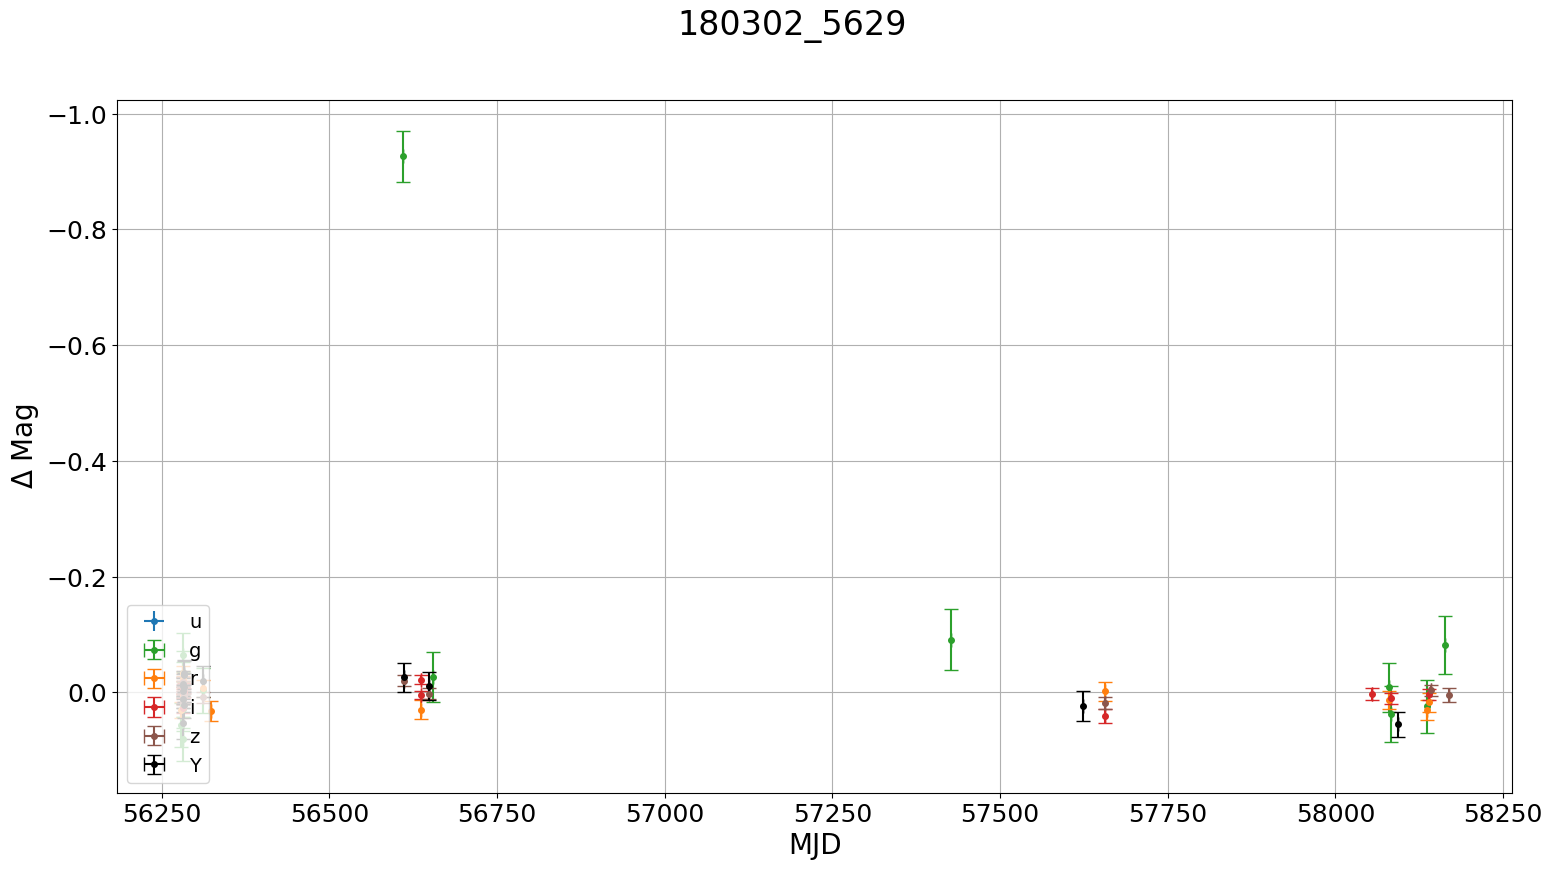

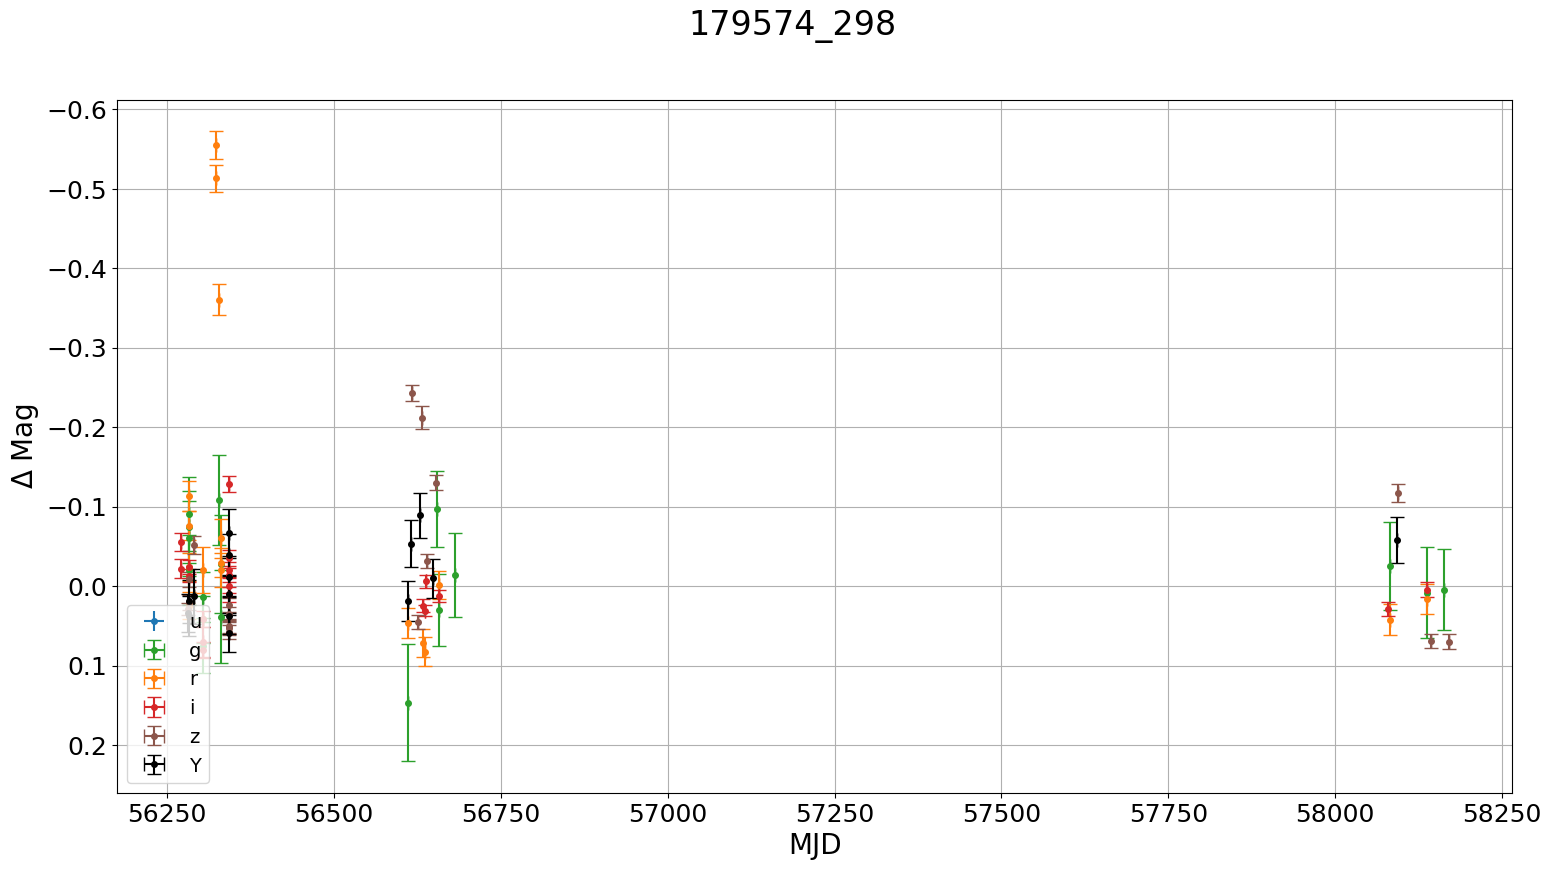

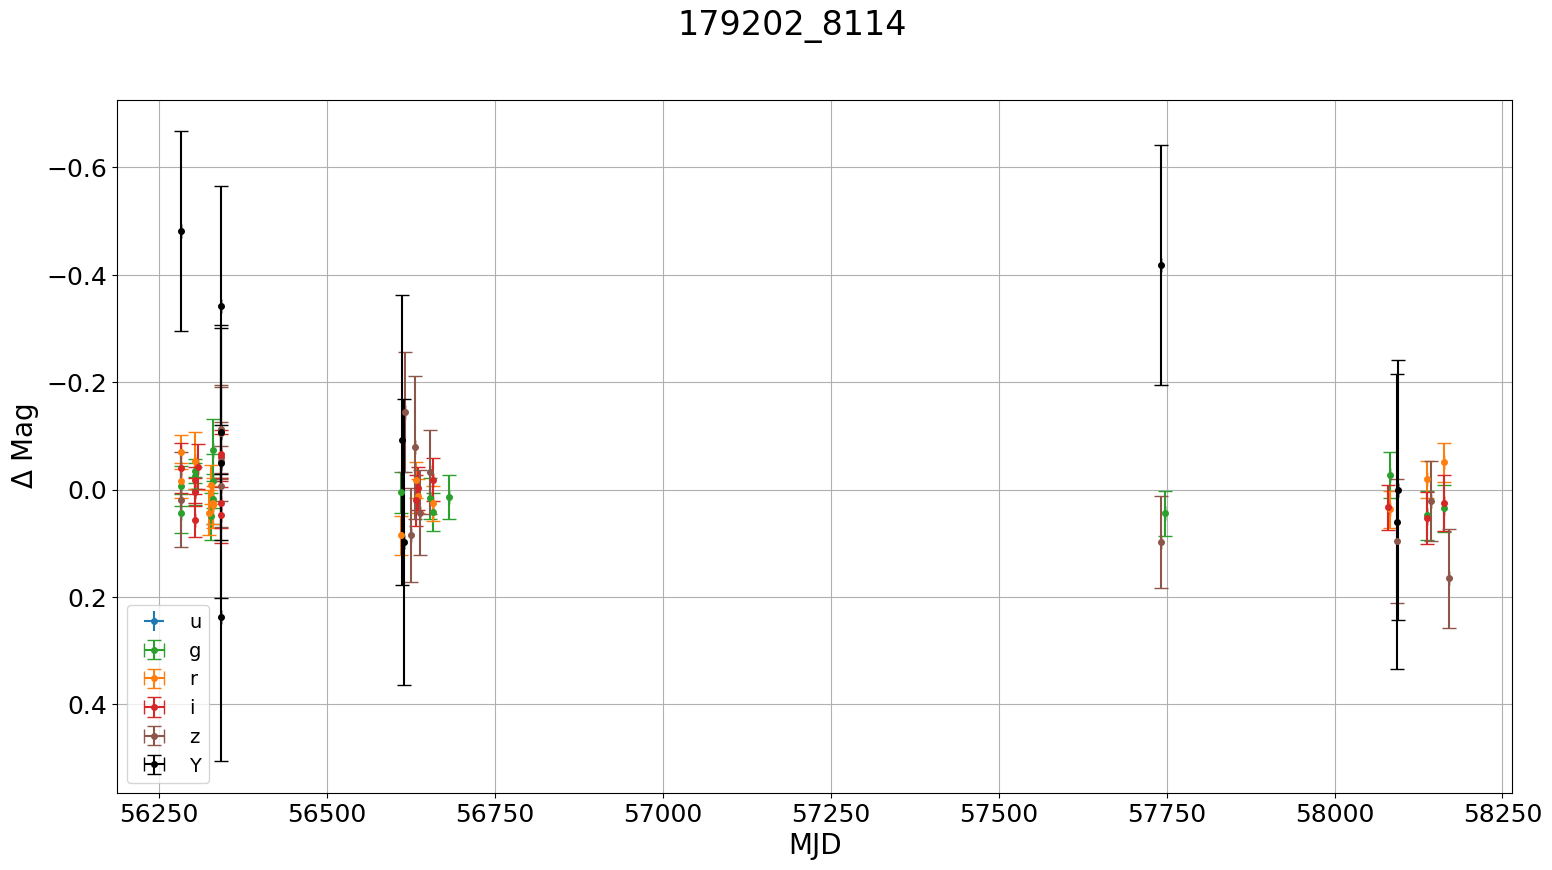

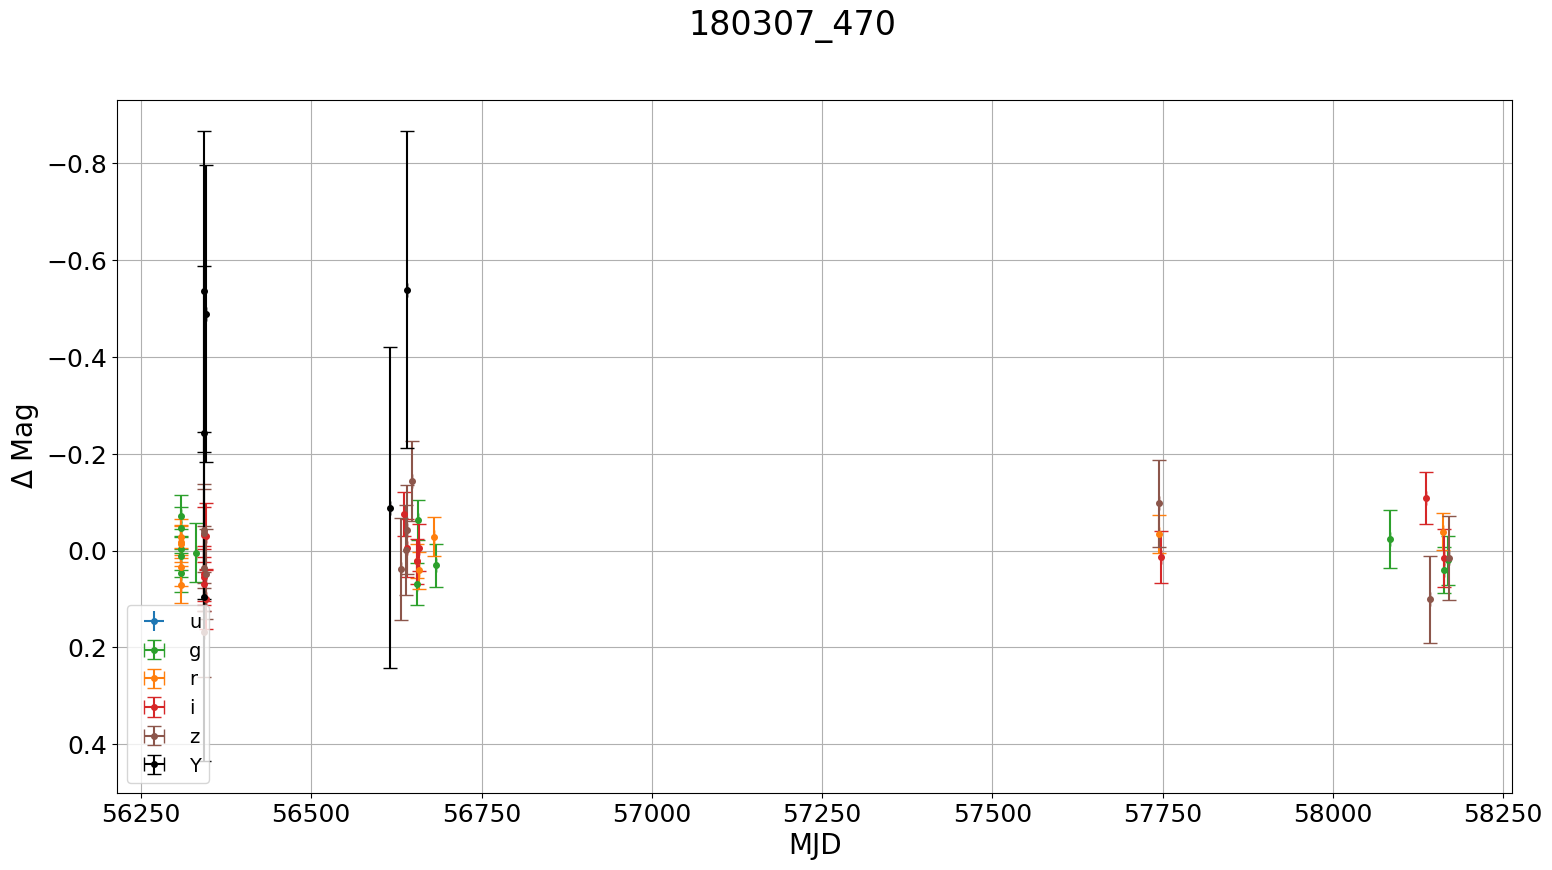

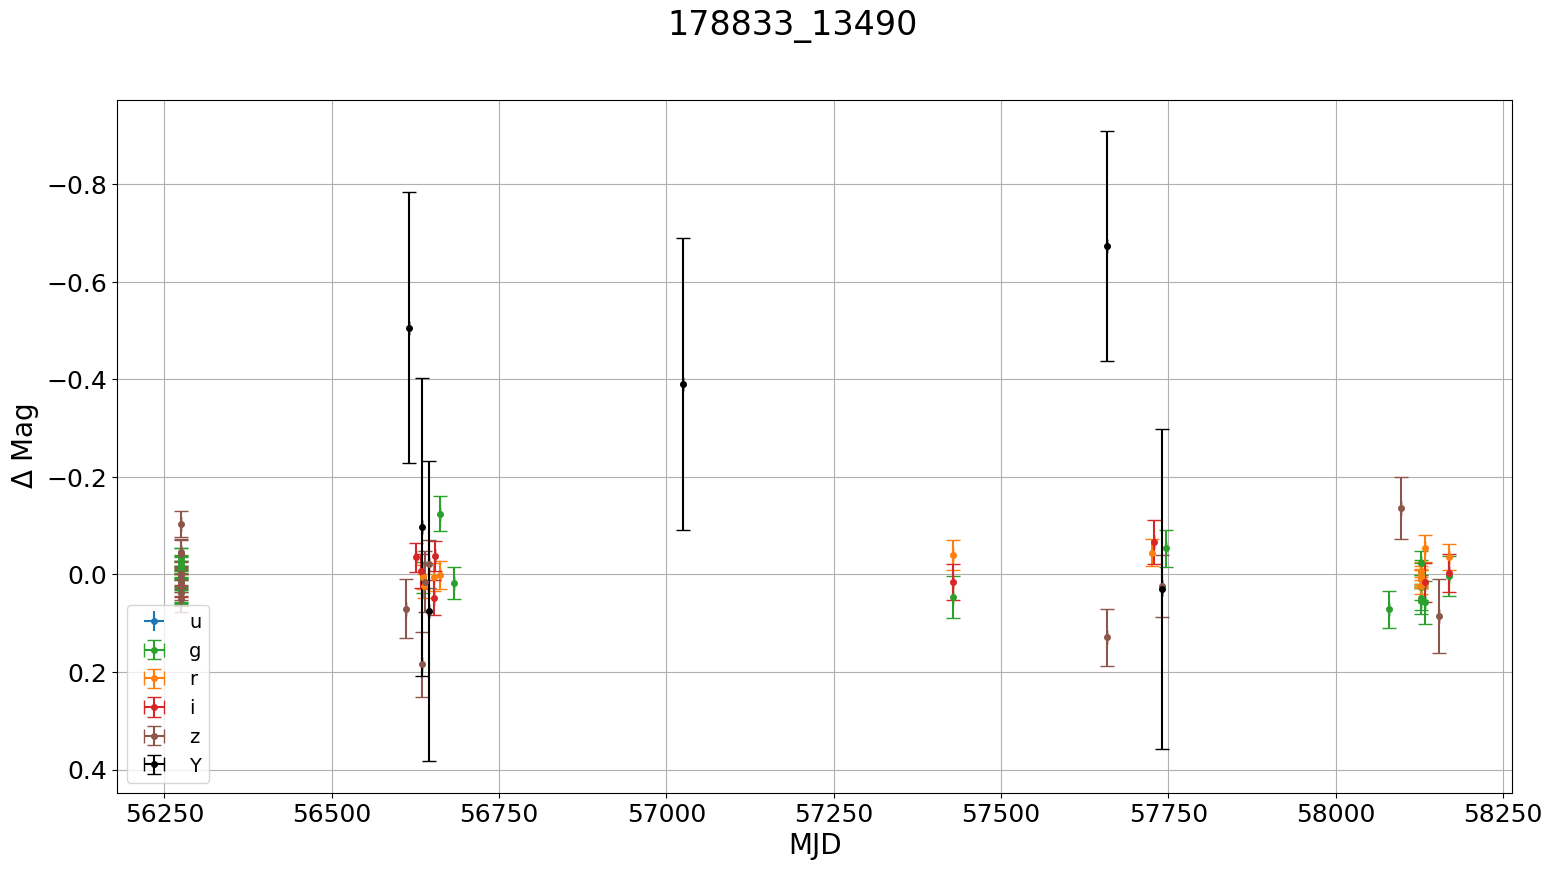

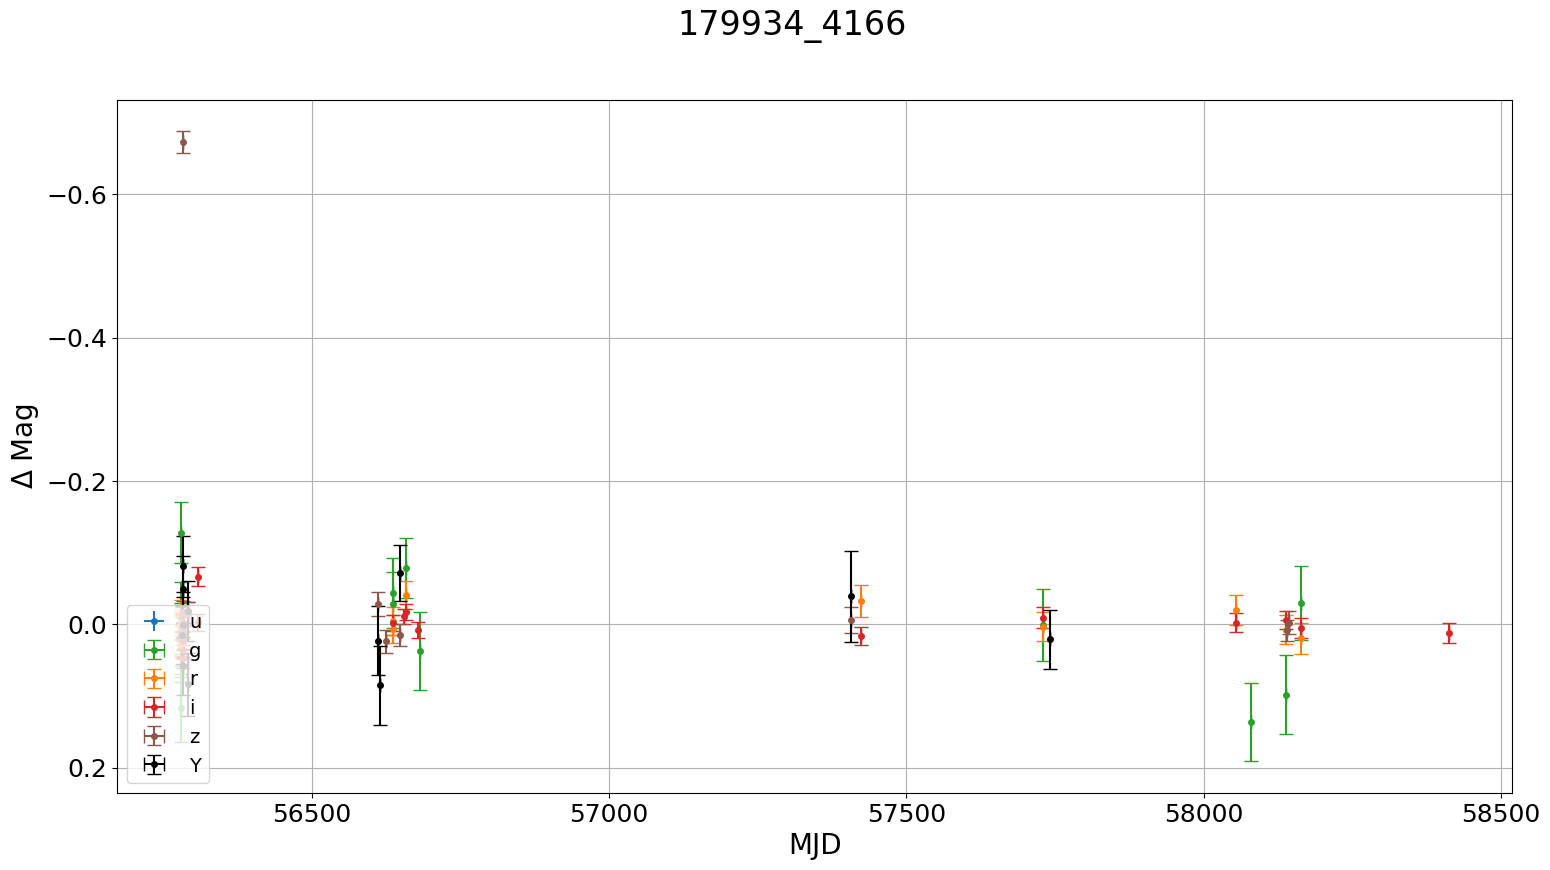

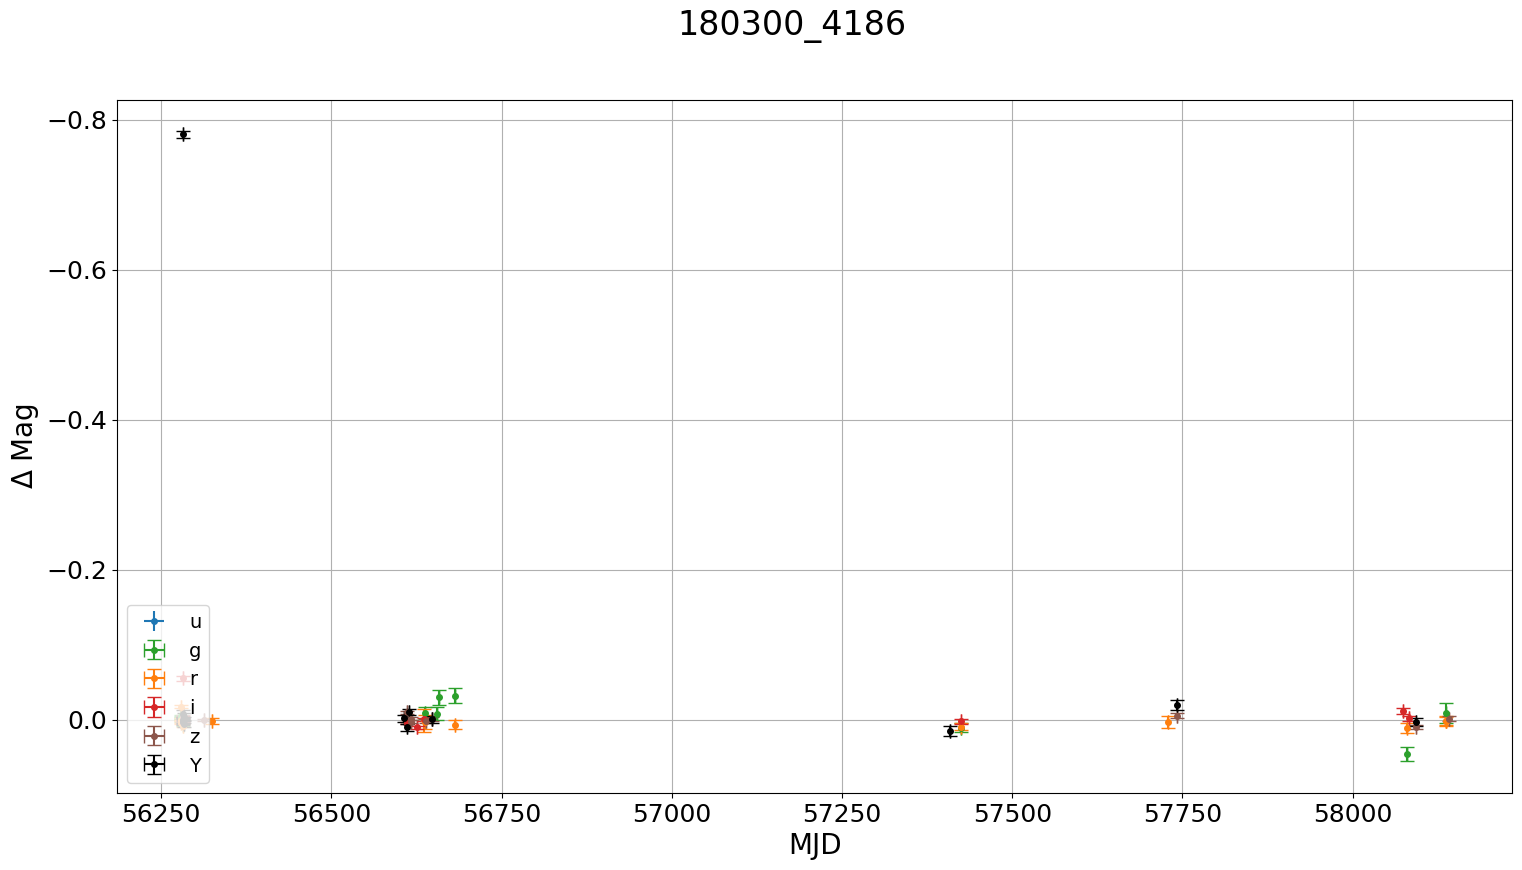

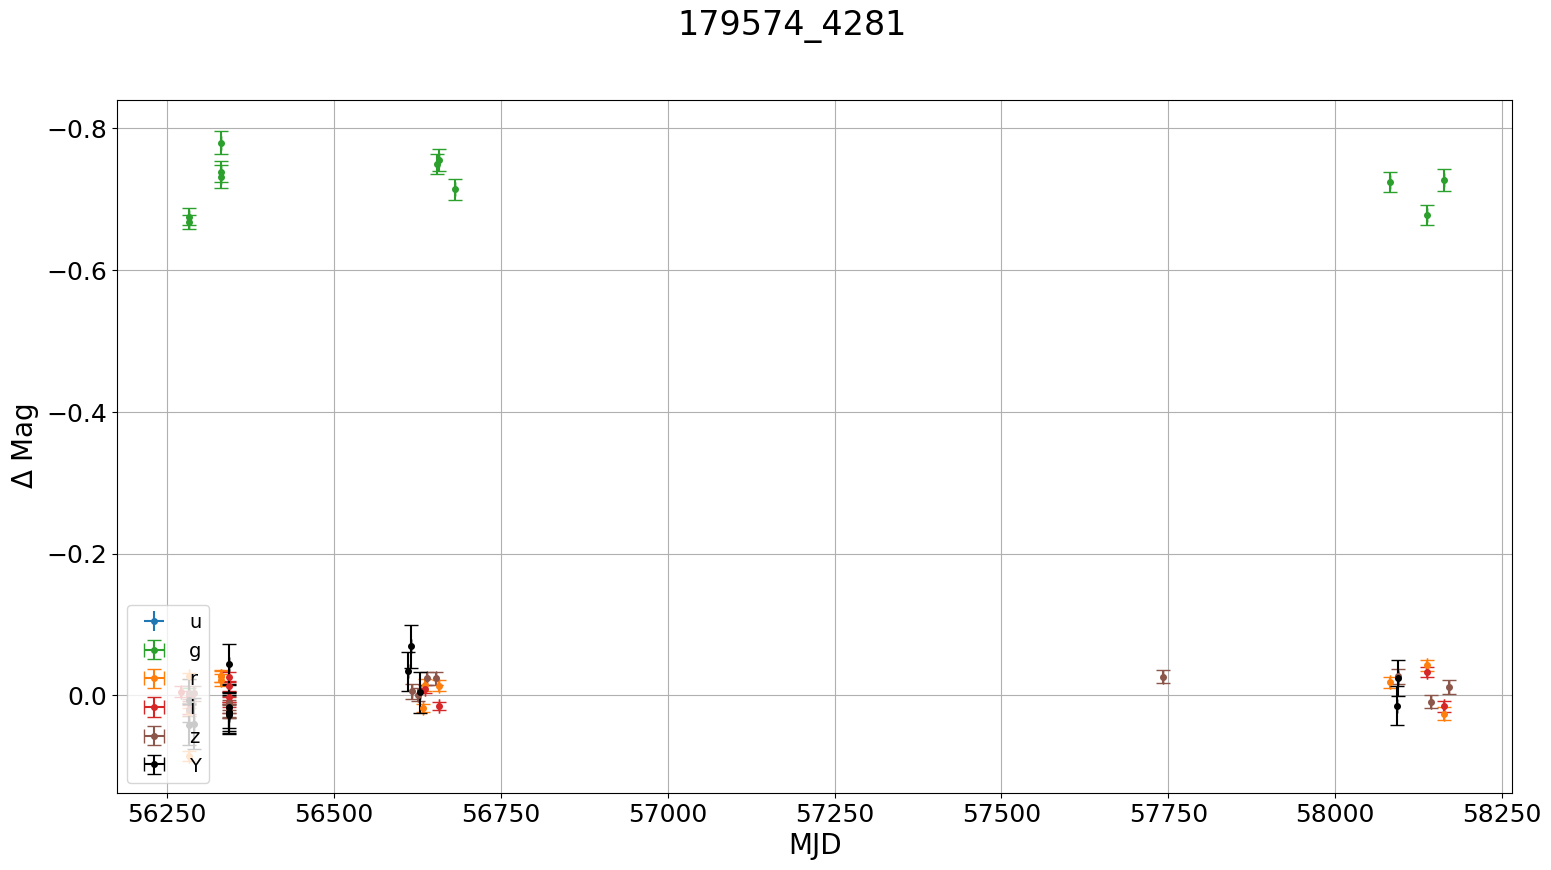

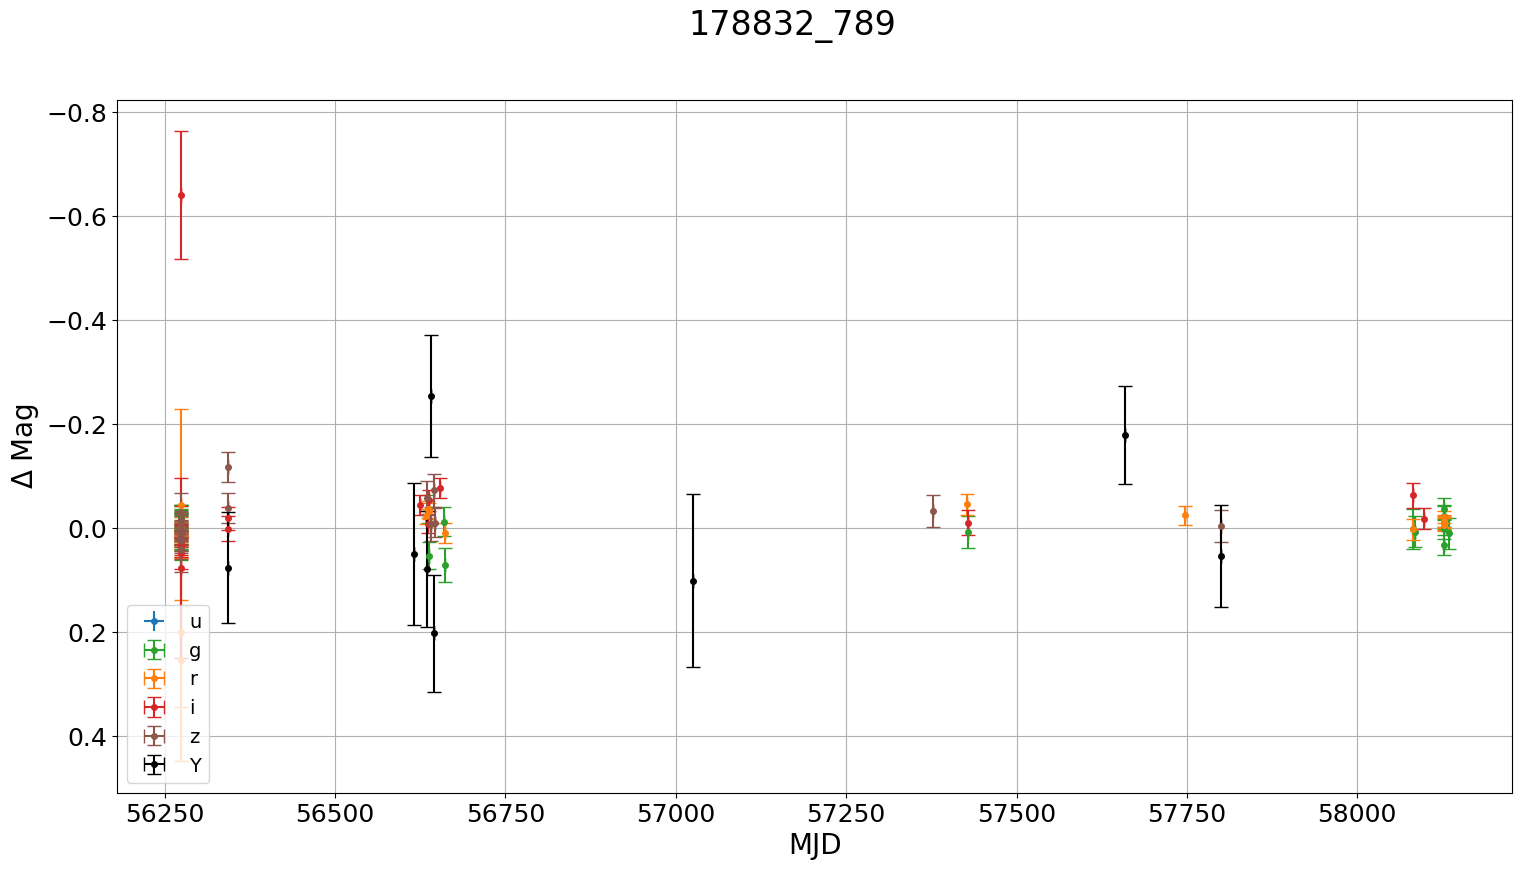

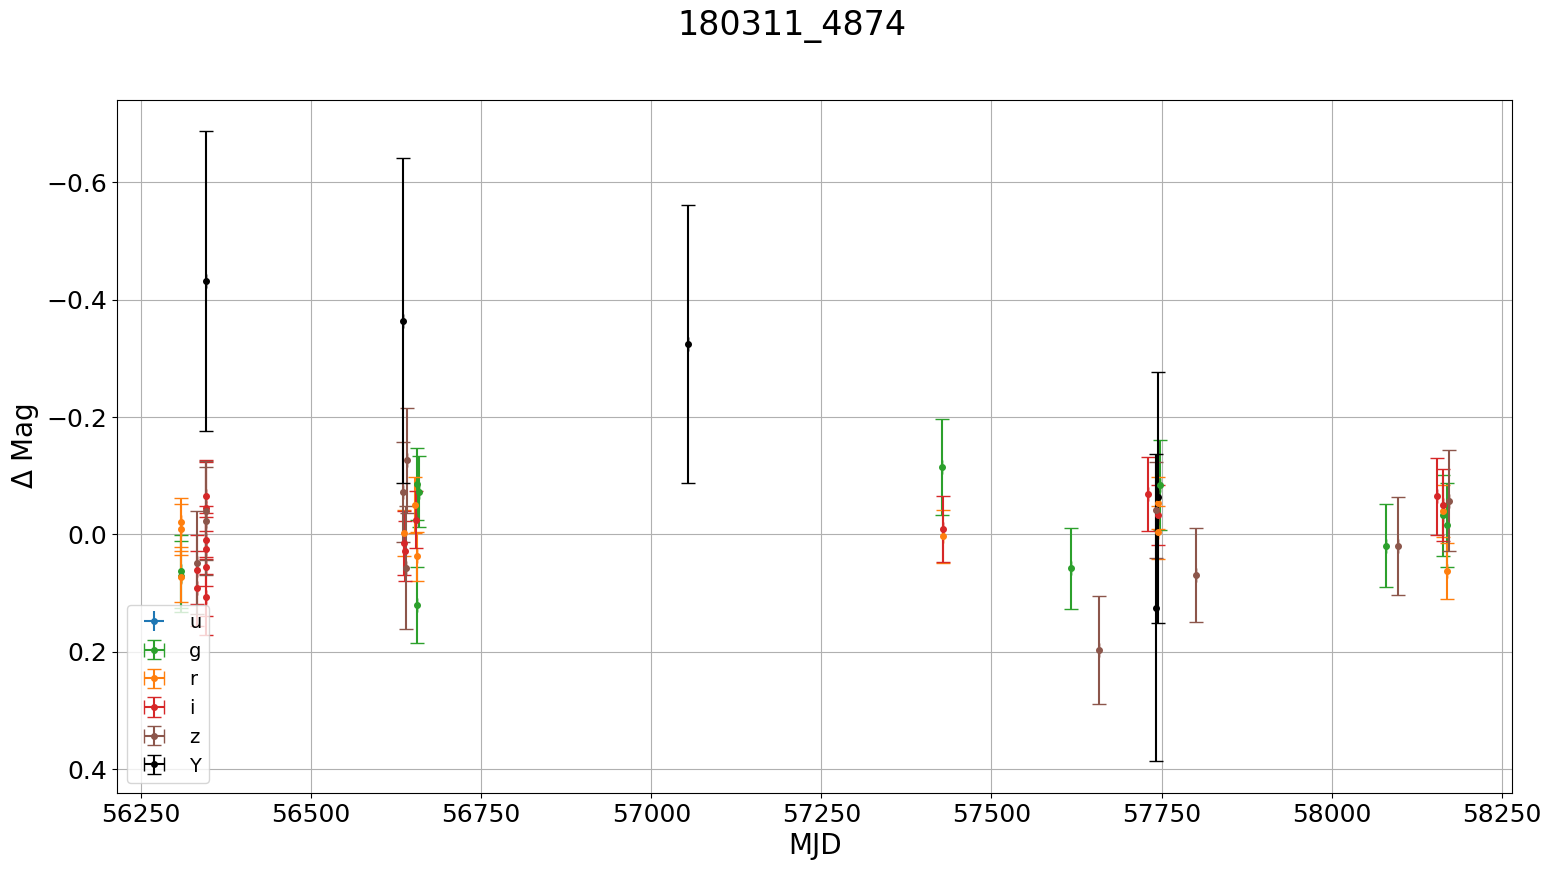

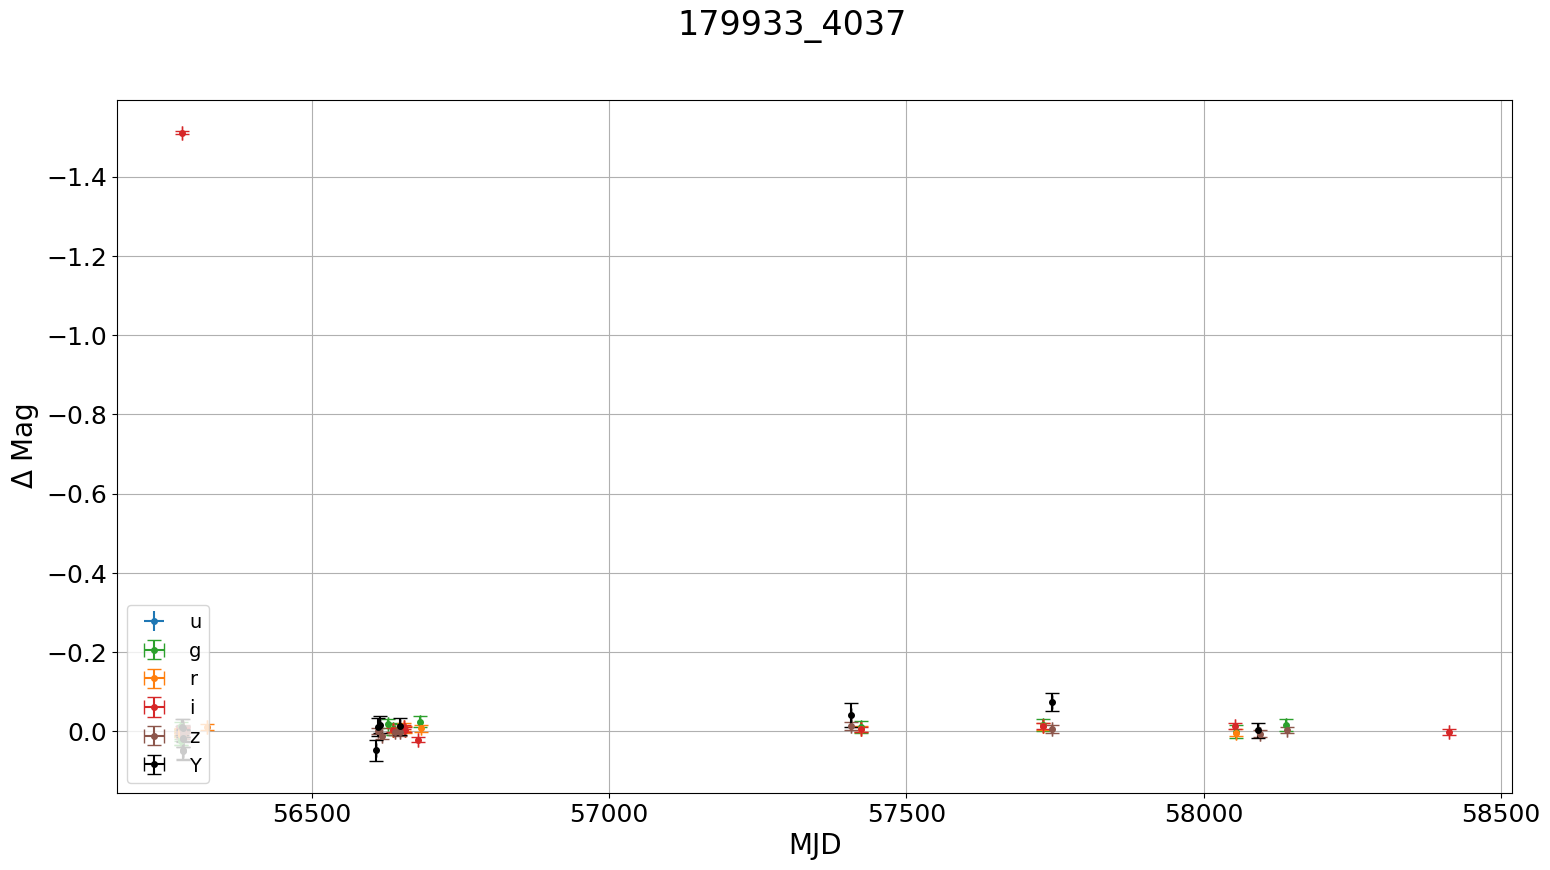

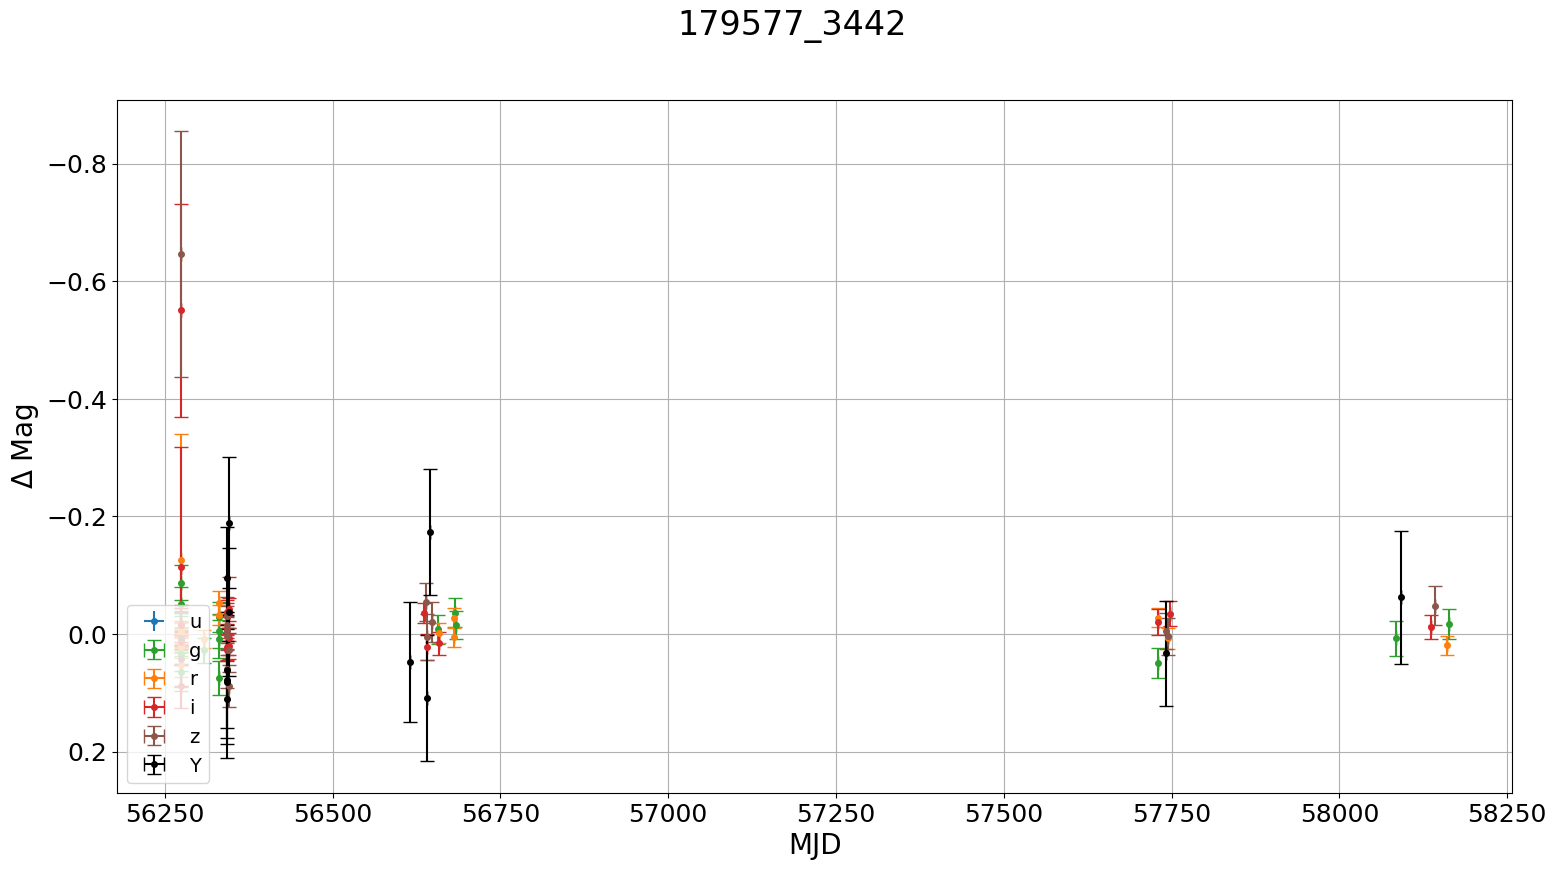

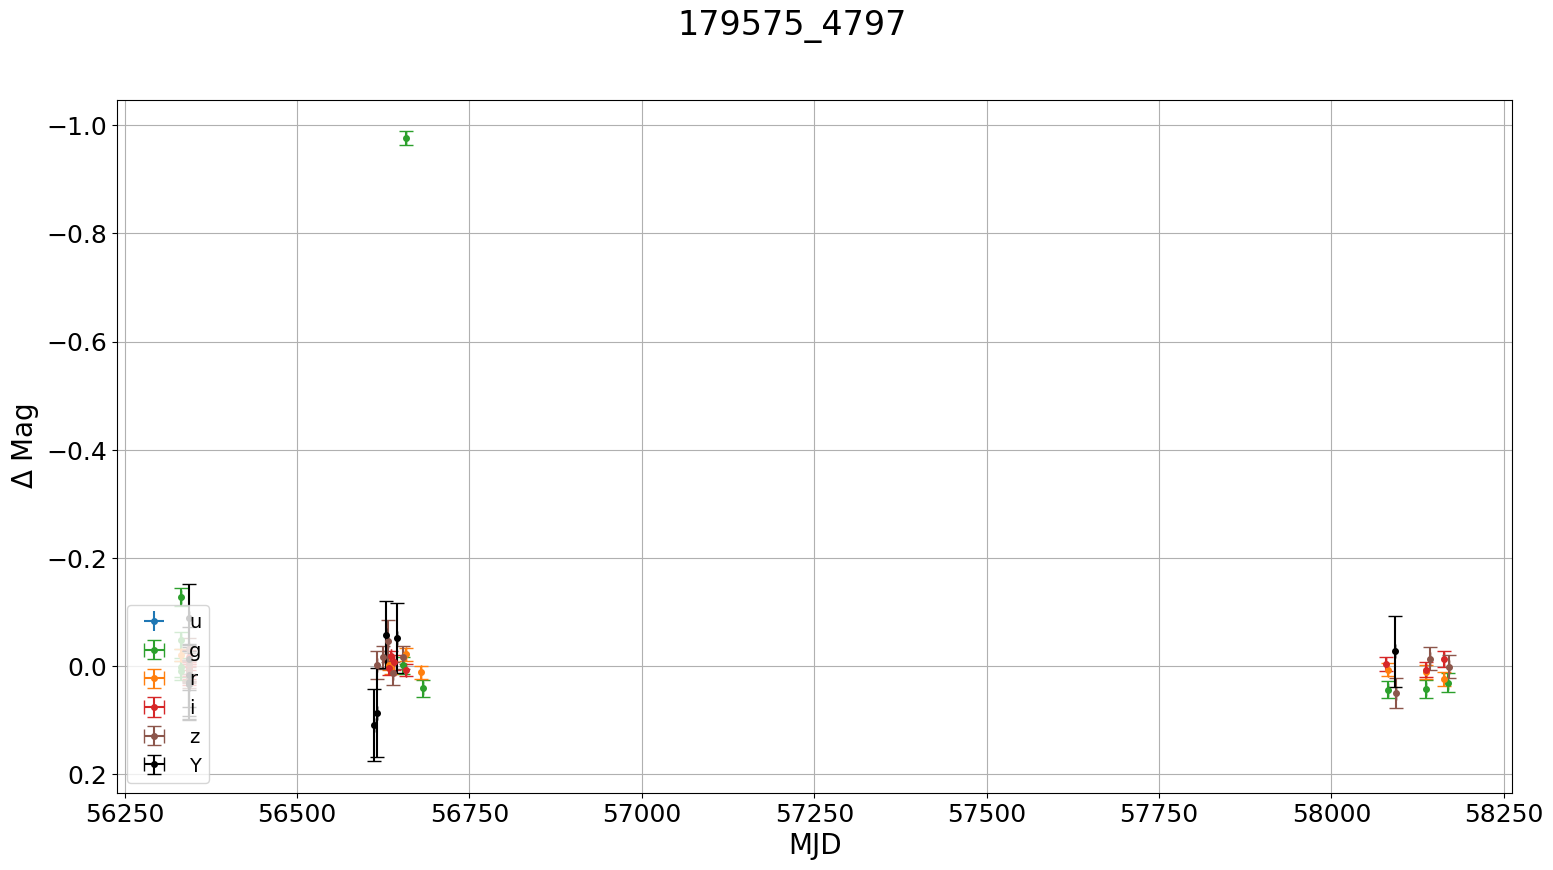

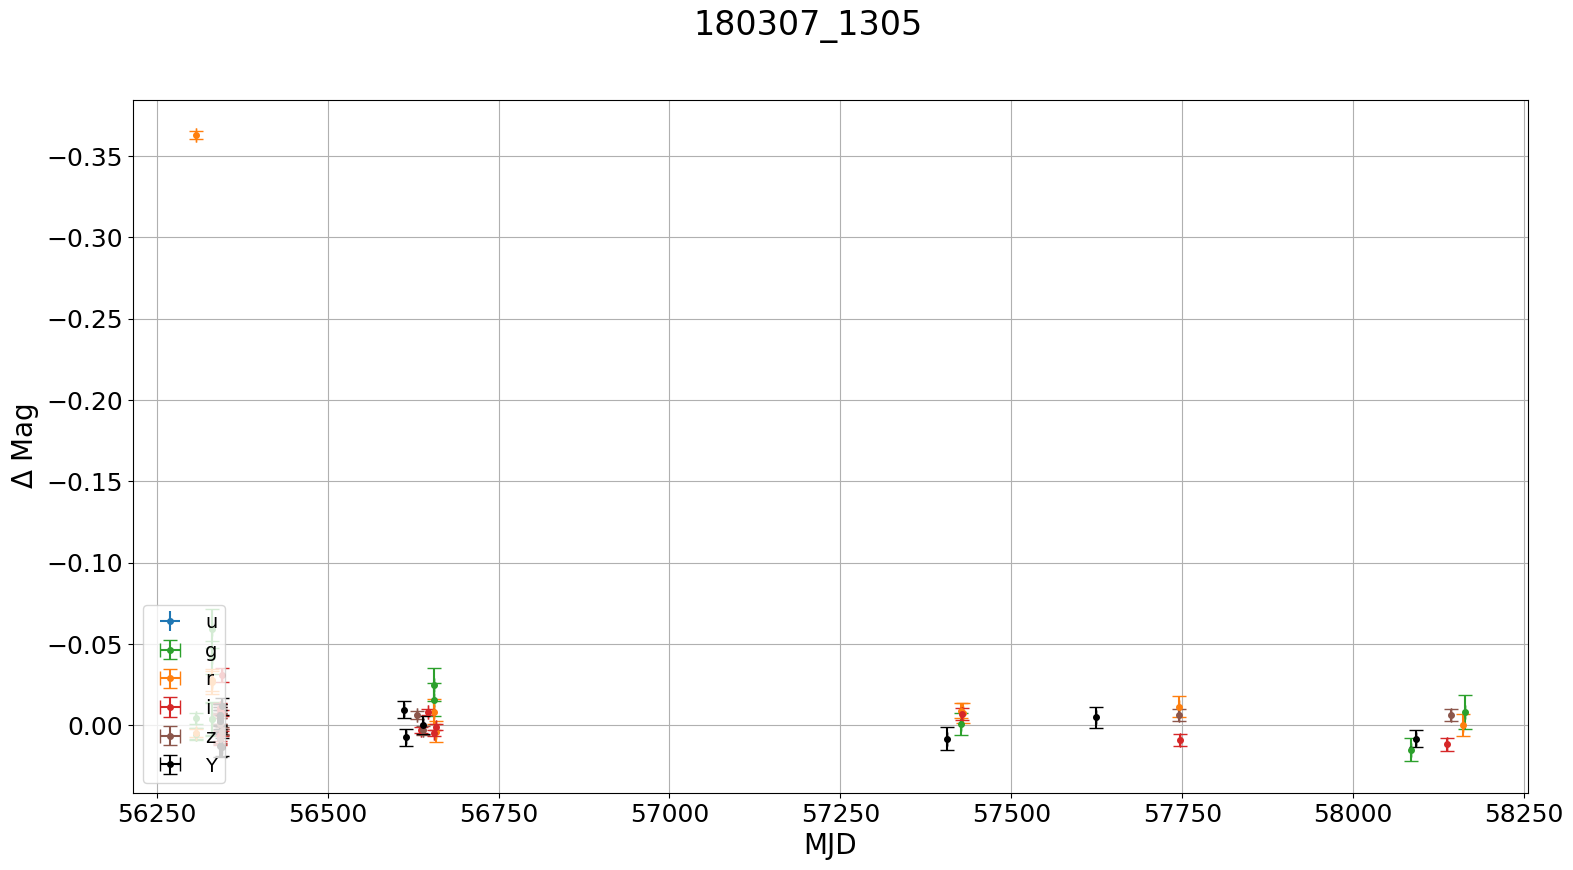

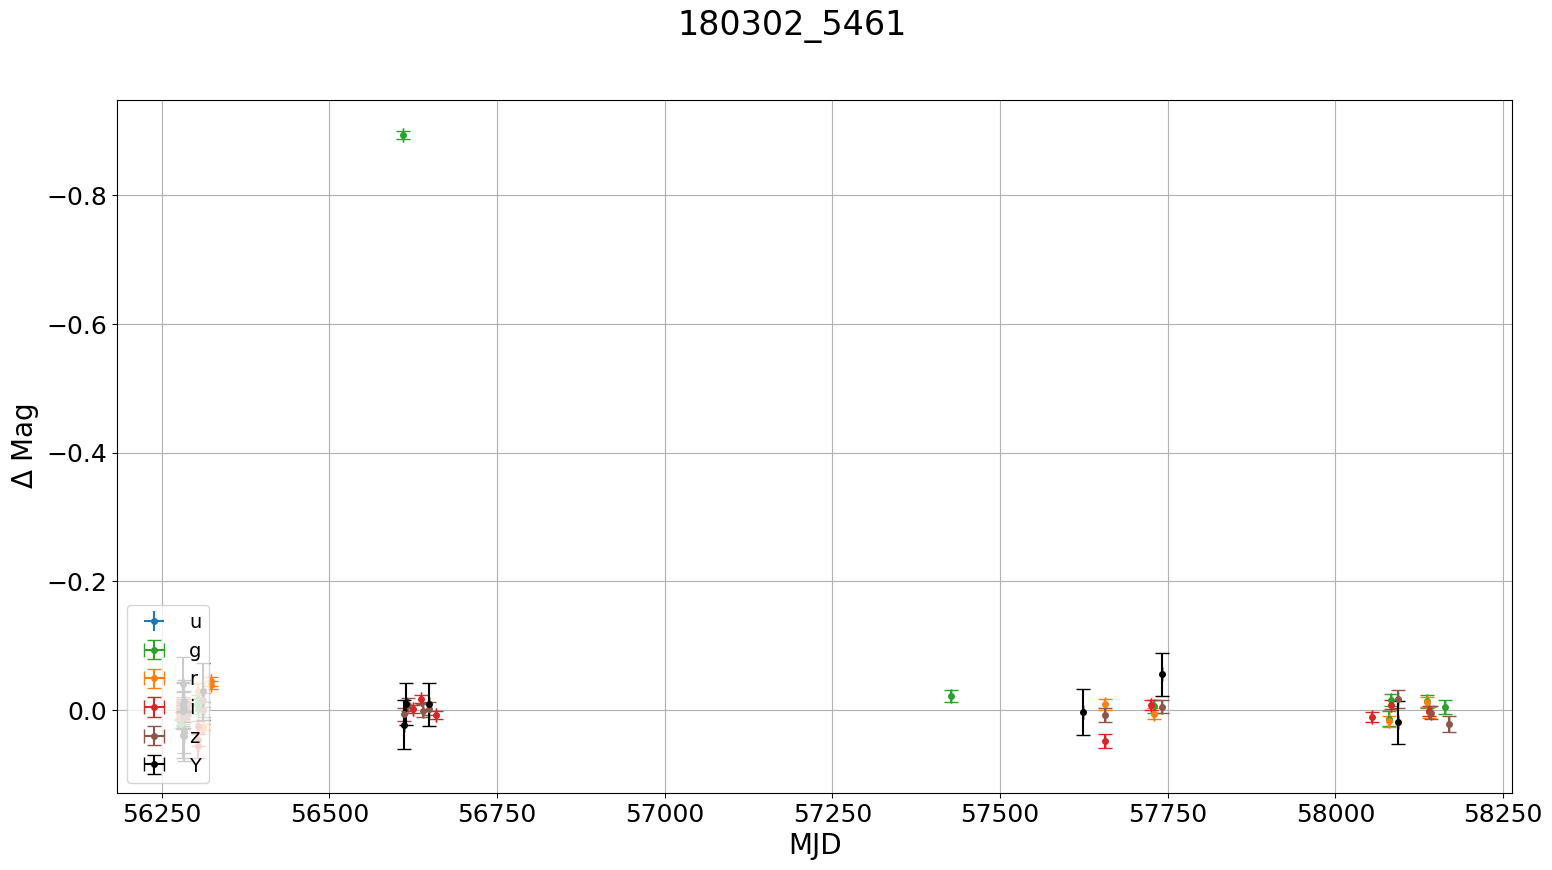

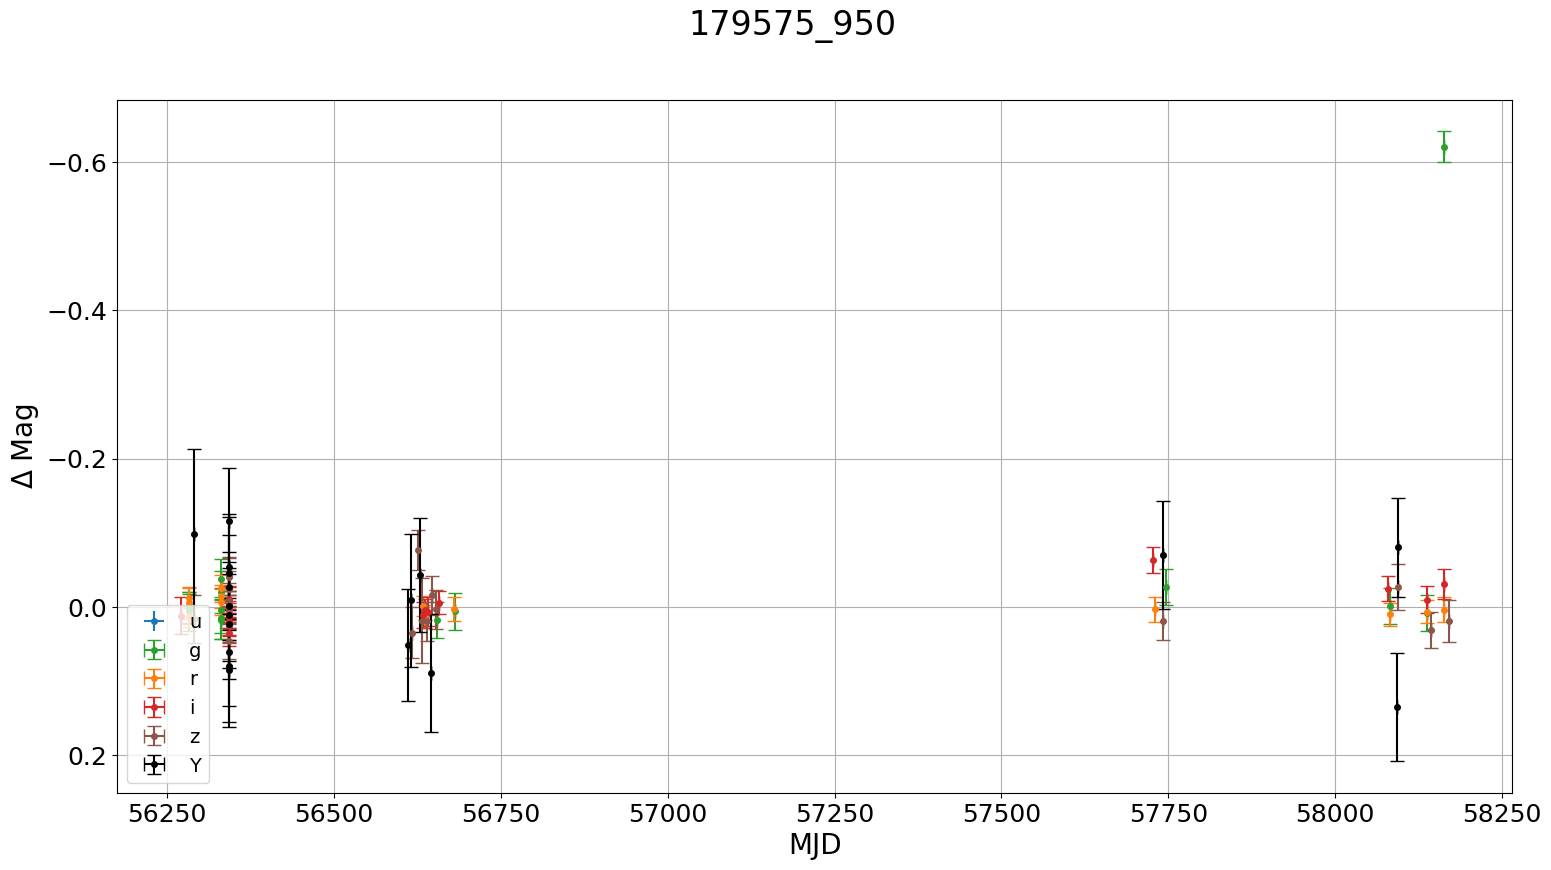

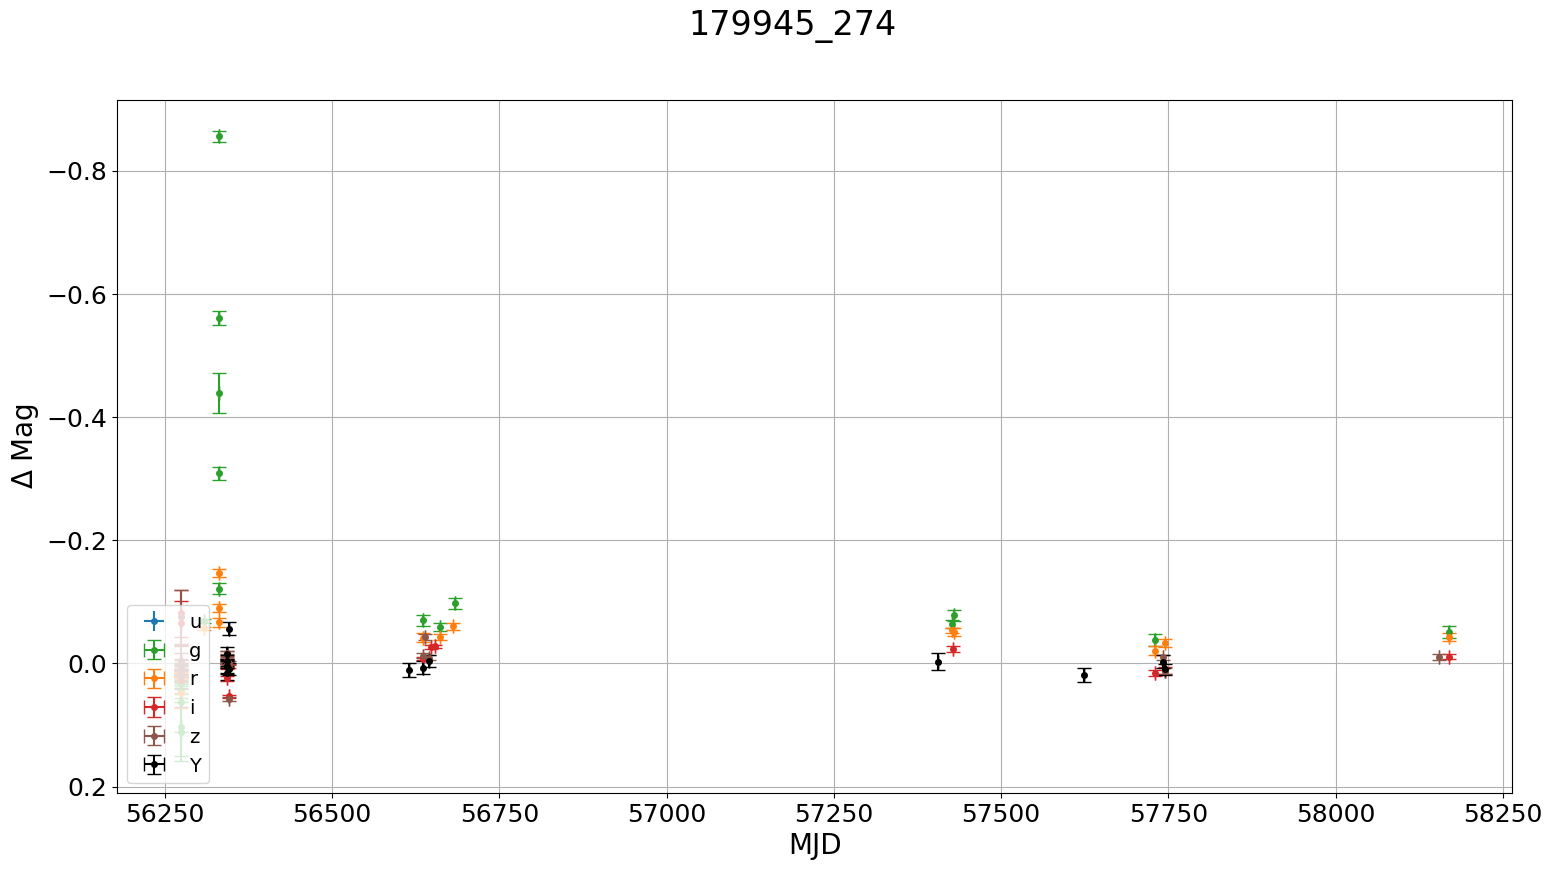

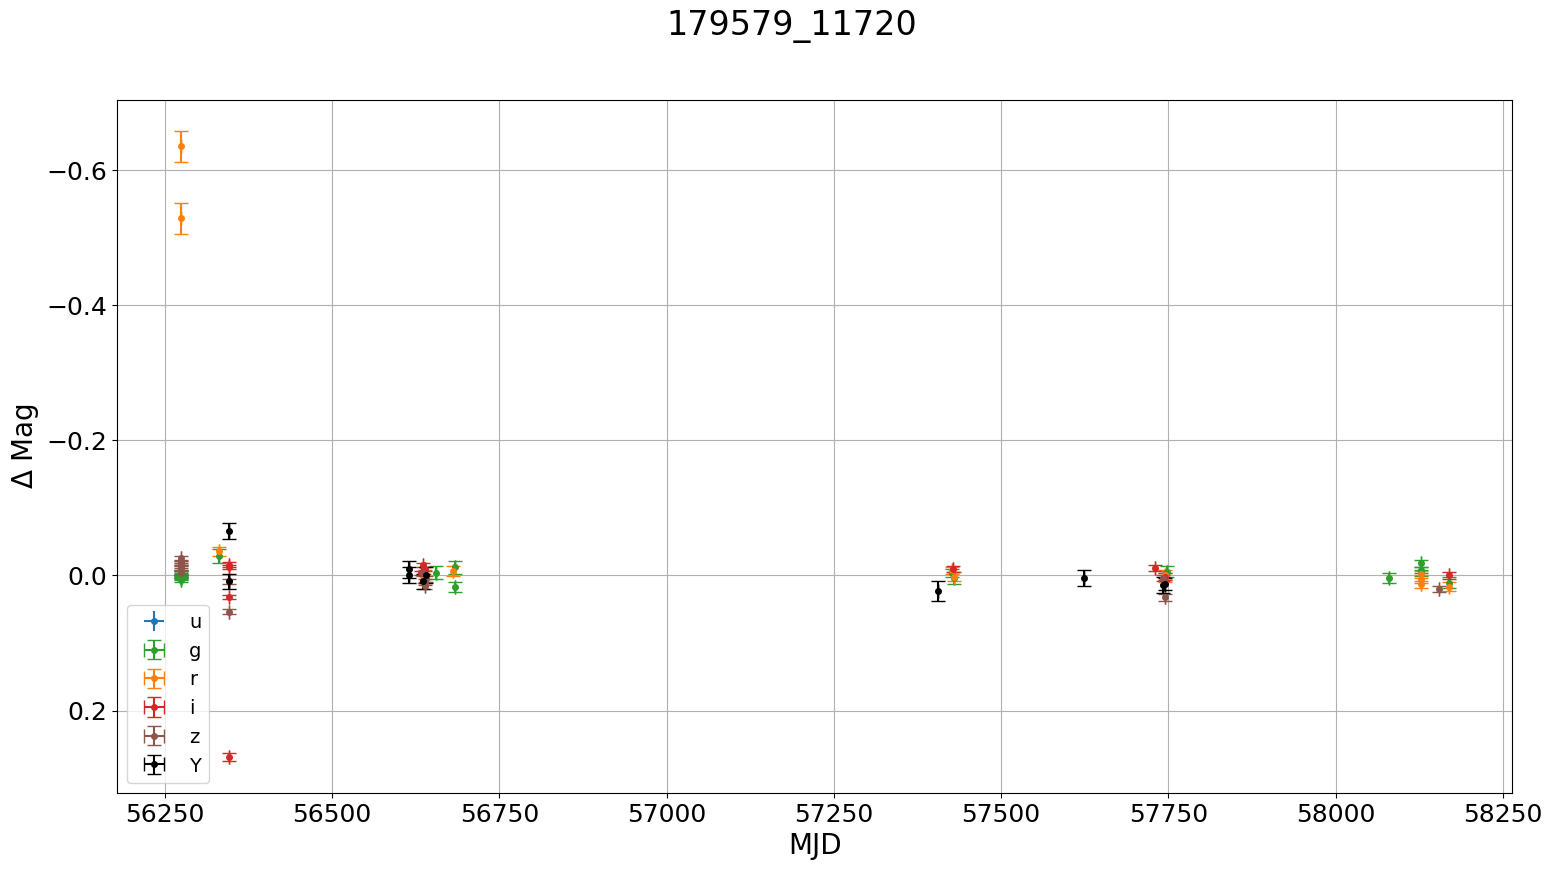

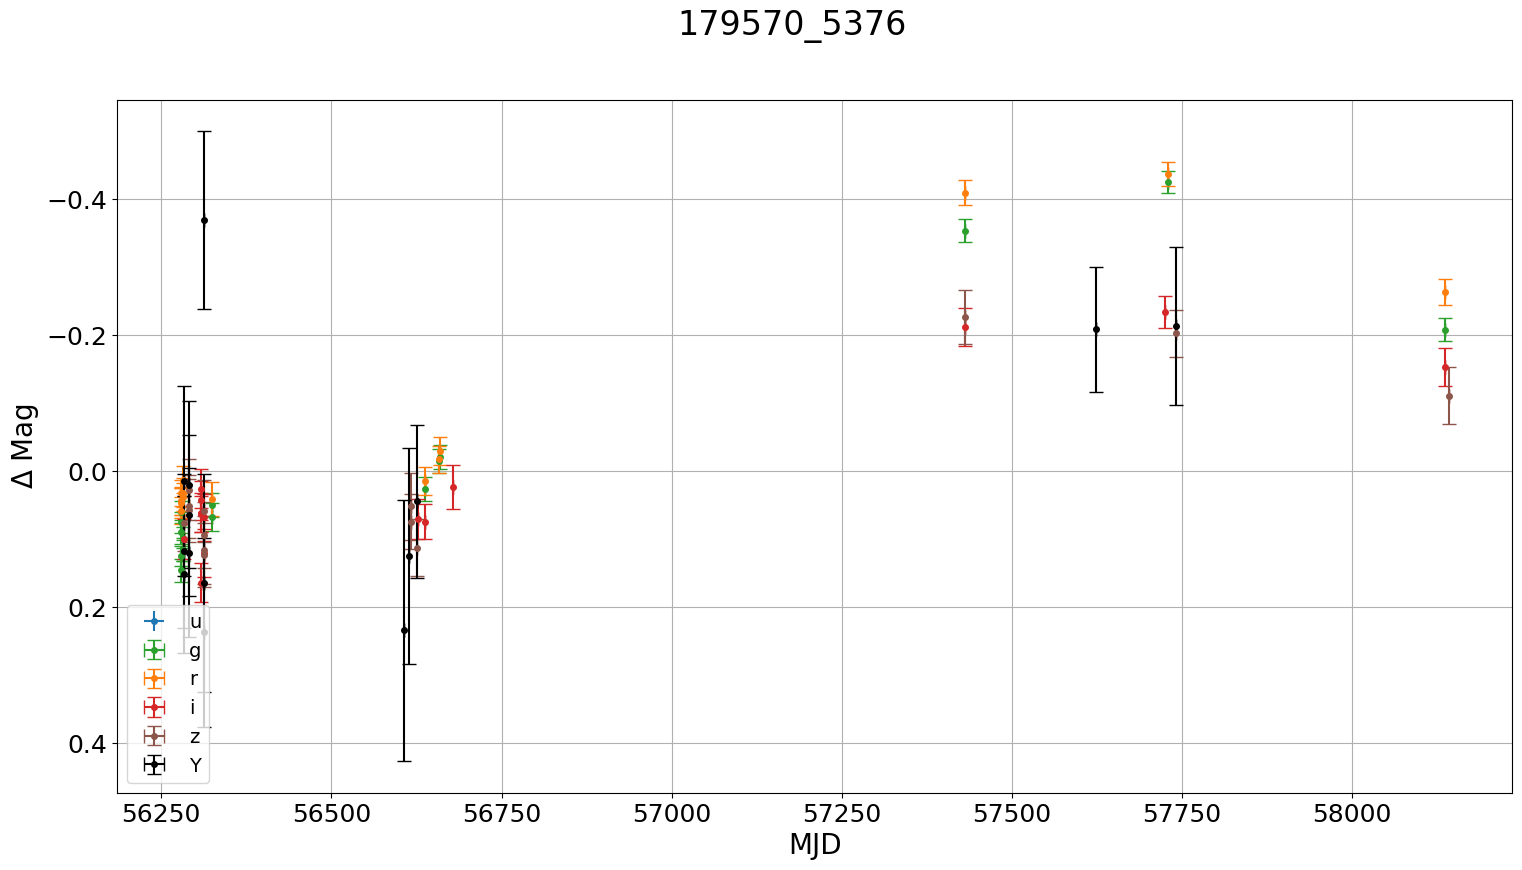

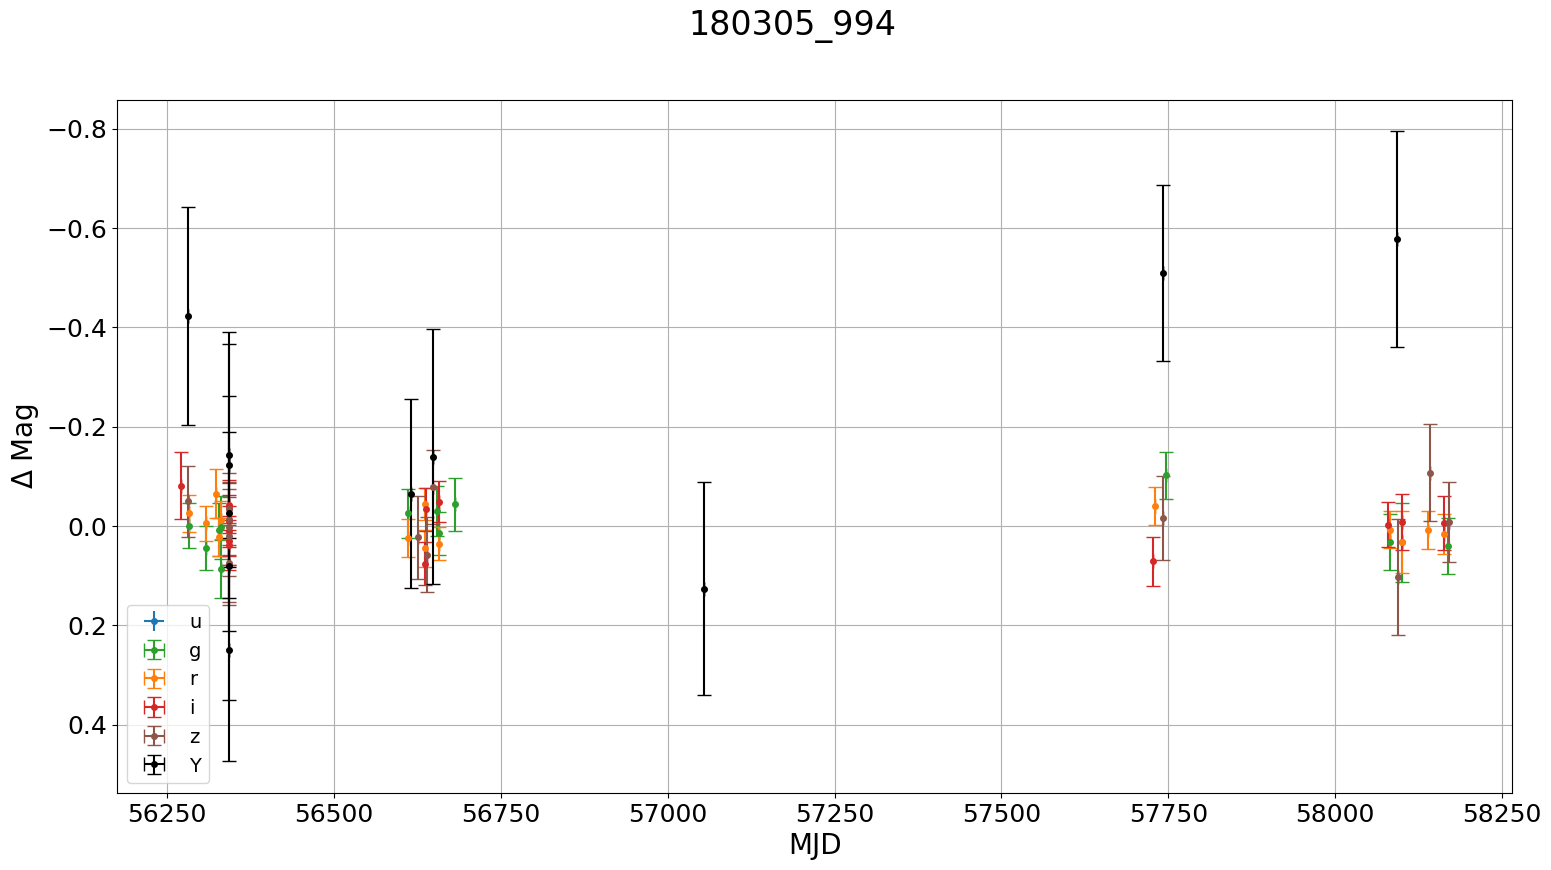

In [104]:
oids = lc_class_df_irl.query("lightcurve_class.isnull()")["objectid"]

for oid in oids[:30]:
    lc = get_lc(oid)
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    lc = cluster_label_dataframe(lc)
    g = lc.groupby(by=["objectid", "filter"], sort=False, group_keys=False)
    baseline_subtracted = subtract_baseline(g)
    plot_lightcurve(baseline_subtracted, ax, mag_column="delta_mag", magerr_column="delta_mag_err")
    ax = fig.get_axes()[0]
    ax.legend(fontsize=14, loc="lower left")
    ax.set_ylabel(r"$\Delta$ Mag", fontsize=20)
    ax.set_xlabel("MJD", fontsize=20)
    # ax.set_ylim((1, -1))
    fig.suptitle(f"{oid}", fontsize=24)
    plt.show(fig)
    plt.close(fig)

In [114]:
lc

objectid filter   mag_auto  magerr_auto           mjd  \
787  181737_11323      g  17.508930     0.043955  56233.300314   
62   181737_11323      g  17.518614     0.044296  56233.301511   
926  181737_11323      g  17.492210     0.010848  56233.302526   
789  181737_11323      r  16.950983     0.008416  56233.303009   
194  181737_11323      i  16.745947     0.008322  56233.303493   
..            ...    ...        ...          ...           ...   
776  181737_11323      Y  16.683111     0.015256  58802.194864   
269  181737_11323      z  16.683807     0.008570  58802.195437   
177  181737_11323      i  16.784190     0.007566  58802.195936   
518  181737_11323      r  16.981823     0.008219  58802.196461   
274  181737_11323      g  17.509660     0.013900  58802.196974   

                       exposure  exptime  
787                   tu1857575        1  
62                    tu1857586        1  
926                   tu1857592       15  
789                   tu1857733       15  
194                   tu1857627       15  
..                          ...      ...  
776  c4d_191115_044036_ooi_Y_v1       20  
269  c4d_191115_044125_ooi_z_v1       15  
177  c4d_191115_044208_ooi_i_v1       15  
518  c4d_191115_044254_ooi_r_v1       15  
274  c4d_191115_044338_ooi_g_v1       15  

[1004 rows x 7 columns]

In [116]:
oids = lc_class_df["objectid"]
n_ev = np.zeros(taus.shape)

for oid in oids[:10]:
    lc = get_lc(oid)
    rng = set_rng_state(oid, rng_state, rng)
    t_last_sample = lc.iloc[-1, 4]
    t_first_sample = lc.iloc[0, 4]
    event_time = (t_last_sample - t_first_sample) + taus
    n_ev_exp = event_time * rates
    n_ev_drawn = rng.poisson(lam=n_ev_exp)
    n_ev += n_ev_drawn

In [117]:
n_ev

array([668.,  47.,   0.,  93.,  35.,  16.,   2.,   1.,   1.,   0.,   1.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [129]:
er_df.loc["counts"].iloc[21:23]

tau21     7.078162
tau22    10.352216
Name: counts, dtype: float64

In [127]:
taus[21:23]

array([1.20679264, 1.75751062])

In [131]:
len(lc_class_df_irl.query("lightcurve_class == 'unstable'")) / len(lc_class_df_irl)

0.04266860477763893